In [2]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys
sys.path.insert(0, os.path.abspath('..'))

NameError: name 'os' is not defined

In [64]:
start_day_to_analyze = '2020-04-09'
end_day_to_analyze = '2020-04-10'

In [65]:
from common import config

base_url = config.prod_base_url
api_key_id = config.prod_api_key_id
api_secret = config.prod_api_secret

In [66]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [67]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [68]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [69]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [70]:
trades

trade_id  algo_run_id symbol operation  qty  price  \
0        1471          228    AAL       buy   56  13.14   
1        1475          228    AAL      sell   56  13.34   
2        1547          228   ADNT       buy   95  12.50   
3        1645          228   ADNT      sell   95  12.32   
4        1443          228   AGNC       buy   78  12.47   
..        ...          ...    ...       ...  ...    ...   
240      1524          228   WTTR       buy  268   3.25   
241      1535          228   WTTR      sell   89   3.33   
242      1539          228   WTTR      sell  179   3.37   
243      1522          228      X       buy  357   7.13   
244      1593          228      X      sell  357   7.08   

                                            indicators  \
0    {'rsi': 74.01898900012652, 'macd': [0.18365765...   
1    {'rsi': 79.82363352881939, 'reasons': 'rsi max...   
2    {'rsi': 63.0377266309325, 'macd': [0.030826354...   
3    {'rsi': 45.34060418097216, 'reasons': 'below c...   
4    {'rsi': 63.47570209430396, 'macd': [0.21113767...   
..                                                 ...   
240  {'rsi': 68.85879961197038, 'macd': [0.00531632...   
241  {'rsi': 74.67980326999889, 'reasons': 'scale-o...   
242  {'rsi': 78.93013072699506, 'reasons': 'rsi max...   
243  {'rsi': 61.37471108315392, 'macd': [0.00786580...   
244  {'rsi': 38.94463561751601, 'reasons': 'below c...   

                        client_time                     tstamp  stop_price  \
0    2020-04-09T14:04:37.831241613Z 2020-04-09 14:04:38.248057       12.08   
1    2020-04-09T14:06:37.006292903Z 2020-04-09 14:06:37.511916       12.08   
2    2020-04-09T14:42:25.761083906Z 2020-04-09 14:42:29.933815       11.88   
3    2020-04-09T15:06:04.748753914Z 2020-04-09 15:06:04.974920       11.88   
4    2020-04-09T13:50:21.127306177Z 2020-04-09 13:50:31.391455       11.71   
..                              ...                        ...         ...   
240  2020-04-09T14:36:13.831874064Z 2020-04-09 14:36:24.664538        3.03   
241  2020-04-09T14:38:19.589102962Z 2020-04-09 14:38:30.912681        3.03   
242  2020-04-09T14:40:08.270874722Z 2020-04-09 14:40:11.366136        3.03   
243  2020-04-09T14:36:08.410127358Z 2020-04-09 14:36:24.534077        6.99   
244  2020-04-09T14:52:09.082968801Z 2020-04-09 14:52:12.732859        6.99   

     target_price  
0           16.35  
1           16.35  
2           14.36  
3           14.36  
4           14.75  
..            ...  
240          3.91  
241          3.91  
242          3.91  
243          7.65  
244          7.65  

[245 rows x 11 columns]

In [71]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [78]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [79]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


TOTAL REVENUE: -8497.48 $


TOTAL REVENUE: 4.43 $


In [90]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [138]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-04-09 09:59:32.191498
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:08:00-04:00  2.2500  2.2500  2.2500  2.2500    1000
2020-03-30 09:30:00-04:00  2.2100  2.2500  2.2100  2.2500    1603
2020-03-30 09:31:00-04:00  2.2500  2.2500  2.2500  2.2500     166
2020-03-30 09:33:00-04:00  2.2100  2.2100  2.0500  2.0900    6331
2020-03-30 09:35:00-04:00  2.0400  2.0400  2.0100  2.0100    1102
...                           ...     ...     ...     ...     ...
2020-04-09 15:15:00-04:00  2.9000  2.9024  2.9000  2.9024     200
2020-04-09 15:16:00-04:00  2.9000  2.9000  2.9000  2.9000    1400
2020-04-09 15:18:00-04:00  2.9200  2.9300  2.9200  2.9300    1411
2020-04-09 15:19:00-04:00  2.9300  2.9346  2.9200  2.9346    2153
2020-04-09 15:20:00-04:00  2.9496  2.9500  2.9496  2.9500     724

[2160 rows x 5 columns]
index:1861 data:2.88
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

local_maximas=[]
start
timestamp
2020-03-30 15:55:00-04:00    2.46
2020-03-30 16:00:00-04:00    2.86
2020-03-30 16:15:00-04:00    2.78
2020-03-30 16:40:00-04:00    2.65
2020-03-30 16:50:00-04:00    2.60
2020-03-30 16:55:00-04:00    2.45
2020-03-30 17:00:00-04:00    2.40
2020-03-30 19:30:00-04:00    2.45
2020-03-30 19:55:00-04:00    2.63
2020-03-31 07:00:00-04:00    2.60
Name: close, dtype: float64
[ 4.000e-01 -8.000e-02 -1.300e-01 -5.000e-02 -1.500e-01 -5.000e-02
  5.000e-02  1.800e-01 -3.000e-02  0.000e+00  0.000e+00  0.000e+00
  1.000e-02  0.000e+00  0.000e+00  0.000e+00 -9.900e-03 -2.799e-01
  1.758e-01  9.170e-02 -1.108e-01 -2.540e-02  2.370e-02 -6.510e-02
  5.300e-03 -5.200e-03 -4.000e-03 -1.620e-02 -2.900e-03  1.280e-02
 -4.990e-02 -8.000e-02 -5.000e-02  3.990e-02  1.010e-02 -3.000e-02
  1.360e-02 -2.360e-02 -1.120e-02  2.120e-02  0.000e+00  4.610e-02
  2.390e-02 -1.000e-02 -7.000e-02  5.000e-03 -1.500e-02  9.900e-03
  1.010e-02  0.000e+00 -2.020e-02 -5.980e-02  4.000e-02 -2.000e

Name: close, dtype: float64
[ 1.880e-02  1.570e-02 -3.570e-02  0.000e+00 -4.570e-02 -6.430e-02
 -1.000e-02  0.000e+00 -2.000e-02 -1.850e-02  8.500e-03 -2.000e-02
  2.000e-02 -1.000e-02  4.050e-02  1.450e-02  1.300e-02 -2.800e-03
 -1.020e-02  5.000e-03 -1.000e-02 -5.000e-03 -1.000e-03 -4.000e-03
  0.000e+00  1.000e-04 -1.000e-04  0.000e+00 -1.000e-02  0.000e+00
  8.800e-03 -1.880e-02  0.000e+00  0.000e+00  5.000e-03 -5.000e-03
  1.000e-02  0.000e+00 -6.100e-03 -1.000e-03  7.100e-03  2.000e-02
 -4.000e-02 -2.000e-02  1.000e-02  1.000e-02  1.000e-02  0.000e+00
 -1.000e-04 -1.990e-02  2.000e-02  0.000e+00 -6.000e-03 -1.400e-02
  0.000e+00 -1.000e-02  1.400e-01 -8.500e-02  9.850e-02 -1.350e-02
 -4.000e-02  0.000e+00 -5.000e-03 -2.050e-02  2.800e-03  2.700e-03
 -1.000e-02 -1.000e-02 -1.000e-02 -2.000e-02 -1.000e-02  0.000e+00
  2.000e-02 -3.000e-04 -9.900e-03  1.020e-02  2.000e-02 -1.000e-02
 -4.000e-02 -3.000e-02  1.000e-02  0.000e+00 -2.000e-02  1.000e-02
 -1.200e-03 -8.800e-03  0.000e+00 

local_maximas=[]
start
timestamp
2020-04-06 12:55:00-04:00    2.2000
2020-04-06 13:00:00-04:00    2.1000
2020-04-06 13:05:00-04:00    2.1211
2020-04-06 13:10:00-04:00    2.1000
2020-04-06 13:15:00-04:00    2.0976
2020-04-06 13:20:00-04:00    2.1000
2020-04-06 13:25:00-04:00    2.0600
2020-04-06 13:30:00-04:00    2.0500
2020-04-06 13:35:00-04:00    2.0500
2020-04-06 13:40:00-04:00    2.0700
Name: close, dtype: float64
[-1.000e-01  2.110e-02 -2.110e-02 -2.400e-03  2.400e-03 -4.000e-02
 -1.000e-02  0.000e+00  2.000e-02 -1.000e-04  1.000e-04 -2.000e-02
 -1.000e-02  4.000e-02 -2.430e-02  1.343e-01  7.530e-02 -2.530e-02
  8.500e-02 -1.770e-02  9.270e-02 -1.000e-02 -1.000e-04 -6.990e-02
  0.000e+00  2.000e-02  2.000e-02 -1.000e-02 -1.000e-02 -2.240e-02
 -1.030e-02 -6.730e-02  0.000e+00 -3.000e-02 -7.500e-02  1.500e-02
  1.400e-01 -4.000e-02 -5.000e-02  1.000e-02 -7.000e-02  5.000e-02
 -5.000e-02  5.000e-02  0.000e+00 -5.000e-02  5.000e-02  0.000e+00
 -5.000e-02  0.000e+00  0.000e+00  1.000e-0

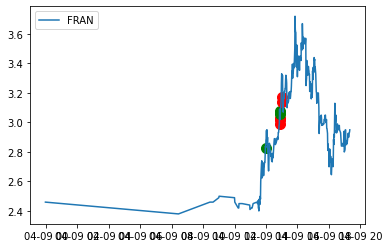

now=2020-04-09 09:55:21.200907
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:30:00-04:00  3.5100  3.5100  3.5100  3.5100    3062
2020-03-30 09:35:00-04:00  3.4000  3.4000  3.4000  3.4000     200
2020-03-30 09:39:00-04:00  3.3041  3.3041  3.3041  3.3041     611
2020-03-30 09:40:00-04:00  3.3025  3.3025  3.3025  3.3025     100
2020-03-30 09:47:00-04:00  3.3000  3.3000  3.2500  3.2500     930
...                           ...     ...     ...     ...     ...
2020-04-09 15:16:00-04:00  3.0300  3.0300  3.0300  3.0300     159
2020-04-09 15:17:00-04:00  3.0400  3.0500  3.0300  3.0300     498
2020-04-09 15:18:00-04:00  3.0450  3.0450  3.0450  3.0450     144
2020-04-09 15:20:00-04:00  3.0500  3.0600  3.0400  3.0500    1490
2020-04-09 15:21:00-04:00  3.0550  3.0550  3.0500  3.0500    1050

[2478 rows x 5 columns]
index:2231 data:3.23
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

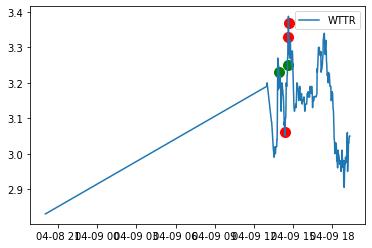

now=2020-04-09 09:49:08.310376
                             open  high    low  close  volume
timestamp                                                    
2020-03-30 09:30:00-04:00  5.0900  5.13  5.090  5.130    7089
2020-03-30 09:31:00-04:00  5.0900  5.12  5.090  5.120     706
2020-03-30 09:32:00-04:00  5.1000  5.10  5.030  5.085   51804
2020-03-30 09:33:00-04:00  5.1000  5.13  5.090  5.110    7229
2020-03-30 09:34:00-04:00  5.1400  5.14  5.030  5.030   17631
...                           ...   ...    ...    ...     ...
2020-04-09 15:17:00-04:00  4.1900  4.19  4.180  4.190    4582
2020-04-09 15:18:00-04:00  4.1864  4.19  4.180  4.185    3339
2020-04-09 15:19:00-04:00  4.1850  4.21  4.150  4.150   19611
2020-04-09 15:20:00-04:00  4.1500  4.16  4.140  4.145   26342
2020-04-09 15:21:00-04:00  4.1400  4.15  4.115  4.115    4663

[3432 rows x 5 columns]
index:3100 data:4.17
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)

local_maximas=[]
start
timestamp
2020-04-02 10:30:00-04:00    3.375
2020-04-02 10:35:00-04:00    3.410
2020-04-02 10:40:00-04:00    3.400
2020-04-02 10:45:00-04:00    3.300
2020-04-02 10:50:00-04:00    3.300
2020-04-02 10:55:00-04:00    3.290
2020-04-02 11:00:00-04:00    3.290
2020-04-02 11:05:00-04:00    3.270
2020-04-02 11:10:00-04:00    3.285
2020-04-02 11:15:00-04:00    3.265
Name: close, dtype: float64
[ 3.500e-02 -1.000e-02 -1.000e-01  0.000e+00 -1.000e-02  0.000e+00
 -2.000e-02  1.500e-02 -2.000e-02 -5.000e-03 -6.500e-02 -5.000e-03
 -1.000e-02  1.520e-02  4.900e-03  1.720e-02  2.700e-03 -3.500e-02
  5.000e-03 -4.500e-02 -5.000e-03 -5.000e-03  1.500e-02  0.000e+00
 -1.500e-02 -2.400e-03 -7.600e-03  5.000e-03 -5.000e-03  2.120e-02
  3.800e-03 -5.000e-03  5.000e-03  0.000e+00  0.000e+00 -3.500e-02
  4.900e-03 -1.490e-02 -2.500e-02 -1.500e-02 -1.000e-02 -5.000e-03
 -2.000e-02 -2.500e-02 -5.000e-03 -5.000e-02  2.500e-02  2.000e-02
 -5.000e-03 -2.000e-02 -2.000e-02  3.000e-02  0.000e+

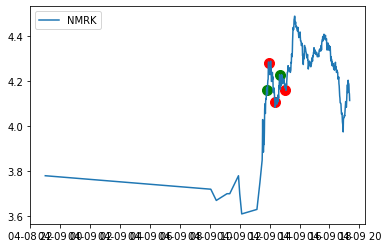

now=2020-04-09 09:57:20.380443
                            open   high    low  close  volume
timestamp                                                    
2020-03-30 09:28:00-04:00  7.200  7.200  7.200  7.200     200
2020-03-30 09:30:00-04:00  7.240  7.460  7.180  7.390    9006
2020-03-30 09:31:00-04:00  7.305  7.510  7.305  7.500     400
2020-03-30 09:33:00-04:00  7.435  7.510  7.330  7.490    2973
2020-03-30 09:34:00-04:00  7.395  7.455  7.395  7.455     955
...                          ...    ...    ...    ...     ...
2020-04-09 15:17:00-04:00  7.280  7.280  7.280  7.280     415
2020-04-09 15:18:00-04:00  7.270  7.275  7.220  7.220    4872
2020-04-09 15:19:00-04:00  7.230  7.250  7.225  7.250    1550
2020-04-09 15:20:00-04:00  7.260  7.260  7.220  7.230    4381
2020-04-09 15:21:00-04:00  7.220  7.240  7.220  7.240    4074

[3165 rows x 5 columns]
index:2848 data:7.605
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64

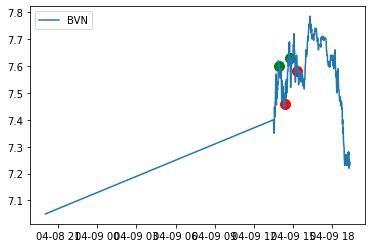

now=2020-04-09 10:34:45.781770
                             open    high   low   close    volume
timestamp                                                        
2020-03-30 04:00:00-04:00  4.6700  4.6700  4.67  4.6700    1251.0
2020-03-30 04:01:00-04:00  4.4100  4.6100  4.41  4.6100    1000.0
2020-03-30 04:03:00-04:00  4.6000  4.6000  4.60  4.6000     225.0
2020-03-30 04:05:00-04:00  4.4700  4.4700  4.47  4.4700     100.0
2020-03-30 04:07:00-04:00  4.3500  4.3500  4.35  4.3500     162.0
...                           ...     ...   ...     ...       ...
2020-04-09 15:17:00-04:00  5.8299  5.8400  5.80  5.8099   83730.0
2020-04-09 15:18:00-04:00  5.8099  5.8099  5.74  5.7568  177358.0
2020-04-09 15:19:00-04:00  5.7550  5.7700  5.73  5.7700   77092.0
2020-04-09 15:20:00-04:00  5.7800  5.7800  5.72  5.7391  128366.0
2020-04-09 15:21:00-04:00  5.7399  5.7400  5.72  5.7300  101974.0

[6183 rows x 5 columns]
index:5896 data:5.92
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

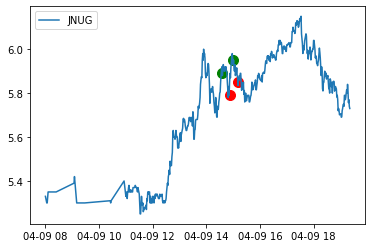

now=2020-04-09 09:57:31.323416
                            open    high    low  close  volume
timestamp                                                     
2020-03-30 09:00:00-04:00  7.030  7.0300  7.030  7.030     427
2020-03-30 09:30:00-04:00  6.980  7.0800  6.975  6.975   11341
2020-03-30 09:31:00-04:00  6.880  6.8800  6.880  6.880     100
2020-03-30 09:34:00-04:00  6.980  6.9804  6.890  6.890     500
2020-03-30 09:35:00-04:00  6.980  6.9800  6.980  6.980     172
...                          ...     ...    ...    ...     ...
2020-04-09 15:17:00-04:00  6.460  6.4600  6.445  6.450    3618
2020-04-09 15:18:00-04:00  6.450  6.4500  6.415  6.415    6714
2020-04-09 15:19:00-04:00  6.415  6.4200  6.410  6.410    4098
2020-04-09 15:20:00-04:00  6.420  6.4200  6.410  6.410    6214
2020-04-09 15:21:00-04:00  6.410  6.4100  6.395  6.400    9081

[3451 rows x 5 columns]
index:3127 data:6.7
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dty

local_maximas=[]
start
timestamp
2020-04-02 11:40:00-04:00    5.840
2020-04-02 11:45:00-04:00    5.900
2020-04-02 11:50:00-04:00    5.870
2020-04-02 11:55:00-04:00    5.920
2020-04-02 12:00:00-04:00    5.910
2020-04-02 12:05:00-04:00    5.910
2020-04-02 12:10:00-04:00    5.900
2020-04-02 12:15:00-04:00    5.880
2020-04-02 12:20:00-04:00    5.875
2020-04-02 12:25:00-04:00    5.880
Name: close, dtype: float64
[ 6.0000e-02 -3.0000e-02  5.0000e-02 -1.0000e-02  0.0000e+00 -1.0000e-02
 -2.0000e-02 -5.0000e-03  5.0000e-03 -1.0000e-02 -3.5000e-02  2.0000e-02
  0.0000e+00 -1.0000e-02 -1.0000e-02  1.0000e-02 -5.0000e-03 -4.0000e-02
 -5.0000e-03 -3.5000e-02 -4.3900e-02 -1.1100e-02  2.0000e-02 -1.0000e-02
 -5.0000e-03  1.5000e-02 -5.0000e-03 -1.5000e-02  0.0000e+00 -5.0000e-03
 -5.0000e-03 -4.5000e-02  5.0000e-03 -1.0000e-02 -1.0000e-02 -1.0000e-02
 -4.5000e-02  2.0000e-02  2.0000e-02  5.0000e-03  0.0000e+00 -5.0000e-03
 -2.5000e-02  0.0000e+00  1.0000e-02  2.5000e-02 -4.0000e-02 -1.5000e-02
  5.0

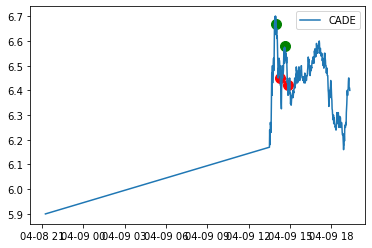

now=2020-04-09 10:17:14.879816
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:30:00-04:00  6.8000  6.8000  6.8000  6.8000    2320
2020-03-30 09:31:00-04:00  6.8200  6.8200  6.8200  6.8200    1019
2020-03-30 09:32:00-04:00  6.8654  6.8654  6.8654  6.8654     100
2020-03-30 09:33:00-04:00  6.8246  6.8800  6.8246  6.8800    1210
2020-03-30 09:34:00-04:00  6.8800  6.8800  6.8800  6.8800     104
...                           ...     ...     ...     ...     ...
2020-04-09 15:16:00-04:00  5.6000  5.6000  5.6000  5.6000     100
2020-04-09 15:17:00-04:00  5.6000  5.6000  5.6000  5.6000     205
2020-04-09 15:18:00-04:00  5.6000  5.6000  5.6000  5.6000     538
2020-04-09 15:20:00-04:00  5.5800  5.6000  5.5800  5.5800     635
2020-04-09 15:21:00-04:00  5.6000  5.6600  5.6000  5.6162    1205

[2110 rows x 5 columns]
index:1882 data:5.431
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
st

now=2020-04-09 10:49:48.564086
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:30:00-04:00  6.8000  6.8000  6.8000  6.8000    2320
2020-03-30 09:31:00-04:00  6.8200  6.8200  6.8200  6.8200    1019
2020-03-30 09:32:00-04:00  6.8654  6.8654  6.8654  6.8654     100
2020-03-30 09:33:00-04:00  6.8246  6.8800  6.8246  6.8800    1210
2020-03-30 09:34:00-04:00  6.8800  6.8800  6.8800  6.8800     104
...                           ...     ...     ...     ...     ...
2020-04-09 15:16:00-04:00  5.6000  5.6000  5.6000  5.6000     100
2020-04-09 15:17:00-04:00  5.6000  5.6000  5.6000  5.6000     205
2020-04-09 15:18:00-04:00  5.6000  5.6000  5.6000  5.6000     538
2020-04-09 15:20:00-04:00  5.5800  5.6000  5.5800  5.5800     635
2020-04-09 15:21:00-04:00  5.6000  5.6600  5.6000  5.6162    1205

[2110 rows x 5 columns]
index:1908 data:5.56
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

[ 4.000e-02 -2.000e-02  6.000e-02  1.000e-02 -4.000e-02  1.680e-02
 -3.050e-02  1.370e-02 -3.000e-02  4.000e-02 -1.000e-02  5.000e-03
 -5.500e-02  5.000e-03  5.000e-03 -6.500e-02 -3.000e-02 -1.000e-02
 -1.000e-01  5.500e-02  3.000e-02  0.000e+00  1.000e-02  0.000e+00
 -4.000e-02 -3.500e-02 -3.500e-02  1.000e-02 -5.000e-03  3.000e-02
  5.000e-03  1.500e-02  2.000e-02 -5.000e-03  5.000e-02  7.000e-02
  1.000e-04 -4.010e-02  1.000e-02 -4.000e-02 -1.000e-02  0.000e+00
 -1.500e-02 -2.500e-02  0.000e+00  9.000e-02 -1.000e-02  1.000e-02
  1.000e-01  1.612e-01 -8.120e-02 -2.620e-02  7.620e-02 -1.510e-02
 -2.490e-02  3.000e-02 -3.000e-02 -7.000e-02 -1.000e-02  3.000e-02
  5.000e-02 -8.000e-02  5.000e-03  1.500e-02 -8.020e-02  4.020e-02
  0.000e+00 -1.000e-02 -9.000e-02  0.000e+00  6.000e-02  0.000e+00
 -3.000e-02 -3.000e-02 -4.500e-02  5.000e-03  2.000e-02  1.000e-02
 -2.000e-02 -2.000e-02 -5.000e-03  1.500e-02 -2.500e-02 -3.500e-02
  0.000e+00  5.500e-02  0.000e+00  1.500e-02 -7.850e-02 -1.150

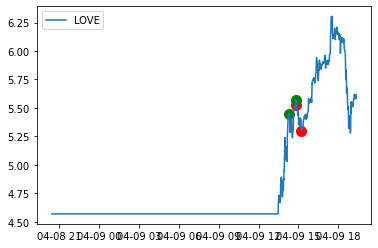

now=2020-04-09 09:50:31.391455
                              open    high     low   close   volume
timestamp                                                          
2020-03-30 07:27:00-04:00  13.0000  13.000  12.900  12.900    846.0
2020-03-30 07:28:00-04:00  12.8700  12.870  12.870  12.870    160.0
2020-03-30 07:29:00-04:00  12.9000  12.900  12.900  12.900   5000.0
2020-03-30 08:00:00-04:00  13.1299  13.130  12.850  12.850   7900.0
2020-03-30 08:04:00-04:00  12.8600  12.860  12.860  12.860    300.0
...                            ...     ...     ...     ...      ...
2020-04-09 15:17:00-04:00  12.0700  12.100  12.040  12.080  53119.0
2020-04-09 15:18:00-04:00  12.0750  12.075  12.010  12.015  39033.0
2020-04-09 15:19:00-04:00  12.0150  12.065  12.010  12.065  35776.0
2020-04-09 15:20:00-04:00  12.0700  12.100  12.055  12.055  37775.0
2020-04-09 15:21:00-04:00  12.0500  12.055  12.005  12.040  39667.0

[4159 rows x 5 columns]
index:3828 data:12.375
start
Series([], Freq: 5T, Name: clos

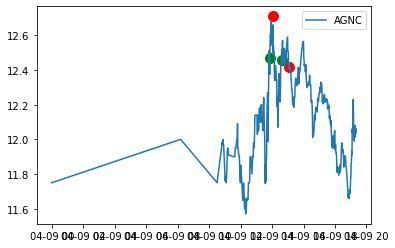

now=2020-04-09 10:00:17.431830
                             open  high   low  close  volume
timestamp                                                   
2020-03-30 09:30:00-04:00  9.5300  9.53  9.53   9.53   14298
2020-03-30 09:31:00-04:00  9.6100  9.73  9.51   9.73    1253
2020-03-30 09:32:00-04:00  9.6400  9.64  9.64   9.64     334
2020-03-30 09:33:00-04:00  9.5221  9.72  9.52   9.64    7516
2020-03-30 09:34:00-04:00  9.6400  9.64  9.54   9.54     887
...                           ...   ...   ...    ...     ...
2020-04-09 15:17:00-04:00  8.3200  8.33  8.31   8.32    1100
2020-04-09 15:18:00-04:00  8.3100  8.31  8.27   8.27    4136
2020-04-09 15:19:00-04:00  8.2600  8.26  8.24   8.24    1300
2020-04-09 15:20:00-04:00  8.2600  8.29  8.24   8.24   11851
2020-04-09 15:21:00-04:00  8.2300  8.23  8.21   8.21    2858

[3544 rows x 5 columns]
index:3225 data:8.97
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start


local_maximas=[]
start
timestamp
2020-04-02 12:45:00-04:00    7.300
2020-04-02 12:50:00-04:00    7.330
2020-04-02 12:55:00-04:00    7.330
2020-04-02 13:00:00-04:00    7.310
2020-04-02 13:05:00-04:00    7.260
2020-04-02 13:10:00-04:00    7.255
2020-04-02 13:15:00-04:00    7.255
2020-04-02 13:20:00-04:00    7.185
2020-04-02 13:25:00-04:00    7.065
2020-04-02 13:30:00-04:00    7.055
Name: close, dtype: float64
[ 3.0000e-02  0.0000e+00 -2.0000e-02 -5.0000e-02 -5.0000e-03  0.0000e+00
 -7.0000e-02 -1.2000e-01 -1.0000e-02  5.0000e-03 -9.9000e-03 -2.0100e-02
 -5.0000e-03 -1.0000e-02  0.0000e+00 -1.8500e-01 -6.0000e-04  6.0000e-04
  1.0000e-02  1.0000e-02  1.0000e-02  2.0000e-02 -2.0000e-02 -1.0000e-02
  4.0000e-02  3.0000e-02  3.5000e-02 -1.0500e-01  3.0000e-02  3.0000e-02
  1.0000e-02 -5.0000e-03  5.0000e-03  5.0000e-03 -5.0000e-03 -2.5000e-02
  1.4500e-01 -3.0000e-02 -1.1000e-01  1.6000e-01 -8.0000e-02  1.8000e-01
 -1.0000e-01 -8.0000e-02  4.0000e-02  5.0000e-02 -1.2000e-01  2.0000e-02
 -3.0

local_maximas=[10.31, 10.39]
now=2020-04-09 10:44:29.026916
                             open  high   low  close  volume
timestamp                                                   
2020-03-30 09:30:00-04:00  9.5300  9.53  9.53   9.53   14298
2020-03-30 09:31:00-04:00  9.6100  9.73  9.51   9.73    1253
2020-03-30 09:32:00-04:00  9.6400  9.64  9.64   9.64     334
2020-03-30 09:33:00-04:00  9.5221  9.72  9.52   9.64    7516
2020-03-30 09:34:00-04:00  9.6400  9.64  9.54   9.54     887
...                           ...   ...   ...    ...     ...
2020-04-09 15:17:00-04:00  8.3200  8.33  8.31   8.32    1100
2020-04-09 15:18:00-04:00  8.3100  8.31  8.27   8.27    4136
2020-04-09 15:19:00-04:00  8.2600  8.26  8.24   8.24    1300
2020-04-09 15:20:00-04:00  8.2600  8.29  8.24   8.24   11851
2020-04-09 15:21:00-04:00  8.2300  8.23  8.21   8.21    2858

[3544 rows x 5 columns]
index:3269 data:8.8996
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: clos

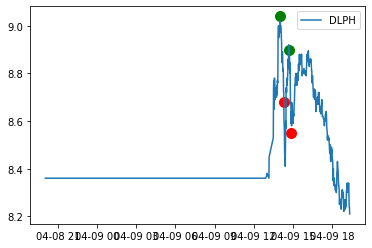

now=2020-04-09 10:00:30.995563
                             open    high   low  close  volume
timestamp                                                     
2020-03-30 09:30:00-04:00  8.3000  8.3000  8.21  8.210   19351
2020-03-30 09:31:00-04:00  8.2900  8.3000  8.29  8.300    1119
2020-03-30 09:32:00-04:00  8.2500  8.2500  8.22  8.220     303
2020-03-30 09:33:00-04:00  8.2247  8.2500  8.20  8.230    3063
2020-03-30 09:35:00-04:00  8.1719  8.1719  8.15  8.150     411
...                           ...     ...   ...    ...     ...
2020-04-09 15:17:00-04:00  9.1100  9.1550  9.11  9.150    5938
2020-04-09 15:18:00-04:00  9.1500  9.1500  9.14  9.150    2216
2020-04-09 15:19:00-04:00  9.1500  9.1600  9.15  9.160    2544
2020-04-09 15:20:00-04:00  9.1500  9.1600  9.14  9.145    5342
2020-04-09 15:21:00-04:00  9.1400  9.1450  9.11  9.110   10098

[3072 rows x 5 columns]
index:2775 data:8.51
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dt

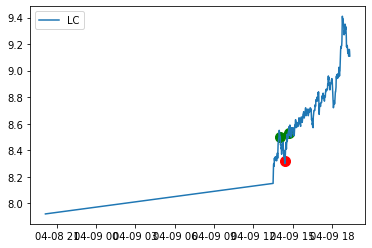

now=2020-04-09 10:30:23.242666
                             open   high     low   close  volume
timestamp                                                       
2020-03-30 07:00:00-04:00  2.3000  2.300  2.3000  2.3000    1055
2020-03-30 07:09:00-04:00  2.1700  2.170  2.1700  2.1700     400
2020-03-30 07:28:00-04:00  2.0600  2.060  2.0500  2.0500     600
2020-03-30 07:31:00-04:00  2.0500  2.050  2.0500  2.0500     300
2020-03-30 08:00:00-04:00  2.0500  2.300  2.0500  2.3000    1560
...                           ...    ...     ...     ...     ...
2020-04-09 15:17:00-04:00  3.3600  3.370  3.3500  3.3700    2486
2020-04-09 15:18:00-04:00  3.3655  3.400  3.3655  3.3701   25608
2020-04-09 15:19:00-04:00  3.3700  3.370  3.3306  3.3306   13697
2020-04-09 15:20:00-04:00  3.3307  3.350  3.2900  3.2900   13888
2020-04-09 15:21:00-04:00  3.2950  3.305  3.2800  3.3050   12191

[3894 rows x 5 columns]
index:3602 data:3.98
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([],

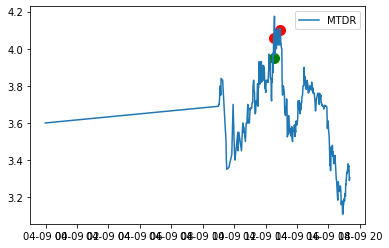

now=2020-04-09 10:31:34.793699
                            open  high   low  close    volume
timestamp                                                    
2020-03-30 04:38:00-04:00  3.500  3.50  3.50  3.500    3519.0
2020-03-30 04:49:00-04:00  3.490  3.49  3.49  3.490     150.0
2020-03-30 05:00:00-04:00  3.500  3.50  3.50  3.500     178.0
2020-03-30 06:17:00-04:00  3.610  3.61  3.61  3.610     200.0
2020-03-30 06:54:00-04:00  3.610  3.61  3.61  3.610     100.0
...                          ...   ...   ...    ...       ...
2020-04-09 15:17:00-04:00  4.050  4.06  4.04  4.055  139933.0
2020-04-09 15:18:00-04:00  4.060  4.06  4.03  4.030  156252.0
2020-04-09 15:19:00-04:00  4.039  4.04  4.01  4.010  169266.0
2020-04-09 15:20:00-04:00  4.010  4.04  4.01  4.010  144607.0
2020-04-09 15:21:00-04:00  4.010  4.02  4.00  4.000  146412.0

[5682 rows x 5 columns]
index:5392 data:4.445
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64

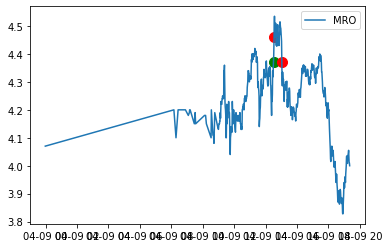

now=2020-04-09 10:30:44.338914
                            open    high    low   close   volume
timestamp                                                       
2020-03-30 07:00:00-04:00  3.280  3.2800  3.280  3.2800    946.0
2020-03-30 07:01:00-04:00  3.290  3.3900  3.290  3.3900   1294.0
2020-03-30 07:58:00-04:00  3.500  3.5000  3.500  3.5000   2160.0
2020-03-30 08:00:00-04:00  3.390  3.4401  3.390  3.4401    894.0
2020-03-30 08:02:00-04:00  3.560  3.5800  3.560  3.5800   1700.0
...                          ...     ...    ...     ...      ...
2020-04-09 15:17:00-04:00  3.795  3.8000  3.790  3.8000   8844.0
2020-04-09 15:18:00-04:00  3.790  3.7950  3.790  3.7900   1478.0
2020-04-09 15:19:00-04:00  3.790  3.7950  3.785  3.7900   8259.0
2020-04-09 15:20:00-04:00  3.790  3.8000  3.790  3.7900  17957.0
2020-04-09 15:21:00-04:00  3.790  3.7900  3.785  3.7900   1293.0

[3569 rows x 5 columns]
index:3279 data:3.845
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([]

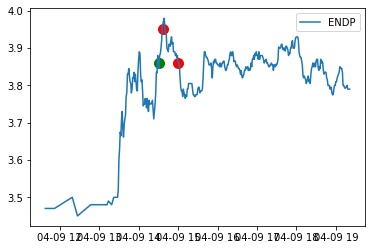

now=2020-04-09 09:55:54.572376
                             open    high    low   close  volume
timestamp                                                       
2020-03-30 09:30:00-04:00  17.490  17.740  17.49  17.520   10628
2020-03-30 09:31:00-04:00  17.740  17.835  17.50  17.835    6764
2020-03-30 09:32:00-04:00  17.790  17.900  17.70  17.780    9388
2020-03-30 09:33:00-04:00  17.720  17.735  17.44  17.735    7142
2020-03-30 09:34:00-04:00  17.735  17.800  17.66  17.725    7088
...                           ...     ...    ...     ...     ...
2020-04-09 15:17:00-04:00  16.010  16.040  16.01  16.020    2235
2020-04-09 15:18:00-04:00  16.060  16.060  16.02  16.050    1805
2020-04-09 15:19:00-04:00  16.050  16.050  16.01  16.010     881
2020-04-09 15:20:00-04:00  16.040  16.070  16.02  16.020    6497
2020-04-09 15:21:00-04:00  16.030  16.030  15.95  15.950    2414

[3437 rows x 5 columns]
index:3124 data:17.06
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([]

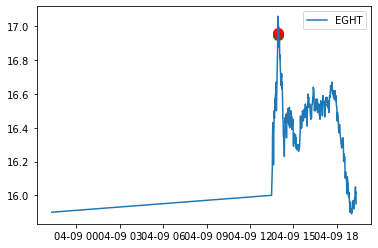

now=2020-04-09 10:46:54.336006
                            open   high    low  close  volume
timestamp                                                    
2020-03-30 09:30:00-04:00  4.180  4.300  4.180  4.300    6915
2020-03-30 09:31:00-04:00  4.229  4.229  4.190  4.190     825
2020-03-30 09:32:00-04:00  4.180  4.205  4.170  4.170     650
2020-03-30 09:33:00-04:00  4.180  4.180  4.120  4.120    1867
2020-03-30 09:34:00-04:00  4.125  4.125  4.080  4.080    2414
...                          ...    ...    ...    ...     ...
2020-04-09 15:17:00-04:00  4.930  4.940  4.930  4.935    2500
2020-04-09 15:18:00-04:00  4.940  4.950  4.940  4.950     205
2020-04-09 15:19:00-04:00  4.940  4.940  4.920  4.930    3152
2020-04-09 15:20:00-04:00  4.940  4.950  4.930  4.930     925
2020-04-09 15:21:00-04:00  4.925  4.930  4.925  4.930     276

[2762 rows x 5 columns]
index:2552 data:4.89
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
timestamp
2020-04-09 09:45:00-04:00    4.9100
202

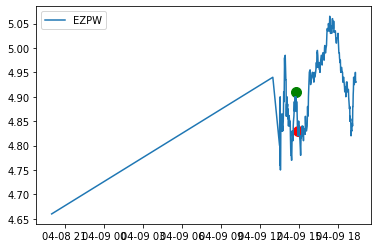

now=2020-04-09 10:29:26.425692
                            open    high   low  close  volume
timestamp                                                    
2020-03-30 09:13:00-04:00  3.020  3.0200  2.97   2.97    2226
2020-03-30 09:18:00-04:00  2.940  2.9400  2.94   2.94     100
2020-03-30 09:21:00-04:00  2.910  2.9100  2.91   2.91     479
2020-03-30 09:28:00-04:00  2.960  2.9600  2.96   2.96     492
2020-03-30 09:29:00-04:00  2.950  2.9500  2.95   2.95     100
...                          ...     ...   ...    ...     ...
2020-04-09 15:17:00-04:00  3.560  3.5600  3.55   3.55     937
2020-04-09 15:18:00-04:00  3.550  3.5550  3.55   3.55    8200
2020-04-09 15:19:00-04:00  3.555  3.5566  3.55   3.55    1950
2020-04-09 15:20:00-04:00  3.555  3.5600  3.55   3.55    8800
2020-04-09 15:21:00-04:00  3.550  3.5500  3.54   3.54    4746

[3495 rows x 5 columns]
index:3205 data:3.655
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64

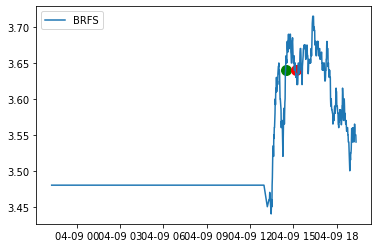

now=2020-04-09 10:38:30.844771
                            open    high    low   close  volume
timestamp                                                      
2020-03-30 07:57:00-04:00  15.77  15.770  15.77  15.770     300
2020-03-30 08:11:00-04:00  15.81  15.810  15.81  15.810     200
2020-03-30 08:18:00-04:00  15.80  15.800  15.80  15.800     175
2020-03-30 08:20:00-04:00  15.80  15.800  15.80  15.800     500
2020-03-30 08:33:00-04:00  15.61  15.610  15.61  15.610   18411
...                          ...     ...    ...     ...     ...
2020-04-09 15:17:00-04:00  16.99  16.995  16.95  16.960   24133
2020-04-09 15:18:00-04:00  16.97  16.990  16.94  16.940   23315
2020-04-09 15:19:00-04:00  16.94  16.960  16.90  16.935   21508
2020-04-09 15:20:00-04:00  16.95  16.990  16.93  16.940   18153
2020-04-09 15:21:00-04:00  16.94  16.940  16.88  16.890   14217

[3724 rows x 5 columns]
index:3441 data:17.33
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, N

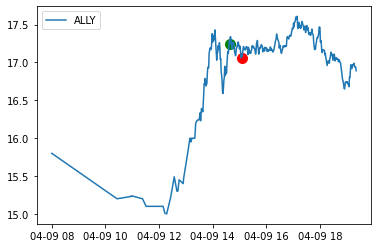

now=2020-04-09 10:30:49.572054
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 08:05:00-04:00  11.150  11.150  11.150  11.150     624
2020-03-30 09:09:00-04:00  11.190  11.190  11.190  11.190     899
2020-03-30 09:20:00-04:00  11.420  11.440  11.420  11.420     515
2020-03-30 09:30:00-04:00  11.440  11.440  11.440  11.440   36018
2020-03-30 09:32:00-04:00  11.555  11.555  11.555  11.555     624
...                           ...     ...     ...     ...     ...
2020-04-09 15:17:00-04:00  13.870  13.880  13.840  13.840    2698
2020-04-09 15:18:00-04:00  13.840  13.870  13.840  13.870    3502
2020-04-09 15:19:00-04:00  13.870  13.900  13.860  13.900    6986
2020-04-09 15:20:00-04:00  13.890  13.910  13.840  13.840   19438
2020-04-09 15:21:00-04:00  13.820  13.830  13.760  13.760   28830

[3430 rows x 5 columns]
index:3144 data:13.64
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
st

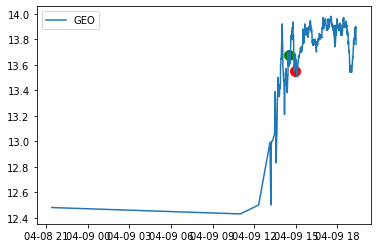

now=2020-04-09 10:35:25.021003
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 04:04:00-04:00  4.5300  4.5300  4.5300  4.5300    1000
2020-03-30 07:00:00-04:00  4.4900  4.4900  4.4900  4.4900     301
2020-03-30 07:26:00-04:00  4.5200  4.5200  4.5200  4.5200     100
2020-03-30 08:00:00-04:00  4.5200  4.5200  4.5200  4.5200    2033
2020-03-30 08:31:00-04:00  4.5000  4.5000  4.5000  4.5000     100
...                           ...     ...     ...     ...     ...
2020-04-09 15:17:00-04:00  4.5184  4.5195  4.5184  4.5195    1282
2020-04-09 15:18:00-04:00  4.5200  4.5200  4.4900  4.4900   28246
2020-04-09 15:19:00-04:00  4.4968  4.4968  4.4800  4.4900   28822
2020-04-09 15:20:00-04:00  4.4900  4.5099  4.4858  4.5050   16444
2020-04-09 15:21:00-04:00  4.5099  4.5100  4.4850  4.4850   32804

[3637 rows x 5 columns]
index:3353 data:4.59
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

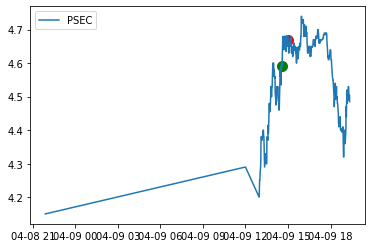

now=2020-04-09 10:37:44.031200
                            open   high    low  close  volume
timestamp                                                    
2020-03-30 04:01:00-04:00  6.000  6.000  6.000   6.00     100
2020-03-30 07:00:00-04:00  5.690  5.750  5.690   5.75     560
2020-03-30 07:54:00-04:00  5.700  5.700  5.700   5.70     550
2020-03-30 07:57:00-04:00  5.700  5.700  5.700   5.70     140
2020-03-30 08:00:00-04:00  5.980  5.980  5.980   5.98     204
...                          ...    ...    ...    ...     ...
2020-04-09 15:17:00-04:00  7.700  7.720  7.685   7.71   37689
2020-04-09 15:18:00-04:00  7.705  7.705  7.650   7.65   16894
2020-04-09 15:19:00-04:00  7.650  7.670  7.630   7.66    9787
2020-04-09 15:20:00-04:00  7.665  7.700  7.640   7.64   13195
2020-04-09 15:21:00-04:00  7.640  7.650  7.610   7.62   11874

[3916 rows x 5 columns]
index:3632 data:8.95
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)

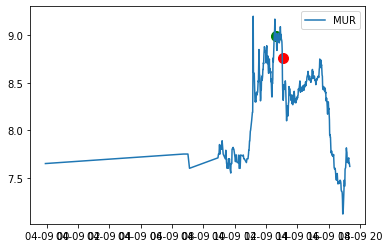

now=2020-04-09 10:38:24.806690
                            open     high     low    close  volume
timestamp                                                         
2020-03-30 08:06:00-04:00   9.36   9.3600   9.340   9.3400     465
2020-03-30 08:09:00-04:00   9.03   9.0300   9.000   9.0000    3670
2020-03-30 08:10:00-04:00   8.80   8.8000   8.800   8.8000    1600
2020-03-30 08:11:00-04:00   8.77   8.7700   8.770   8.7700    3515
2020-03-30 08:15:00-04:00   8.77   8.7700   8.500   8.5000    1700
...                          ...      ...     ...      ...     ...
2020-04-09 15:17:00-04:00  12.99  12.9911  12.990  12.9911     905
2020-04-09 15:18:00-04:00  12.98  12.9800  12.950  12.9500    4178
2020-04-09 15:19:00-04:00  12.96  12.9600  12.945  12.9600    3235
2020-04-09 15:20:00-04:00  12.97  12.9700  12.950  12.9600    2704
2020-04-09 15:21:00-04:00  12.95  12.9600  12.940  12.9600    5008

[3457 rows x 5 columns]
index:3176 data:13.67
start
Series([], Freq: 5T, Name: close, dtype: floa

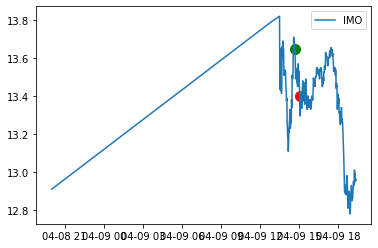

now=2020-04-09 10:51:26.017404
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 08:53:00-04:00  8.0000  8.0000  8.0000  8.0000     100
2020-03-30 09:02:00-04:00  7.9800  7.9800  7.9800  7.9800     200
2020-03-30 09:30:00-04:00  7.9500  8.0000  7.9500  8.0000    5262
2020-03-30 09:31:00-04:00  7.9500  7.9500  7.8684  7.8684     625
2020-03-30 09:32:00-04:00  7.8800  7.8925  7.8800  7.8925     315
...                           ...     ...     ...     ...     ...
2020-04-09 15:16:00-04:00  7.8345  7.8345  7.8345  7.8345     501
2020-04-09 15:17:00-04:00  7.8600  7.8950  7.8200  7.8900    4300
2020-04-09 15:18:00-04:00  7.8800  7.8900  7.8800  7.8900     750
2020-04-09 15:19:00-04:00  7.8800  7.8800  7.8800  7.8800     182
2020-04-09 15:20:00-04:00  7.8450  7.8450  7.8450  7.8450     100

[2513 rows x 5 columns]
index:2324 data:7.73
start
timestamp
2020-04-09 10:35:00-04:00    7.5299
2020-04-09 10

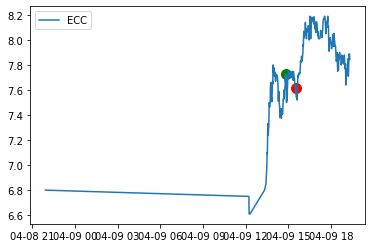

now=2020-04-09 09:54:41.142990
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 08:01:00-04:00  8.7000  8.7000  8.7000  8.7000     600
2020-03-30 08:26:00-04:00  8.6800  8.6800  8.6800  8.6800    2400
2020-03-30 08:27:00-04:00  8.6799  8.6799  8.6799  8.6799    1700
2020-03-30 08:59:00-04:00  8.6800  8.6800  8.6800  8.6800     225
2020-03-30 09:30:00-04:00  8.6400  8.6800  8.6100  8.6100   11367
...                           ...     ...     ...     ...     ...
2020-04-09 15:17:00-04:00  7.9200  7.9300  7.9200  7.9279    1270
2020-04-09 15:18:00-04:00  7.9100  7.9100  7.9100  7.9100     478
2020-04-09 15:19:00-04:00  7.9000  7.9000  7.8900  7.8900    1830
2020-04-09 15:20:00-04:00  7.9000  7.9000  7.8800  7.8900     524
2020-04-09 15:21:00-04:00  7.8800  7.8830  7.8700  7.8810     929

[3202 rows x 5 columns]
index:2908 data:8.2201
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
s

  8.00e-02  5.00e-02]
[  1   4  11  13  16  18  22  26  30  34  36  45  51  53  58  60  62  65
  67  69  71  76  81  86  89  92  99 101 105 108 112 115 119 121 124 127
 129 131 133 134 136 139 144 153 154 157 160 162 165 167 171 173 175 178
 180 181 185 187 190 192 195 196 198 199 201 203 208 211 217 221 224 227
 230 236 245 248 251 255 257 260 262 266 267 269 270 272 275 278 284 287
 290 293 295 299 301 303 304 305 307 310 319 323 324 328 335 337 342 346
 351 355 363 366 374 376 379 384 386 387 388 391]
local_maximas=[]
start
timestamp
2020-04-02 09:45:00-04:00    6.98
2020-04-02 09:50:00-04:00    7.17
2020-04-02 09:55:00-04:00    7.22
2020-04-02 10:00:00-04:00    7.35
2020-04-02 10:05:00-04:00    7.29
2020-04-02 10:10:00-04:00    7.26
2020-04-02 10:15:00-04:00    7.16
2020-04-02 10:20:00-04:00    7.22
2020-04-02 10:25:00-04:00    7.20
2020-04-02 10:30:00-04:00    7.29
Name: close, dtype: float64
[ 1.90e-01  5.00e-02  1.30e-01 -6.00e-02 -3.00e-02 -1.00e-01  6.00e-02
 -2.00e-02  9.00e-

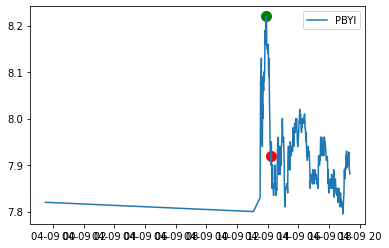

now=2020-04-09 10:46:06.724758
                            open   high    low  close   volume
timestamp                                                     
2020-03-30 08:00:00-04:00  8.630  8.630  8.630  8.630    100.0
2020-03-30 08:57:00-04:00  8.750  8.750  8.750  8.750    100.0
2020-03-30 09:29:00-04:00  8.780  8.780  8.780  8.780    500.0
2020-03-30 09:30:00-04:00  8.720  8.990  8.720  8.980  52899.0
2020-03-30 09:31:00-04:00  9.000  9.000  9.000  9.000    189.0
...                          ...    ...    ...    ...      ...
2020-04-09 15:17:00-04:00  9.290  9.310  9.290  9.310  14526.0
2020-04-09 15:18:00-04:00  9.315  9.315  9.290  9.290  20302.0
2020-04-09 15:19:00-04:00  9.290  9.310  9.280  9.305   5163.0
2020-04-09 15:20:00-04:00  9.310  9.320  9.275  9.280  12879.0
2020-04-09 15:21:00-04:00  9.280  9.280  9.220  9.220   5099.0

[3506 rows x 5 columns]
index:3230 data:9.29
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dt

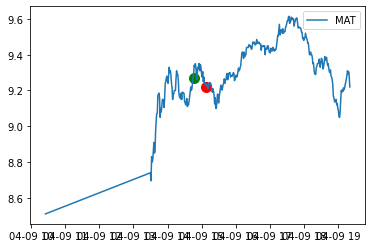

now=2020-04-09 10:34:35.299982
                              open    high      low    close  volume
timestamp                                                           
2020-03-30 07:41:00-04:00  11.4200  11.420  11.4200  11.4200     500
2020-03-30 09:30:00-04:00  11.5100  11.580  11.5100  11.5800   37565
2020-03-30 09:31:00-04:00  11.5550  11.650  11.5550  11.5906    9771
2020-03-30 09:32:00-04:00  11.6182  11.650  11.6179  11.6418    1424
2020-03-30 09:33:00-04:00  11.6000  11.605  11.4900  11.5600    3566
...                            ...     ...      ...      ...     ...
2020-04-09 15:17:00-04:00  11.3400  11.350  11.3100  11.3100    4387
2020-04-09 15:18:00-04:00  11.3100  11.310  11.2700  11.2700     633
2020-04-09 15:19:00-04:00  11.2700  11.300  11.2700  11.3000    2279
2020-04-09 15:20:00-04:00  11.3400  11.340  11.3100  11.3100    1400
2020-04-09 15:21:00-04:00  11.3100  11.320  11.2600  11.2600    1717

[3449 rows x 5 columns]
index:3174 data:11.15
start
Series([], Freq: 5T

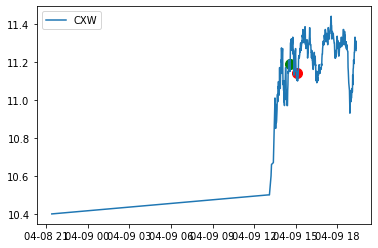

now=2020-04-09 10:48:28.660433
                             open   high     low   close  volume
timestamp                                                       
2020-03-30 09:29:00-04:00  2.7700  2.770  2.7700  2.7700     100
2020-03-30 09:30:00-04:00  2.7900  2.790  2.7800  2.7800   12962
2020-03-30 09:31:00-04:00  2.7700  2.770  2.7500  2.7500     916
2020-03-30 09:32:00-04:00  2.7400  2.740  2.7400  2.7400     600
2020-03-30 09:34:00-04:00  2.7632  2.770  2.7632  2.7700    1210
...                           ...    ...     ...     ...     ...
2020-04-09 15:17:00-04:00  3.4800  3.480  3.4765  3.4765    3002
2020-04-09 15:18:00-04:00  3.4800  3.480  3.4800  3.4800    1700
2020-04-09 15:19:00-04:00  3.4700  3.470  3.4700  3.4700    1200
2020-04-09 15:20:00-04:00  3.4700  3.475  3.4650  3.4700    6880
2020-04-09 15:21:00-04:00  3.4600  3.460  3.4600  3.4600    5408

[2614 rows x 5 columns]
index:2408 data:3.62
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
timestamp


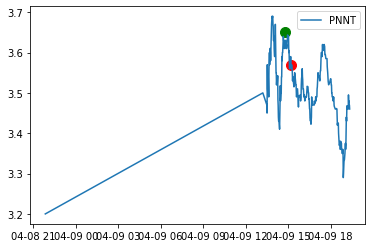

now=2020-04-09 09:49:35.863080
                             open    high    low  close  volume
timestamp                                                      
2020-03-30 07:10:00-04:00  4.1000  4.1000  4.100  4.100     230
2020-03-30 08:12:00-04:00  4.2000  4.2000  4.200  4.200     230
2020-03-30 09:17:00-04:00  4.2000  4.2000  4.200  4.200    1010
2020-03-30 09:30:00-04:00  4.2100  4.2400  4.200  4.200    6655
2020-03-30 09:32:00-04:00  4.2200  4.2200  4.220  4.220     129
...                           ...     ...    ...    ...     ...
2020-04-09 15:16:00-04:00  3.6400  3.6400  3.630  3.630     465
2020-04-09 15:17:00-04:00  3.6300  3.6400  3.630  3.640     439
2020-04-09 15:18:00-04:00  3.6500  3.6500  3.620  3.620    2664
2020-04-09 15:19:00-04:00  3.6200  3.6200  3.605  3.605   11472
2020-04-09 15:21:00-04:00  3.6176  3.6176  3.600  3.610     608

[3091 rows x 5 columns]
index:2777 data:3.95
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Na

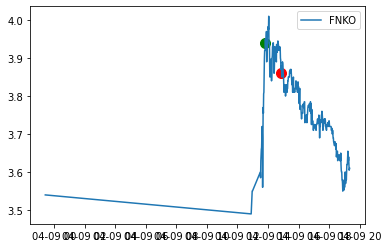

now=2020-04-09 10:36:18.737816
                            open   high   low   close  volume
timestamp                                                    
2020-03-30 04:06:00-04:00  3.710  3.710  3.70  3.7000     760
2020-03-30 04:44:00-04:00  3.700  3.700  3.70  3.7000    1000
2020-03-30 04:45:00-04:00  3.700  3.700  3.70  3.7000     240
2020-03-30 07:32:00-04:00  3.750  3.750  3.75  3.7500    1000
2020-03-30 07:49:00-04:00  3.720  3.720  3.72  3.7200     200
...                          ...    ...   ...     ...     ...
2020-04-09 15:17:00-04:00  4.565  4.590  4.56  4.5900   24952
2020-04-09 15:18:00-04:00  4.590  4.590  4.57  4.5700   33986
2020-04-09 15:19:00-04:00  4.570  4.575  4.57  4.5700   18433
2020-04-09 15:20:00-04:00  4.570  4.580  4.56  4.5600   26523
2020-04-09 15:21:00-04:00  4.565  4.570  4.56  4.5699    9740

[3977 rows x 5 columns]
index:3691 data:4.715
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64

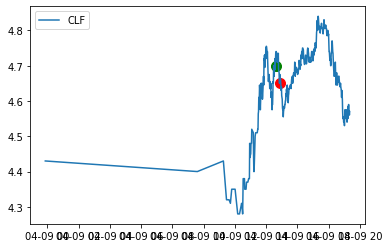

now=2020-04-09 10:41:27.839575
                            open   high    low   close  volume
timestamp                                                     
2020-03-30 08:00:00-04:00  4.740  4.740  4.740  4.7400    1000
2020-03-30 08:59:00-04:00  4.740  4.750  4.740  4.7500    3564
2020-03-30 09:00:00-04:00  4.750  4.750  4.750  4.7500     470
2020-03-30 09:04:00-04:00  4.750  4.750  4.750  4.7500     529
2020-03-30 09:06:00-04:00  4.750  4.750  4.750  4.7500     343
...                          ...    ...    ...     ...     ...
2020-04-09 15:17:00-04:00  5.595  5.610  5.570  5.6096   16360
2020-04-09 15:18:00-04:00  5.600  5.600  5.585  5.5850    5690
2020-04-09 15:19:00-04:00  5.580  5.580  5.550  5.5750    9279
2020-04-09 15:20:00-04:00  5.590  5.595  5.565  5.5650    4811
2020-04-09 15:21:00-04:00  5.565  5.565  5.525  5.5300    9124

[3595 rows x 5 columns]
index:3315 data:5.9363
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, 

  1.500e-02]
[  1   4   9  10  18  24  28  29  37  42  45  50  54  59  61  64  65  68
  71  76  77  79  80  81  82  84  85  88  89  94 100 105 108 111 115 119
 121 126 129 131 133 136 142 146 153 155 158 162 164 168 170 171 174 179
 183 184 185 186 187 188 189 191 193 199 203 205 212 214 220 224 227 228
 232 235 240 241 246 251 253 254 261 266 268 274 275 276 278 284 288 291
 298 301 305 307 311 314 316 319 323 326 332 337 339 343 345 347 352 354
 356 359 361 365 366 370 372 374 376 378 381 385 390]
local_maximas=[]
start
timestamp
2020-04-02 15:15:00-04:00    4.0696
2020-04-02 15:20:00-04:00    4.0650
2020-04-02 15:25:00-04:00    4.0700
2020-04-02 15:30:00-04:00    4.0650
2020-04-02 15:35:00-04:00    4.0650
2020-04-02 15:40:00-04:00    4.0700
2020-04-02 15:45:00-04:00    4.0999
2020-04-02 15:50:00-04:00    4.1800
2020-04-02 15:55:00-04:00    4.2000
2020-04-02 16:00:00-04:00    4.2000
Name: close, dtype: float64
[-4.600e-03  5.000e-03 -5.000e-03  0.000e+00  5.000e-03  2.990e-02
  8.010

  5.000e-02  1.500e-02]
[  4   5   7   8  12  14  20  21  27  29  35  40  41  49  55  59  60  68
  73  76  81  85  90  92  95  96  99 102 107 108 110 111 112 113 115 116
 119 120 125 131 136 139 142 146 150 152 157 160 162 164 167 173 177 184
 186 189 193 195 199 201 202 205 210 214 215 216 217 218 219 220 222 224
 230 234 236 243 245 251 255 258 259 263 266 271 272 277 282 284 285 292
 297 299 305 306 307 309 315 319 322 329 332 336 338 342 345 347 350 354
 357 363 368 370 374 376 378 383 385 387 390 392 396 397 401 403 405 407
 409 412 416 421]
local_maximas=[]
start
timestamp
2020-04-02 13:10:00-04:00    4.2100
2020-04-02 13:15:00-04:00    4.1901
2020-04-02 13:20:00-04:00    4.1950
2020-04-02 13:25:00-04:00    4.1800
2020-04-02 13:30:00-04:00    4.1102
2020-04-02 13:35:00-04:00    4.1185
2020-04-02 13:40:00-04:00    4.1099
2020-04-02 13:45:00-04:00    4.1050
2020-04-02 13:50:00-04:00    4.1050
2020-04-02 13:55:00-04:00    4.1050
Name: close, dtype: float64
[-1.990e-02  4.900e-03 -1.

 -1.490e-02 -6.500e-02  5.990e-02  4.010e-02  5.000e-02  1.500e-02]
[  1   4   7  15  17  18  20  22  27  28  33  37  43  44  46  50  52  55
  57  58  60  63  65  71  73  77  78  80  84  86  88  94 100 103 106 108
 111 113 118 123 127 128 129 134 136 139 141 143 144 145 146 148 150 152
 159 164 165 169 172 176 180 183 188 191 192 194 197 200 203 204 208 212
 213 215 216 220 222 228 229 235 237 243 248 249 257 263 267 268 276 281
 284 289 293 298 300 303 304 307 310 315 316 318 319 320 321 323 324 327
 328 333 339 344 347 350 354 358 360 365 368 370 372 375 381 385 392 394
 397 401 403 407 409 410 413 418 422 423 424 425 426 427 428 430 432 438
 442 444 451 453 459 463 466 467 471 474 479 480 485 490 492 493 500 505
 507 513 514 515 517 523 527 530 537 540 544 546 550 553 555 558 562 565
 571 576 578 582 584 586 591 593 595 598 600 604 605 609 611 613 615 617
 620 624 629]
local_maximas=[]
start
timestamp
2020-03-31 10:20:00-04:00    4.7300
2020-03-31 10:25:00-04:00    4.7100
2020-03-31

timestamp
2020-03-31 09:00:00-04:00    4.690
2020-03-31 09:10:00-04:00    4.750
2020-03-31 09:15:00-04:00    4.740
2020-03-31 09:20:00-04:00    4.740
2020-03-31 09:25:00-04:00    4.810
2020-03-31 09:30:00-04:00    4.670
2020-03-31 09:35:00-04:00    4.600
2020-03-31 09:40:00-04:00    4.650
2020-03-31 09:45:00-04:00    4.585
2020-03-31 09:50:00-04:00    4.540
Name: close, dtype: float64
[ 6.000e-02 -1.000e-02  0.000e+00  7.000e-02 -1.400e-01 -7.000e-02
  5.000e-02 -6.500e-02 -4.500e-02  7.000e-02  8.000e-02  1.990e-02
  6.020e-02 -1.510e-02 -1.500e-02 -3.000e-02  1.500e-02 -2.500e-02
 -2.000e-02 -4.000e-02 -4.990e-02 -2.010e-02 -4.000e-02  4.000e-02
  5.000e-02  0.000e+00 -9.500e-02  1.500e-02 -1.000e-02 -2.000e-02
  4.000e-02 -2.000e-02 -2.000e-02  1.500e-02 -1.000e-02 -3.500e-02
 -1.000e-04 -1.990e-02 -6.000e-02 -3.010e-02  1.000e-02  5.000e-02
 -1.990e-02  1.000e-02  0.000e+00 -4.000e-02  0.000e+00 -2.000e-02
  0.000e+00 -3.000e-02 -1.010e-02 -4.360e-02  3.870e-02  2.500e-02
  0.000e+

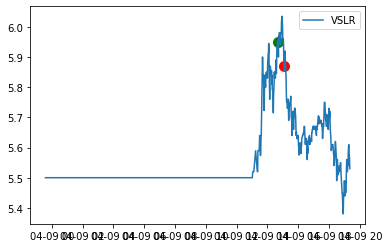

now=2020-04-09 10:28:27.044733
                           open   high    low  close  volume
timestamp                                                   
2020-03-30 09:30:00-04:00  6.70  6.720  6.700  6.720    6591
2020-03-30 09:32:00-04:00  6.63  6.730  6.630  6.690    1001
2020-03-30 09:33:00-04:00  6.71  6.760  6.710  6.760    4307
2020-03-30 09:34:00-04:00  6.75  6.870  6.740  6.830   18890
2020-03-30 09:35:00-04:00  6.84  7.030  6.840  6.910   36323
...                         ...    ...    ...    ...     ...
2020-04-09 15:17:00-04:00  7.20  7.220  7.200  7.205   35678
2020-04-09 15:18:00-04:00  7.20  7.205  7.190  7.195    2865
2020-04-09 15:19:00-04:00  7.19  7.195  7.185  7.190    2991
2020-04-09 15:20:00-04:00  7.19  7.200  7.170  7.170   13426
2020-04-09 15:21:00-04:00  7.18  7.180  7.165  7.170    2139

[3456 rows x 5 columns]
index:3164 data:7.02
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start


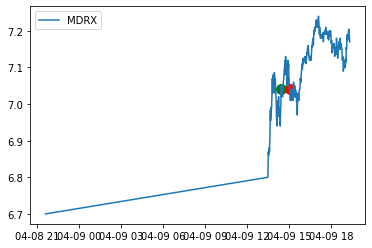

now=2020-04-09 11:00:47.561806
                             open    high     low   close   volume
timestamp                                                         
2020-03-30 08:03:00-04:00  2.2300  2.2300  2.2300  2.2300   1000.0
2020-03-30 08:04:00-04:00  2.2300  2.2300  2.2300  2.2300    500.0
2020-03-30 08:05:00-04:00  2.2300  2.2300  2.2300  2.2300    500.0
2020-03-30 08:29:00-04:00  2.2400  2.2400  2.2400  2.2400    475.0
2020-03-30 08:37:00-04:00  2.4000  2.4000  2.4000  2.4000    200.0
...                           ...     ...     ...     ...      ...
2020-04-09 15:17:00-04:00  2.2600  2.2700  2.2600  2.2700  13197.0
2020-04-09 15:18:00-04:00  2.2700  2.2700  2.2300  2.2300  49297.0
2020-04-09 15:19:00-04:00  2.2300  2.2372  2.2300  2.2326   3532.0
2020-04-09 15:20:00-04:00  2.2351  2.2400  2.2200  2.2350  48149.0
2020-04-09 15:21:00-04:00  2.2378  2.2550  2.2378  2.2500  17097.0

[3727 rows x 5 columns]
index:3466 data:2.285
start
Series([], Freq: 5T, Name: close, dtype: floa

  3.020e-02 -3.800e-03]
[  2   7  14  18  20  25  27  28  31  37  38  39  40  41  42  44  46  49
  51  52  53  54  56  58  59  63  66  71  77  78  84  86  92  95  99 101
 102 103 104 111 114 116 118 125 131 132 135 137 138 141 144 146 148 150
 152 153 156 158 161 162 165 172 176 179 183 185 187 192 195 197 201 208
 214 215 219 224 225 226 230 233 239 242 244 246 247 248 249 250 252 253
 255 257 259 261 263 267 271 275 278 281 285 288 292 294 302 304 309 315
 319 322 327 330 335 336 339 344 345 346 347 353 355 356 358 361 364 366
 368 370 377 382 387 389 394 397]
local_maximas=[]
start
timestamp
2020-04-03 10:45:00-04:00    1.440
2020-04-03 10:50:00-04:00    1.440
2020-04-03 10:55:00-04:00    1.440
2020-04-03 11:00:00-04:00    1.440
2020-04-03 11:05:00-04:00    1.440
2020-04-03 11:10:00-04:00    1.440
2020-04-03 11:15:00-04:00    1.435
2020-04-03 11:20:00-04:00    1.425
2020-04-03 11:25:00-04:00    1.405
2020-04-03 11:30:00-04:00    1.390
Name: close, dtype: float64
[ 0.000e+00  0.000e+

local_maximas=[]
start
timestamp
2020-03-31 14:10:00-04:00    1.655
2020-03-31 14:15:00-04:00    1.660
2020-03-31 14:20:00-04:00    1.660
2020-03-31 14:25:00-04:00    1.655
2020-03-31 14:30:00-04:00    1.655
2020-03-31 14:35:00-04:00    1.655
2020-03-31 14:40:00-04:00    1.750
2020-03-31 14:45:00-04:00    1.755
2020-03-31 14:50:00-04:00    1.735
2020-03-31 14:55:00-04:00    1.725
Name: close, dtype: float64
[ 5.000e-03  0.000e+00 -5.000e-03  0.000e+00  0.000e+00  9.500e-02
  5.000e-03 -2.000e-02 -1.000e-02  5.000e-03  1.000e-02  0.000e+00
  0.000e+00 -3.000e-02 -5.000e-03  0.000e+00  0.000e+00 -2.000e-02
  0.000e+00  4.500e-02 -1.000e-04  1.010e-02  1.000e-02 -8.000e-02
  8.000e-02 -1.400e-01  0.000e+00  3.990e-02 -4.990e-02  0.000e+00
  0.000e+00  4.000e-02 -4.000e-02  2.000e-02  1.880e-02 -5.880e-02
 -5.000e-03 -1.000e-02  2.500e-02  1.000e-02  1.500e-02 -4.500e-02
 -1.010e-02 -9.900e-03 -5.000e-03 -1.500e-02 -2.520e-02 -1.480e-02
 -5.000e-03  5.000e-03  0.000e+00  0.000e+00 -3.200e-

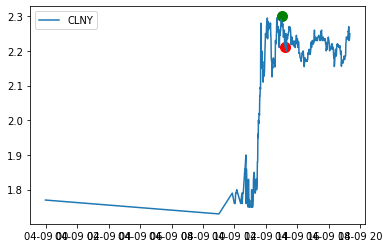

now=2020-04-09 10:04:23.957503
                            open   high    low  close  volume
timestamp                                                    
2020-03-30 09:30:00-04:00  6.710  6.710  6.710  6.710    1490
2020-03-30 09:33:00-04:00  6.695  6.695  6.695  6.695     200
2020-03-30 09:38:00-04:00  6.680  6.680  6.680  6.680     373
2020-03-30 09:39:00-04:00  6.730  6.730  6.730  6.730     100
2020-03-30 09:40:00-04:00  6.700  6.755  6.700  6.725    1735
...                          ...    ...    ...    ...     ...
2020-04-09 15:17:00-04:00  8.780  8.780  8.770  8.770     818
2020-04-09 15:18:00-04:00  8.780  8.780  8.770  8.770     504
2020-04-09 15:19:00-04:00  8.770  8.770  8.750  8.750    3720
2020-04-09 15:20:00-04:00  8.755  8.795  8.750  8.785   36926
2020-04-09 15:21:00-04:00  8.785  8.785  8.750  8.765    6414

[2658 rows x 5 columns]
index:2387 data:8.5
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)


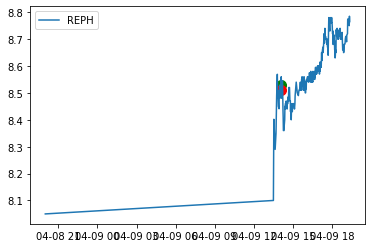

now=2020-04-09 10:45:17.716045
                            open   high    low   close  volume
timestamp                                                     
2020-03-30 04:04:00-04:00  10.99  11.07  10.99  11.070    1902
2020-03-30 04:05:00-04:00  11.06  11.06  11.06  11.060    1000
2020-03-30 04:06:00-04:00  11.18  11.18  11.18  11.180     700
2020-03-30 04:07:00-04:00  11.23  11.23  11.23  11.230     500
2020-03-30 04:08:00-04:00  11.22  11.31  11.22  11.310    3000
...                          ...    ...    ...     ...     ...
2020-04-09 15:17:00-04:00  11.55  11.59  11.55  11.570    5021
2020-04-09 15:18:00-04:00  11.59  11.59  11.48  11.500    4587
2020-04-09 15:19:00-04:00  11.50  11.51  11.46  11.480   12013
2020-04-09 15:20:00-04:00  11.50  11.58  11.48  11.530   21428
2020-04-09 15:21:00-04:00  11.54  11.55  11.46  11.505   49845

[4417 rows x 5 columns]
index:4141 data:12.38
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, d

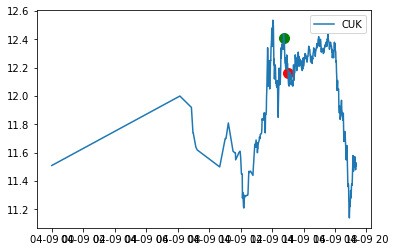

now=2020-04-09 10:41:08.288102
                             open   high    low  close  volume
timestamp                                                     
2020-03-30 09:29:00-04:00  11.310  11.31  11.31  11.31     300
2020-03-30 09:30:00-04:00  11.380  11.38  11.38  11.38    8804
2020-03-30 09:32:00-04:00  11.320  11.32  11.32  11.32     106
2020-03-30 09:36:00-04:00  11.270  11.31  11.27  11.29    2347
2020-03-30 09:37:00-04:00  11.240  11.26  11.20  11.20    4412
...                           ...    ...    ...    ...     ...
2020-04-09 15:17:00-04:00  12.360  12.37  12.36  12.37    2031
2020-04-09 15:18:00-04:00  12.360  12.36  12.33  12.33    2224
2020-04-09 15:19:00-04:00  12.330  12.34  12.32  12.34    1418
2020-04-09 15:20:00-04:00  12.350  12.39  12.35  12.35    3226
2020-04-09 15:21:00-04:00  12.355  12.36  12.33  12.35    1580

[3433 rows x 5 columns]
index:3155 data:12.065
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, 

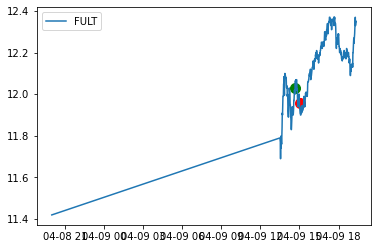

now=2020-04-09 10:39:10.400904
                             open   high     low   close  volume
timestamp                                                       
2020-03-30 09:28:00-04:00  12.590  12.59  12.590  12.590     100
2020-03-30 09:30:00-04:00  12.580  12.58  12.580  12.580   19340
2020-03-30 09:31:00-04:00  12.520  12.78  12.520  12.780     392
2020-03-30 09:32:00-04:00  12.770  12.78  12.600  12.780     682
2020-03-30 09:33:00-04:00  12.720  12.78  12.560  12.560    3112
...                           ...    ...     ...     ...     ...
2020-04-09 15:17:00-04:00  12.200  12.27  12.190  12.235    4028
2020-04-09 15:18:00-04:00  12.235  12.25  12.195  12.210    7709
2020-04-09 15:19:00-04:00  12.190  12.21  12.140  12.140   15714
2020-04-09 15:20:00-04:00  12.140  12.20  12.135  12.190    8252
2020-04-09 15:21:00-04:00  12.210  12.23  12.200  12.220    3539

[3293 rows x 5 columns]
index:3010 data:12.45
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([]

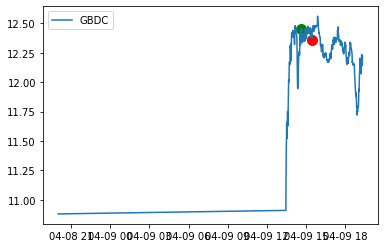

now=2020-04-09 10:51:48.407757
                           open    high    low  close  volume
timestamp                                                    
2020-03-30 07:01:00-04:00  4.56  4.5600  4.560   4.56     500
2020-03-30 09:30:00-04:00  5.70  5.9100  5.700   5.91    4734
2020-03-30 09:33:00-04:00  5.74  5.8493  5.710   5.71    1411
2020-03-30 09:36:00-04:00  5.70  5.7000  5.700   5.70     377
2020-03-30 09:37:00-04:00  5.70  5.7000  5.680   5.68    1922
...                         ...     ...    ...    ...     ...
2020-04-09 15:17:00-04:00  6.59  6.6000  6.580   6.59    4446
2020-04-09 15:18:00-04:00  6.61  6.6600  6.610   6.64    5530
2020-04-09 15:19:00-04:00  6.62  6.6200  6.580   6.58    1422
2020-04-09 15:20:00-04:00  6.61  6.6200  6.595   6.61    2706
2020-04-09 15:21:00-04:00  6.60  6.6000  6.570   6.59    3202

[2485 rows x 5 columns]
index:2264 data:6.04
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
timestamp
2020-04-09 10:05:00-04:00    6.13
2020-

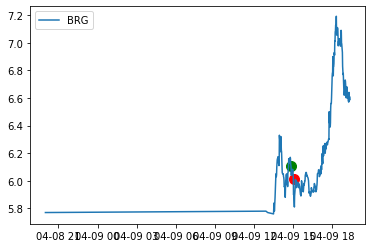

now=2020-04-09 10:33:48.723928
                             open     high    low  close  volume
timestamp                                                       
2020-03-30 07:41:00-04:00  11.510  11.5100  11.51  11.51     705
2020-03-30 07:50:00-04:00  11.500  11.5000  11.50  11.50     725
2020-03-30 08:02:00-04:00  11.500  11.5000  11.50  11.50     375
2020-03-30 08:18:00-04:00  11.350  11.3500  11.35  11.35     130
2020-03-30 08:37:00-04:00  10.050  10.0500  10.05  10.05    8162
...                           ...      ...    ...    ...     ...
2020-04-09 15:17:00-04:00   9.759   9.7800   9.74   9.78    1672
2020-04-09 15:18:00-04:00   9.760   9.7600   9.69   9.69    8706
2020-04-09 15:19:00-04:00   9.690   9.6916   9.67   9.69    3897
2020-04-09 15:20:00-04:00   9.690   9.6903   9.66   9.66    1860
2020-04-09 15:21:00-04:00   9.650   9.6500   9.61   9.63    2938

[3452 rows x 5 columns]
index:3168 data:10.38
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([]

local_maximas=[]
start
timestamp
2020-04-02 15:05:00-04:00    8.260
2020-04-02 15:10:00-04:00    8.330
2020-04-02 15:15:00-04:00    8.340
2020-04-02 15:20:00-04:00    8.330
2020-04-02 15:25:00-04:00    8.320
2020-04-02 15:30:00-04:00    8.330
2020-04-02 15:35:00-04:00    8.270
2020-04-02 15:40:00-04:00    8.310
2020-04-02 15:45:00-04:00    8.330
2020-04-02 15:50:00-04:00    8.367
Name: close, dtype: float64
[ 7.000e-02  1.000e-02 -1.000e-02 -1.000e-02  1.000e-02 -6.000e-02
  4.000e-02  2.000e-02  3.700e-02  9.710e-02 -5.410e-02  0.000e+00
 -1.000e-02 -4.900e-01  1.100e-01 -6.000e-02  7.000e-02 -2.000e-02
  1.100e-01 -8.000e-02 -9.000e-02  4.000e-02 -1.000e-02 -3.000e-02
 -2.000e-02 -2.000e-02 -4.000e-02 -5.000e-02 -7.000e-02  3.000e-02
  1.000e-02  1.000e-02 -1.000e-02 -3.500e-02  3.500e-02  2.000e-02
 -6.000e-02 -4.000e-02  0.000e+00 -4.000e-02 -1.000e-02 -3.000e-02
 -2.000e-02 -3.000e-02 -2.000e-02  7.990e-02 -3.990e-02 -9.000e-02
 -6.000e-02 -8.000e-02  6.000e-02  8.000e-02  8.000e-

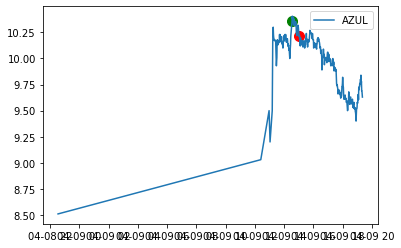

now=2020-04-09 09:58:08.118734
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 04:04:00-04:00  8.3300  8.3300  8.3300  8.3300   100.0
2020-03-30 04:05:00-04:00  8.3400  8.3400  8.3400  8.3400   900.0
2020-03-30 04:09:00-04:00  8.3000  8.3000  8.3000  8.3000   100.0
2020-03-30 04:18:00-04:00  8.3500  8.3500  8.3500  8.3500  2000.0
2020-03-30 05:13:00-04:00  8.3600  8.3600  8.3500  8.3500  4100.0
...                           ...     ...     ...     ...     ...
2020-04-09 15:17:00-04:00  9.0200  9.0200  9.0100  9.0100  1148.0
2020-04-09 15:18:00-04:00  9.0000  9.0074  8.9800  9.0074  4762.0
2020-04-09 15:19:00-04:00  8.9900  8.9900  8.9600  8.9883  2630.0
2020-04-09 15:20:00-04:00  8.9701  9.0000  8.9701  8.9900  2282.0
2020-04-09 15:21:00-04:00  8.9999  8.9999  8.9500  8.9500  1842.0

[3623 rows x 5 columns]
index:3303 data:9.67
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

local_maximas=[]
start
timestamp
2020-04-03 11:25:00-04:00    5.7650
2020-04-03 11:30:00-04:00    5.7650
2020-04-03 11:35:00-04:00    5.9174
2020-04-03 11:40:00-04:00    5.9136
2020-04-03 11:45:00-04:00    5.9700
2020-04-03 11:50:00-04:00    5.9214
2020-04-03 11:55:00-04:00    5.8900
2020-04-03 12:00:00-04:00    5.8600
2020-04-03 12:05:00-04:00    5.8450
2020-04-03 12:10:00-04:00    5.8200
Name: close, dtype: float64
[ 0.      0.1524 -0.0038  0.0564 -0.0486 -0.0314 -0.03   -0.015  -0.025
 -0.01    0.04   -0.01    0.03   -0.0775  0.0473 -0.0048 -0.095  -0.025
 -0.05   -0.05    0.      0.0251  0.0698 -0.0499 -0.035  -0.08    0.035
  0.0399 -0.04    0.0101  0.035   0.0409 -0.016  -0.0499  0.065   0.0269
  0.0328  0.0654 -0.0851 -0.04    0.075   0.035  -0.005   0.025   0.095
  0.      0.055  -0.045  -0.14   -0.075   0.025   0.1     0.015   0.045
  0.03    0.05    0.02    0.11    0.07    0.      0.     -0.05   -0.2
  0.      0.     -0.01    0.      0.76    0.01    0.     -0.06    0.07
  0. 

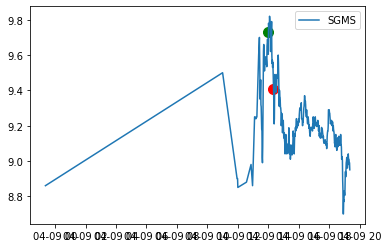

now=2020-04-09 10:36:24.563995
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:16:00-04:00  6.9500  6.9500  6.9500  6.9500    1000
2020-03-30 09:30:00-04:00  7.0000  7.3724  7.0000  7.3724    8611
2020-03-30 09:31:00-04:00  7.0200  7.0200  7.0200  7.0200     188
2020-03-30 09:32:00-04:00  6.9900  7.0000  6.9500  7.0000    2666
2020-03-30 09:33:00-04:00  7.0250  7.0250  6.9950  6.9950     981
...                           ...     ...     ...     ...     ...
2020-04-09 15:17:00-04:00  7.6700  7.6700  7.6500  7.6500    2255
2020-04-09 15:18:00-04:00  7.6300  7.6300  7.5800  7.5800    1252
2020-04-09 15:19:00-04:00  7.6353  7.6400  7.5800  7.5800    2963
2020-04-09 15:20:00-04:00  7.5950  7.6100  7.5834  7.6100    1950
2020-04-09 15:21:00-04:00  7.6150  7.6150  7.6150  7.6150     546

[3200 rows x 5 columns]
index:2928 data:7.355
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
st

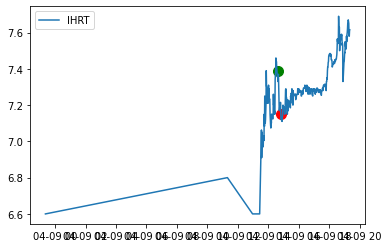

now=2020-04-09 10:41:23.920224
                           open    high    low  close  volume
timestamp                                                    
2020-03-30 07:00:00-04:00  9.25  9.2500  9.250  9.250     614
2020-03-30 07:09:00-04:00  9.25  9.2500  9.250  9.250     100
2020-03-30 07:34:00-04:00  9.30  9.3000  9.300  9.300     200
2020-03-30 07:36:00-04:00  9.25  9.2500  9.250  9.250     286
2020-03-30 08:17:00-04:00  9.26  9.2600  9.260  9.260     272
...                         ...     ...    ...    ...     ...
2020-04-09 15:17:00-04:00  9.82  9.8350  9.820  9.830   11712
2020-04-09 15:18:00-04:00  9.83  9.8400  9.820  9.820   44838
2020-04-09 15:19:00-04:00  9.82  9.8329  9.820  9.830   27804
2020-04-09 15:20:00-04:00  9.84  9.8750  9.835  9.855   56390
2020-04-09 15:21:00-04:00  9.85  9.8600  9.850  9.860   53358

[3553 rows x 5 columns]
index:3272 data:10.195
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float6

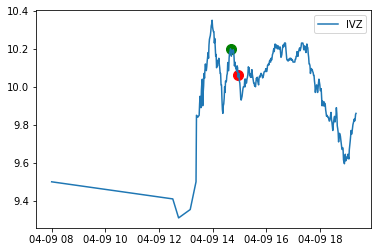

now=2020-04-09 10:50:39.306448
                            open   high    low  close  volume
timestamp                                                    
2020-03-30 04:04:00-04:00  6.340  6.340  6.340  6.340     500
2020-03-30 07:09:00-04:00  6.250  6.250  6.250  6.250     350
2020-03-30 07:40:00-04:00  6.200  6.200  6.200  6.200     200
2020-03-30 08:00:00-04:00  6.150  6.150  6.150  6.150     100
2020-03-30 08:07:00-04:00  6.250  6.250  6.250  6.250     848
...                          ...    ...    ...    ...     ...
2020-04-09 15:17:00-04:00  5.695  5.705  5.695  5.705    8008
2020-04-09 15:18:00-04:00  5.700  5.705  5.695  5.695    7800
2020-04-09 15:19:00-04:00  5.695  5.700  5.690  5.690   11138
2020-04-09 15:20:00-04:00  5.695  5.695  5.690  5.690    5854
2020-04-09 15:21:00-04:00  5.695  5.695  5.670  5.675   15690

[3579 rows x 5 columns]
index:3309 data:5.866
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64

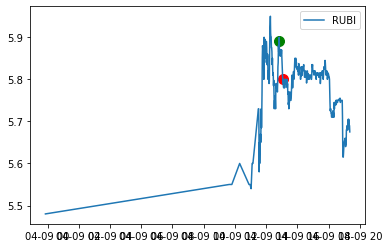

now=2020-04-09 10:43:40.121062
                            open   high     low  close  volume
timestamp                                                     
2020-03-30 09:30:00-04:00  8.850  8.990  8.8100  8.830   48439
2020-03-30 09:31:00-04:00  8.845  8.845  8.8411  8.845     368
2020-03-30 09:32:00-04:00  8.850  8.920  8.8500  8.910    1889
2020-03-30 09:33:00-04:00  8.885  8.885  8.7900  8.795    2929
2020-03-30 09:34:00-04:00  8.795  8.830  8.7880  8.788    2733
...                          ...    ...     ...    ...     ...
2020-04-09 15:17:00-04:00  8.530  8.550  8.5300  8.540    1673
2020-04-09 15:18:00-04:00  8.550  8.550  8.5200  8.520    4887
2020-04-09 15:19:00-04:00  8.520  8.530  8.5150  8.520    3801
2020-04-09 15:20:00-04:00  8.530  8.545  8.5300  8.530    2290
2020-04-09 15:21:00-04:00  8.535  8.540  8.5300  8.530     802

[3450 rows x 5 columns]
index:3172 data:8.52
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dt

timestamp
2020-04-02 13:20:00-04:00    8.3650
2020-04-02 13:25:00-04:00    8.3409
2020-04-02 13:30:00-04:00    8.3500
2020-04-02 13:35:00-04:00    8.3600
2020-04-02 13:40:00-04:00    8.3800
2020-04-02 13:45:00-04:00    8.3800
2020-04-02 13:50:00-04:00    8.4100
2020-04-02 13:55:00-04:00    8.4000
2020-04-02 14:00:00-04:00    8.3800
2020-04-02 14:05:00-04:00    8.3600
Name: close, dtype: float64
[-0.0241  0.0091  0.01    0.02    0.      0.03   -0.01   -0.02   -0.02
 -0.01   -0.005  -0.075   0.055   0.005   0.02   -0.0175 -0.0425  0.06
 -0.03    0.005  -0.035   0.03    0.02    0.     -0.02   -0.015  -0.045
  0.045   0.005   0.09    0.02   -0.02   -0.02    0.     -0.05    0.06
 -0.07   -0.05    0.05   -0.0596 -0.1004  0.1     0.     -0.07    0.016
 -0.106  -0.02   -0.03   -0.01   -0.13   -0.01   -0.01   -0.053  -0.027
  0.005  -0.015  -0.0399 -0.0151 -0.08   -0.025   0.02   -0.055  -0.045
 -0.02   -0.005  -0.02   -0.02   -0.065   0.03    0.02   -0.02   -0.015
  0.03    0.025  -0.04    0. 

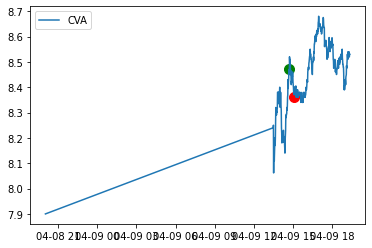

now=2020-04-09 10:46:02.460119
                            open    high    low  close  volume
timestamp                                                     
2020-03-30 09:12:00-04:00  7.160  7.1600  7.160  7.160     100
2020-03-30 09:30:00-04:00  7.100  7.1041  6.860  6.880   64888
2020-03-30 09:31:00-04:00  6.860  6.8700  6.610  6.630   48636
2020-03-30 09:32:00-04:00  6.640  6.6400  6.550  6.555   38930
2020-03-30 09:33:00-04:00  6.555  6.5650  6.480  6.500   20766
...                          ...     ...    ...    ...     ...
2020-04-09 15:17:00-04:00  8.465  8.4700  8.450  8.455    9875
2020-04-09 15:18:00-04:00  8.450  8.4550  8.440  8.440   44570
2020-04-09 15:19:00-04:00  8.440  8.4500  8.440  8.450    4877
2020-04-09 15:20:00-04:00  8.450  8.4600  8.445  8.450   39103
2020-04-09 15:21:00-04:00  8.450  8.4650  8.450  8.450   12036

[3459 rows x 5 columns]
index:3185 data:8.29
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dt

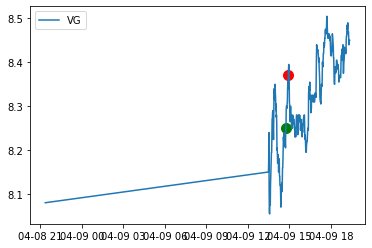

now=2020-04-09 09:56:17.030422
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:30:00-04:00  3.0800  3.0800  3.0800  3.0800     307
2020-03-30 09:34:00-04:00  3.1000  3.1550  3.1000  3.1000    1522
2020-03-30 09:35:00-04:00  3.1700  3.3300  3.1200  3.1200     891
2020-03-30 09:36:00-04:00  3.1428  3.1428  3.1428  3.1428     188
2020-03-30 09:46:00-04:00  3.1400  3.1400  3.1400  3.1400     360
...                           ...     ...     ...     ...     ...
2020-04-09 15:11:00-04:00  2.7150  2.7400  2.7000  2.7000    1475
2020-04-09 15:13:00-04:00  2.7252  2.7252  2.7252  2.7252     500
2020-04-09 15:18:00-04:00  2.7450  2.7450  2.7450  2.7450     239
2020-04-09 15:19:00-04:00  2.7450  2.7900  2.7450  2.7500    2757
2020-04-09 15:20:00-04:00  2.7400  2.7400  2.7400  2.7400     269

[1040 rows x 5 columns]
index:939 data:2.84
start
timestamp
2020-04-08 12:35:00-04:00    2.7301
2020-04-08 12:

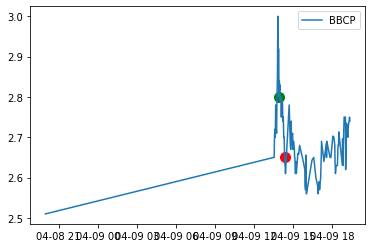

now=2020-04-09 09:50:37.617775
                            open   high     low  close   volume
timestamp                                                      
2020-03-30 07:45:00-04:00  5.500  5.500  5.5000  5.500    200.0
2020-03-30 08:16:00-04:00  5.370  5.370  5.3700  5.370    200.0
2020-03-30 08:46:00-04:00  5.370  5.370  5.2500  5.250   5000.0
2020-03-30 09:30:00-04:00  5.270  5.330  5.2700  5.330  22153.0
2020-03-30 09:32:00-04:00  5.400  5.410  5.4000  5.410   1856.0
...                          ...    ...     ...    ...      ...
2020-04-09 15:17:00-04:00  5.765  5.780  5.7650  5.780   2800.0
2020-04-09 15:18:00-04:00  5.780  5.780  5.7500  5.755   5890.0
2020-04-09 15:19:00-04:00  5.750  5.750  5.7200  5.730   7470.0
2020-04-09 15:20:00-04:00  5.735  5.750  5.7301  5.740   5712.0
2020-04-09 15:21:00-04:00  5.740  5.745  5.7300  5.740   2586.0

[3423 rows x 5 columns]
index:3098 data:5.74
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Na

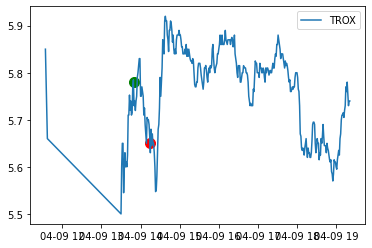

now=2020-04-09 09:55:00.710957
                           open    high   low  close  volume
timestamp                                                   
2020-03-30 08:56:00-04:00  5.25  5.2500  5.25   5.25     150
2020-03-30 09:13:00-04:00  5.30  5.3000  5.30   5.30     100
2020-03-30 09:15:00-04:00  5.30  5.3000  5.30   5.30     505
2020-03-30 09:18:00-04:00  5.25  5.2500  5.25   5.25     436
2020-03-30 09:20:00-04:00  5.30  5.3000  5.30   5.30     436
...                         ...     ...   ...    ...     ...
2020-04-09 15:16:00-04:00  5.12  5.1500  5.10   5.10    4568
2020-04-09 15:17:00-04:00  5.12  5.1300  5.11   5.12    2960
2020-04-09 15:19:00-04:00  5.13  5.1428  5.11   5.13    1099
2020-04-09 15:20:00-04:00  5.15  5.1500  5.12   5.12     339
2020-04-09 15:21:00-04:00  5.13  5.1300  5.11   5.12     710

[2823 rows x 5 columns]
index:2585 data:5.0627
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
timestamp
2020-04-09 09:30:00-04:00    4.7999
2020-04-09 09:

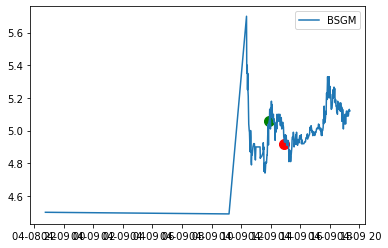

now=2020-04-09 10:43:05.219719
                             open   high     low  close  volume
timestamp                                                      
2020-03-30 08:53:00-04:00  3.7600  3.760  3.7600   3.76     550
2020-03-30 09:29:00-04:00  3.7500  3.750  3.7500   3.75     600
2020-03-30 09:30:00-04:00  3.6800  3.710  3.6800   3.69   14669
2020-03-30 09:31:00-04:00  3.7000  3.700  3.6700   3.67     533
2020-03-30 09:32:00-04:00  3.6917  3.750  3.6917   3.75    1794
...                           ...    ...     ...    ...     ...
2020-04-09 15:17:00-04:00  4.1200  4.120  4.1100   4.11    2530
2020-04-09 15:18:00-04:00  4.1050  4.105  4.1000   4.10    1005
2020-04-09 15:19:00-04:00  4.1000  4.100  4.0950   4.10     300
2020-04-09 15:20:00-04:00  4.1000  4.110  4.0900   4.09    5681
2020-04-09 15:21:00-04:00  4.0850  4.090  4.0800   4.09    1638

[3046 rows x 5 columns]
index:2789 data:4.2373
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
timestamp
2020-04-09 

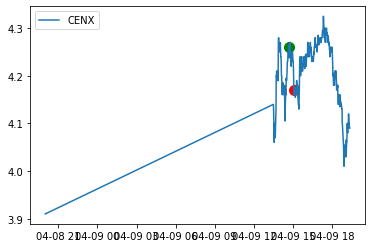

now=2020-04-09 10:45:56.387850
                             open     high      low    close  volume
timestamp                                                           
2020-03-30 08:02:00-04:00   9.500   9.5000   9.5000   9.5000     100
2020-03-30 09:30:00-04:00   9.430   9.4524   9.3100   9.3100   17457
2020-03-30 09:31:00-04:00   9.310   9.3300   9.1200   9.1200    3274
2020-03-30 09:32:00-04:00   9.130   9.1300   9.1219   9.1250    1112
2020-03-30 09:33:00-04:00   9.130   9.1800   8.8050   8.8300   17433
...                           ...      ...      ...      ...     ...
2020-04-09 15:17:00-04:00  11.330  11.3400  11.2500  11.3106    5798
2020-04-09 15:18:00-04:00  11.340  11.3500  11.3200  11.3500    2058
2020-04-09 15:19:00-04:00  11.350  11.3500  11.2700  11.2800   10400
2020-04-09 15:20:00-04:00  11.275  11.3000  11.2750  11.2800    4006
2020-04-09 15:21:00-04:00  11.260  11.2800  11.2200  11.2800    9052

[3285 rows x 5 columns]
index:3032 data:11.4
start
Series([], Freq: 5T,

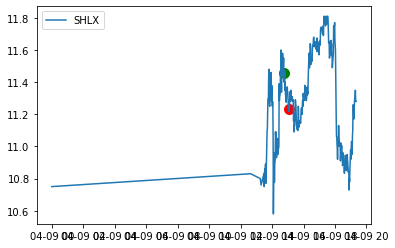

now=2020-04-09 10:04:38.248057
                            open     high      low    close    volume
timestamp                                                            
2020-03-30 04:00:00-04:00  13.75  13.7500  13.5000  13.5000     355.0
2020-03-30 04:01:00-04:00  13.73  13.7300  13.7300  13.7300     419.0
2020-03-30 04:02:00-04:00  13.70  13.7100  13.7000  13.7100     800.0
2020-03-30 04:03:00-04:00  13.71  13.7100  13.7100  13.7100    2500.0
2020-03-30 04:04:00-04:00  13.71  13.8000  13.7000  13.7000    2641.0
...                          ...      ...      ...      ...       ...
2020-04-09 15:17:00-04:00  12.29  12.3150  12.2800  12.3001  141933.0
2020-04-09 15:18:00-04:00  12.30  12.3100  12.2300  12.2300  177299.0
2020-04-09 15:19:00-04:00  12.23  12.2364  12.1800  12.2000  295385.0
2020-04-09 15:20:00-04:00  12.20  12.2491  12.1746  12.2000  181813.0
2020-04-09 15:21:00-04:00  12.21  12.2250  12.1200  12.1700  249642.0

[6453 rows x 5 columns]
index:6136 data:13.26
start
Series

Name: close, dtype: float64
[ 4.900e-03 -5.920e-02  1.520e-02  6.910e-02  0.000e+00 -3.000e-02
 -2.510e-02 -7.490e-02 -1.500e-02 -2.010e-02 -3.990e-02  5.000e-02
  5.980e-02 -1.980e-02 -1.000e-02  4.000e-02  3.500e-02  1.490e-02
  1.000e-04 -3.500e-02  0.000e+00 -2.490e-02  4.900e-03  1.490e-02
  3.510e-02 -1.020e-02 -4.480e-02  5.000e-03 -5.000e-03  7.990e-02
 -4.900e-03  1.500e-02 -1.000e-02 -5.010e-02 -9.900e-03 -2.000e-02
  2.000e-02  6.000e-02  4.000e-02  2.000e-02  1.000e-02  1.000e-02
 -3.000e-02 -1.000e-02 -5.000e-02  2.000e-02 -2.000e-04  1.020e-02
 -2.000e-02  2.000e-02  0.000e+00 -2.000e-02  0.000e+00 -1.000e-02
 -4.000e-02 -1.000e-02  1.000e-02  0.000e+00  0.000e+00  0.000e+00
 -1.000e-02  0.000e+00 -1.000e-02 -2.000e-02  0.000e+00  5.000e-02
  2.000e-02 -2.000e-02  0.000e+00 -2.000e-02  0.000e+00  1.000e-02
  1.000e-02  2.000e-02  1.000e-02 -1.000e-02 -1.000e-02  7.000e-02
  0.000e+00  5.600e-01  1.000e-02  0.000e+00  0.000e+00  1.200e-01
 -7.000e-02 -2.000e-02  2.000e-02 

  2.242e-01  2.900e-01]
[  1   3   6   8  12  17  20  23  25  28  29  37  43  45  49  52  54  56
  66  70  72  74  75  77  81  82  83  84  86  91  93  99 102 105 106 108
 111 112 114 117 118 120 122 123 126 128 131 134 138 142 147 152 156 163
 164 166 168 174 181 184 192 195 198 199 204 207 210 213 217 219 220 224
 229 232 235 238 242 243 246 252 260 265 269 272 274 278 282 286 288 293
 298 302 305 307 309 313 318 327 331 334 335 336 338 341 346 348 352 355
 358 361 366 369 371 377 380 382 388 390 394 396 405 409 412 414 418]
local_maximas=[]
start
timestamp
2020-04-06 10:20:00-04:00    9.8762
2020-04-06 10:25:00-04:00    9.7600
2020-04-06 10:30:00-04:00    9.5500
2020-04-06 10:35:00-04:00    9.5650
2020-04-06 10:40:00-04:00    9.4560
2020-04-06 10:45:00-04:00    9.4000
2020-04-06 10:50:00-04:00    9.3750
2020-04-06 10:55:00-04:00    9.4600
2020-04-06 11:00:00-04:00    9.4100
2020-04-06 11:05:00-04:00    9.3950
Name: close, dtype: float64
[-1.162e-01 -2.100e-01  1.500e-02 -1.090e-01 -5

Name: close, dtype: float64
[-6.500e-02 -8.920e-02 -2.580e-02 -2.000e-02  5.500e-02 -1.500e-02
 -5.000e-02  7.500e-02 -5.000e-03  2.000e-02 -6.500e-02 -5.000e-02
  6.510e-02 -1.010e-02 -9.310e-02 -2.690e-02 -1.134e-01 -1.116e-01
 -5.230e-02  2.730e-02 -3.000e-02 -1.010e-02 -9.990e-02 -2.380e-02
 -2.620e-02  6.000e-02 -3.000e-02  6.990e-02 -4.130e-02  1.000e-02
  6.110e-02 -3.380e-02  2.410e-02 -5.000e-03 -3.500e-02  2.000e-02
 -8.000e-02 -2.500e-02  2.500e-02 -3.620e-02  6.200e-03  2.000e-02
 -2.500e-02 -9.000e-02  1.300e-02  2.000e-03 -6.000e-02  9.000e-02
  3.000e-02 -2.000e-02  2.000e-02  8.000e-03  1.700e-02  1.050e-01
  4.970e-02  4.030e-02 -1.586e-01 -5.140e-02  5.000e-02 -7.200e-02
  5.700e-02 -7.400e-03  4.240e-02 -5.600e-03  3.560e-02  5.000e-02
 -3.000e-02  6.000e-02 -2.020e-02 -9.800e-03 -4.020e-02 -9.800e-03
  1.000e-02  0.000e+00 -1.000e-02  1.000e-02  0.000e+00 -2.000e-02
 -1.000e-02  0.000e+00 -4.000e-02 -1.000e-01 -5.000e-02 -8.000e-02
 -6.000e-02  3.000e-02  3.000e-02 

local_maximas=[]
start
timestamp
2020-04-03 08:15:00-04:00    10.2900
2020-04-03 08:20:00-04:00    10.2800
2020-04-03 08:25:00-04:00    10.2598
2020-04-03 08:30:00-04:00    10.2800
2020-04-03 08:35:00-04:00    10.3402
2020-04-03 08:40:00-04:00    10.3500
2020-04-03 08:45:00-04:00    10.3400
2020-04-03 08:50:00-04:00    10.3200
2020-04-03 08:55:00-04:00    10.3500
2020-04-03 09:00:00-04:00    10.4500
Name: close, dtype: float64
[-1.000e-02 -2.020e-02  2.020e-02  6.020e-02  9.800e-03 -1.000e-02
 -2.000e-02  3.000e-02  1.000e-01 -2.020e-02  2.000e-04 -3.000e-02
 -2.000e-02 -2.000e-02 -7.000e-02 -1.000e-02  2.000e-01 -1.549e-01
 -3.510e-02  1.000e-02  2.140e-02 -8.140e-02 -4.500e-02 -2.500e-02
 -1.400e-01 -6.500e-02 -8.920e-02 -2.580e-02 -2.000e-02  5.500e-02
 -1.500e-02 -5.000e-02  7.500e-02 -5.000e-03  2.000e-02 -6.500e-02
 -5.000e-02  6.510e-02 -1.010e-02 -9.310e-02 -2.690e-02 -1.134e-01
 -1.116e-01 -5.230e-02  2.730e-02 -3.000e-02 -1.010e-02 -9.990e-02
 -2.380e-02 -2.620e-02  6.000e-02

 -1.325e-01  2.631e-01 -6.000e-04 -3.920e-02  2.242e-01  2.900e-01]
[  5  10  12  14  17  25  29  31  33  36  38  44  48  54  56  60  64  69
  73  78  80  82  87  90  94  96  98 103 108 109 115 118 121 122 123 127
 129 130 133 136 138 142 145 147 150 154 157 159 163 165 171 175 177 183
 187 196 199 201 204 211 217 219 222 224 227 230 233 237 240 247 250 252
 254 257 259 264 265 267 268 271 278 279 282 284 291 295 297 299 300 304
 307 309 312 313 315 316 318 320 322 326 328 331 334 336 339 340 349 352
 362 368 371 374 376 382 385 389 395 397 400 402 406 411 414 417 419 422
 423 431 437 439 443 446 448 450 460 464 466 468 469 471 475 476 477 478
 480 485 487 493 496 499 500 502 505 506 508 511 512 514 516 517 520 522
 525 528 532 536 541 546 550 557 558 560 562 568 575 578 586 589 592 593
 598 601 604 607 611 613 614 618 623 626 629 632 636 637 640 646 654 659
 663 666 668 672 676 680 682 687 692 696 699 701 703 707 712 721 725 728
 729 730 732 735 740 742 746 749 752 755 760 763 765 771

local_maximas=[]
start
timestamp
2020-04-02 07:00:00-04:00    11.350
2020-04-02 07:05:00-04:00    11.220
2020-04-02 07:10:00-04:00    11.155
2020-04-02 07:15:00-04:00    11.200
2020-04-02 07:20:00-04:00    11.240
2020-04-02 07:25:00-04:00    11.320
2020-04-02 07:30:00-04:00    11.300
2020-04-02 07:35:00-04:00    11.290
2020-04-02 07:40:00-04:00    11.250
2020-04-02 07:45:00-04:00    11.270
Name: close, dtype: float64
[-1.300e-01 -6.500e-02  4.500e-02  4.000e-02  8.000e-02 -2.000e-02
 -1.000e-02 -4.000e-02  2.000e-02  3.000e-02  1.000e-02 -1.000e-02
  1.000e-02 -5.000e-02 -2.000e-02  2.000e-04 -3.000e-04 -4.900e-03
 -8.500e-02 -2.398e-01  8.980e-02 -5.000e-02  4.000e-02 -4.020e-02
 -9.980e-02 -9.020e-02 -5.980e-02 -5.000e-02 -1.990e-02  2.799e-01
  6.000e-02 -2.500e-02 -1.864e-01 -2.285e-01  1.291e-01  1.480e-02
 -4.000e-03  5.790e-02 -7.900e-03  3.000e-02 -8.970e-02 -1.020e-02
  5.990e-02 -4.000e-02 -7.280e-02 -5.720e-02 -1.001e-01 -2.990e-02
 -8.000e-02 -5.000e-03  2.000e-02 -5.510e-0

  2.242e-01  2.900e-01]
[  5  11  13  16  21  23  31  36  38  40  43  51  55  57  59  62  64  70
  74  80  82  86  90  95  99 104 106 108 113 116 120 122 124 129 134 135
 141 144 147 148 149 153 155 156 159 162 164 168 171 173 176 180 183 185
 189 191 197 201 203 209 213 222 225 227 230 237 243 245 248 250 253 256
 259 263 266 273 276 278 280 283 285 290 291 293 294 297 304 305 308 310
 317 321 323 325 326 330 333 335 338 339 341 342 344 346 348 352 354 357
 360 362 365 366 375 378 388 394 397 400 402 408 411 415 421 423 426 428
 432 437 440 443 445 448 449 457 463 465 469 472 474 476 486 490 492 494
 495 497 501 502 503 504 506 511 513 519 522 525 526 528 531 532 534 537
 538 540 542 543 546 548 551 554 558 562 567 572 576 583 584 586 588 594
 601 604 612 615 618 619 624 627 630 633 637 639 640 644 649 652 655 658
 662 663 666 672 680 685 689 692 694 698 702 706 708 713 718 722 725 727
 729 733 738 747 751 754 755 756 758 761 766 768 772 775 778 781 786 789
 791 797 800 802 808 810 81

[ 4.5000e-02 -1.7900e-02  6.2900e-02  6.0000e-02 -1.6000e-01  4.2000e-03
 -1.4200e-02 -6.0100e-02 -4.1000e-03  4.4200e-02  1.5000e-02 -4.5000e-02
 -5.0000e-03 -4.5100e-02  2.5100e-02 -2.0000e-02 -5.5000e-02 -2.5000e-02
 -2.5800e-02 -9.2000e-03 -6.0000e-02 -1.6000e-01  7.0000e-02  1.0000e-02
  1.9900e-02 -9.6000e-02 -4.4000e-02 -5.9900e-02 -1.0140e-01 -1.2900e-02
  4.4200e-02  2.0100e-02  0.0000e+00  8.6000e-03  1.4000e-03  9.9000e-03
  2.5100e-02  1.0000e-02 -7.5000e-02 -1.5000e-02  5.5000e-02  3.5000e-02
  1.1500e-01 -2.0000e-02 -5.5000e-02  1.1500e-02 -1.6500e-02 -1.0000e-02
  2.0000e-02  2.5000e-02 -3.5000e-02 -6.5000e-02  0.0000e+00  1.5000e-02
 -1.2200e-02 -1.7800e-02  2.5000e-02 -1.5100e-02  5.1000e-03  3.0000e-02
  2.5000e-02 -4.5000e-02 -8.6000e-03 -2.1400e-02 -5.1000e-03  6.0100e-02
  1.1300e-02 -2.1300e-02  2.0000e-02 -9.9010e-03 -1.0099e-02 -1.0000e-02
  0.0000e+00  2.0000e-02  1.0000e-02  3.0000e-02 -2.0000e-02  2.0000e-02
  1.0000e-02  1.0000e-02  4.0000e-02  4.0000e-02  1

[-7.9800e-02 -1.0000e-02 -3.3000e-01  2.9900e-02  1.4000e-01 -1.3490e-01
 -8.0300e-02 -1.2000e-02 -1.7700e-02  2.5000e-02  9.8000e-02  5.0600e-02
  1.6400e-02 -1.7900e-02  6.2900e-02  6.0000e-02 -1.6000e-01  4.2000e-03
 -1.4200e-02 -6.0100e-02 -4.1000e-03  4.4200e-02  1.5000e-02 -4.5000e-02
 -5.0000e-03 -4.5100e-02  2.5100e-02 -2.0000e-02 -5.5000e-02 -2.5000e-02
 -2.5800e-02 -9.2000e-03 -6.0000e-02 -1.6000e-01  7.0000e-02  1.0000e-02
  1.9900e-02 -9.6000e-02 -4.4000e-02 -5.9900e-02 -1.0140e-01 -1.2900e-02
  4.4200e-02  2.0100e-02  0.0000e+00  8.6000e-03  1.4000e-03  9.9000e-03
  2.5100e-02  1.0000e-02 -7.5000e-02 -1.5000e-02  5.5000e-02  3.5000e-02
  1.1500e-01 -2.0000e-02 -5.5000e-02  1.1500e-02 -1.6500e-02 -1.0000e-02
  2.0000e-02  2.5000e-02 -3.5000e-02 -6.5000e-02  0.0000e+00  1.5000e-02
 -1.2200e-02 -1.7800e-02  2.5000e-02 -1.5100e-02  5.1000e-03  3.0000e-02
  2.5000e-02 -4.5000e-02 -8.6000e-03 -2.1400e-02 -5.1000e-03  6.0100e-02
  1.1300e-02 -2.1300e-02  2.0000e-02 -9.9010e-03 -1

local_maximas=[]
start
timestamp
2020-04-01 07:05:00-04:00    11.70
2020-04-01 07:10:00-04:00    11.68
2020-04-01 07:15:00-04:00    11.65
2020-04-01 07:20:00-04:00    11.68
2020-04-01 07:25:00-04:00    11.60
2020-04-01 07:30:00-04:00    11.65
2020-04-01 07:35:00-04:00    11.63
2020-04-01 07:40:00-04:00    11.63
2020-04-01 07:45:00-04:00    11.60
2020-04-01 07:50:00-04:00    11.54
Name: close, dtype: float64
[-0.02   -0.03    0.03   ... -0.0392  0.2242  0.29  ]
[   3    5    7   11   15   17   20   24   25   31   39   42   44   49
   53   63   70   76   81   84   88   92   95   99  105  107  114  121
  122  124  125  127  129  130  134  135  136  137  138  139  140  142
  144  147  148  151  152  155  157  159  161  164  167  170  171  172
  174  177  178  180  183  188  194  196  199  204  206  214  219  221
  223  226  234  238  240  242  245  247  253  257  263  265  269  273
  278  282  287  289  291  296  299  303  305  307  312  317  318  324
  327  330  331  332  336  338  339  3

local_maximas=[13.2]
AAL analysis for run 228 with profit 11.2


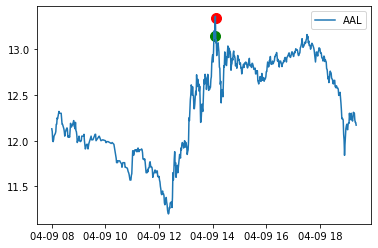

now=2020-04-09 10:04:47.362691
                            open   high   low  close  volume
timestamp                                                   
2020-03-30 09:29:00-04:00  6.040  6.090  6.04  6.090    3928
2020-03-30 09:30:00-04:00  6.250  6.530  6.08  6.325   98789
2020-03-30 09:31:00-04:00  6.325  6.325  6.19  6.190    8980
2020-03-30 09:32:00-04:00  6.190  6.240  6.15  6.190    4019
2020-03-30 09:33:00-04:00  6.090  6.090  5.90  5.900    2558
...                          ...    ...   ...    ...     ...
2020-04-09 15:16:00-04:00  5.600  5.610  5.59  5.590    5618
2020-04-09 15:18:00-04:00  5.580  5.580  5.55  5.550    1883
2020-04-09 15:19:00-04:00  5.520  5.530  5.52  5.530    3961
2020-04-09 15:20:00-04:00  5.540  5.540  5.54  5.540     683
2020-04-09 15:21:00-04:00  5.530  5.530  5.51  5.510     729

[3324 rows x 5 columns]
index:3022 data:6.3
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
t

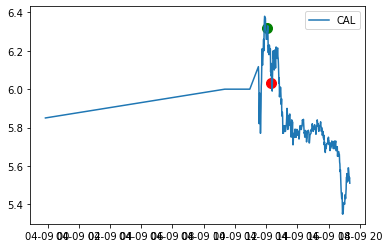

now=2020-04-09 10:42:39.515062
                              open     high      low    close  volume
timestamp                                                            
2020-03-30 09:30:00-04:00  11.8900  11.8900  11.7300  11.7300    4978
2020-03-30 09:31:00-04:00  11.7988  11.7988  11.7988  11.7988    5317
2020-03-30 09:32:00-04:00  12.0200  12.0200  12.0200  12.0200     102
2020-03-30 09:35:00-04:00  11.7800  11.7800  11.7500  11.7500     599
2020-03-30 09:37:00-04:00  11.6600  11.6600  11.6600  11.6600     100
...                            ...      ...      ...      ...     ...
2020-04-09 15:17:00-04:00  13.9100  13.9400  13.9100  13.9300    3627
2020-04-09 15:18:00-04:00  13.9350  13.9350  13.9150  13.9200    2885
2020-04-09 15:19:00-04:00  13.9200  13.9400  13.9100  13.9400    2294
2020-04-09 15:20:00-04:00  13.9500  13.9800  13.9400  13.9400    4263
2020-04-09 15:21:00-04:00  13.9400  13.9500  13.9150  13.9200    1571

[3400 rows x 5 columns]
index:3123 data:13.58
start
Series

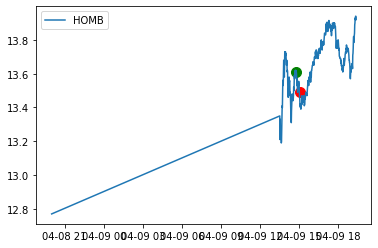

now=2020-04-09 11:00:17.762982
                              open     high      low    close  volume
timestamp                                                            
2020-03-30 09:30:00-04:00  15.5000  15.5000  15.4600  15.4600    4076
2020-03-30 09:32:00-04:00  16.0000  16.0000  16.0000  16.0000     300
2020-03-30 09:33:00-04:00  15.9683  15.9683  15.9683  15.9683     278
2020-03-30 09:36:00-04:00  15.6300  15.6300  15.6000  15.6000    1670
2020-03-30 09:38:00-04:00  15.6000  15.6090  15.3500  15.3500    7308
...                            ...      ...      ...      ...     ...
2020-04-09 15:16:00-04:00  16.6700  16.6700  16.6300  16.6300     697
2020-04-09 15:17:00-04:00  16.6800  16.6800  16.6800  16.6800     133
2020-04-09 15:18:00-04:00  16.6700  16.6700  16.6000  16.6000     368
2020-04-09 15:19:00-04:00  16.5200  16.5200  16.5200  16.5200     229
2020-04-09 15:21:00-04:00  16.5700  16.5700  16.5700  16.5700     100

[2546 rows x 5 columns]
index:2329 data:16.945
start
Serie

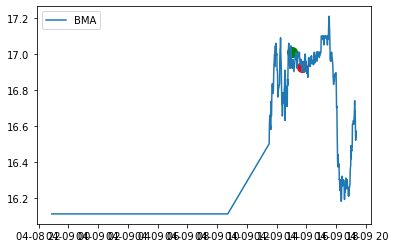

now=2020-04-09 09:55:21.343433
                            open    high   low   close  volume
timestamp                                                     
2020-03-30 04:32:00-04:00  5.500  5.5100  5.50  5.5100    1792
2020-03-30 06:04:00-04:00  5.510  5.5100  5.51  5.5100     122
2020-03-30 06:47:00-04:00  5.510  5.5100  5.51  5.5100     936
2020-03-30 06:51:00-04:00  5.510  5.5100  5.51  5.5100     101
2020-03-30 06:52:00-04:00  5.510  5.5100  5.51  5.5100     100
...                          ...     ...   ...     ...     ...
2020-04-09 15:17:00-04:00  4.445  4.4499  4.44  4.4400   31406
2020-04-09 15:18:00-04:00  4.440  4.4400  4.43  4.4300   47966
2020-04-09 15:19:00-04:00  4.430  4.4387  4.41  4.4130   36756
2020-04-09 15:20:00-04:00  4.415  4.4200  4.41  4.4173   15260
2020-04-09 15:21:00-04:00  4.415  4.4150  4.41  4.4100   13036

[4351 rows x 5 columns]
index:4024 data:4.8106
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, 

timestamp
2020-04-03 18:10:00-04:00    3.81
2020-04-03 18:20:00-04:00    3.90
2020-04-03 18:25:00-04:00    3.81
2020-04-03 18:40:00-04:00    3.80
2020-04-03 18:45:00-04:00    3.85
2020-04-03 18:50:00-04:00    3.81
2020-04-03 19:05:00-04:00    3.90
2020-04-03 19:35:00-04:00    3.90
2020-04-03 19:45:00-04:00    3.87
2020-04-03 19:50:00-04:00    3.88
Name: close, dtype: float64
[ 9.000e-02 -9.000e-02 -1.000e-02  5.000e-02 -4.000e-02  9.000e-02
  0.000e+00 -3.000e-02  1.000e-02 -1.000e-02  1.300e-01  2.000e-02
 -2.000e-02  2.200e-01 -1.100e-01  0.000e+00  0.000e+00  4.000e-02
  7.000e-02 -7.000e-02 -5.000e-02  0.000e+00  0.000e+00  0.000e+00
 -5.000e-02  0.000e+00  1.200e-01  0.000e+00 -2.000e-02  2.000e-02
 -7.000e-02 -1.000e-02  1.000e-02 -1.000e-02  0.000e+00 -1.000e-02
  0.000e+00  1.000e-02 -1.000e-02  0.000e+00  0.000e+00 -1.020e-02
 -3.980e-02  2.000e-02  2.000e-02 -2.000e-04 -1.730e-02 -6.450e-02
  3.200e-02  3.000e-02  2.000e-02 -2.000e-02  3.500e-02  2.380e-02
 -2.880e-02 -4.000e

 -3.450e-02  2.199e-01  5.000e-02  3.000e-02]
[  1   6  10  12  13  15  16  18  20  22  26  29  30  31  33  34  35  37
  38  40  42  46  48  51  53  54  55  56  60  62  65  74  78  82  86  90
  94  99 103 107 111 114 117 119 125 129 130 132 135 142 146 149 150 151
 152 154 155 158 159 160 161 165 167 168 173 174 177 179 181 184 189 196
 199 204 207 210 212 214 215 219 222 223 224 227 228 229 230 231 235 236
 241 242 246 248 252 254 256 259 260 262 264 265 267 268 269 270 272 274
 277 279 280 282 285 287 289 292 295 296 297 300 301 303 306 308 311 313
 314 318 324 327 330 332 336 340 344 345 349 354 359 360 362 367 371 373
 375 381 382 385 389 394 397 400 403 406 407 408 409 411 412 415 417 422
 425 428 433 434 435 436 439 440 444 445 447 448 450 451 452 454 455 457
 461 468 477 478 481 484 488 491 493 496 499 510 513 515 517 519 522 525
 526 527 532 535 538 540 542 545 546 548 550 551 554 555 557 558 559 560
 562 564 565 566 568 570 571 574 576 578 581 583 587 590 600 602 605 610
 614 

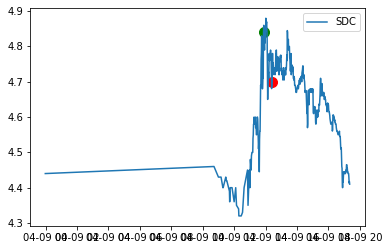

now=2020-04-09 09:50:50.536803
                           open    high    low   close  volume
timestamp                                                     
2020-03-30 07:03:00-04:00  4.33  4.3300  4.330  4.3300     100
2020-03-30 08:00:00-04:00  4.06  4.0600  4.060  4.0600     100
2020-03-30 08:12:00-04:00  4.06  4.0601  4.060  4.0601    1100
2020-03-30 08:59:00-04:00  4.06  4.1300  4.060  4.1300     874
2020-03-30 09:02:00-04:00  4.13  4.1900  4.130  4.1900     495
...                         ...     ...    ...     ...     ...
2020-04-09 15:17:00-04:00  4.18  4.1800  4.170  4.1800    1008
2020-04-09 15:18:00-04:00  4.17  4.1700  4.145  4.1500    6380
2020-04-09 15:19:00-04:00  4.16  4.1600  4.150  4.1600    3354
2020-04-09 15:20:00-04:00  4.17  4.1800  4.130  4.1400   34268
2020-04-09 15:21:00-04:00  4.14  4.1500  4.125  4.1300   19724

[3519 rows x 5 columns]
index:3193 data:4.17
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dt

timestamp
2020-04-02 14:40:00-04:00    2.8900
2020-04-02 14:45:00-04:00    2.8899
2020-04-02 14:50:00-04:00    2.8850
2020-04-02 14:55:00-04:00    2.8894
2020-04-02 15:00:00-04:00    2.9100
2020-04-02 15:05:00-04:00    2.9100
2020-04-02 15:10:00-04:00    2.9070
2020-04-02 15:15:00-04:00    2.9350
2020-04-02 15:20:00-04:00    2.9400
2020-04-02 15:25:00-04:00    2.9399
Name: close, dtype: float64
[-1.000e-04 -4.900e-03  4.400e-03  2.060e-02  0.000e+00 -3.000e-03
  2.800e-02  5.000e-03 -1.000e-04 -4.900e-03 -1.000e-02 -2.350e-02
 -3.500e-03  2.000e-03  5.000e-02  0.000e+00  1.500e-01 -1.900e-01
 -8.000e-02  7.500e-02 -6.810e-02 -2.690e-02 -3.000e-02  3.990e-02
 -5.500e-02 -1.490e-02 -5.500e-02  4.430e-02 -3.220e-02  2.900e-03
 -4.500e-02  0.000e+00 -2.500e-02  5.000e-03 -1.500e-02  2.500e-02
  2.500e-02 -2.500e-02 -1.920e-02 -8.000e-04  0.000e+00 -5.000e-03
 -1.500e-03 -1.850e-02 -3.000e-02 -4.000e-02 -1.500e-02  0.000e+00
 -1.000e-02 -5.000e-03 -5.500e-02 -8.500e-02 -2.500e-02  3.500e-02

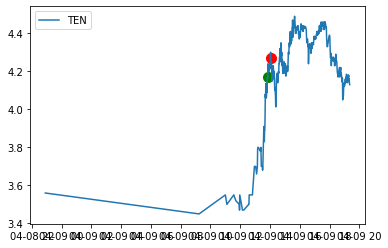

now=2020-04-09 10:02:29.036608
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:30:00-04:00  5.7900  5.8200  5.7500  5.7500    3957
2020-03-30 09:33:00-04:00  5.6900  5.6900  5.6900  5.6900     100
2020-03-30 09:41:00-04:00  5.6434  5.6434  5.6434  5.6434     100
2020-03-30 09:42:00-04:00  5.5500  5.5500  5.5500  5.5500    1049
2020-03-30 09:44:00-04:00  5.6138  5.6138  5.6138  5.6138     100
...                           ...     ...     ...     ...     ...
2020-04-09 15:08:00-04:00  5.4900  5.4900  5.4900  5.4900     200
2020-04-09 15:10:00-04:00  5.4600  5.5080  5.4200  5.4200   12302
2020-04-09 15:11:00-04:00  5.5200  5.5200  5.3911  5.3911    6700
2020-04-09 15:12:00-04:00  5.3911  5.3911  5.3911  5.3911    1248
2020-04-09 15:16:00-04:00  5.4655  5.4700  5.4655  5.4700     200

[1211 rows x 5 columns]
index:1055 data:5.78
start
timestamp
2020-04-08 15:15:00-04:00    5.4637
2020-04-08 15

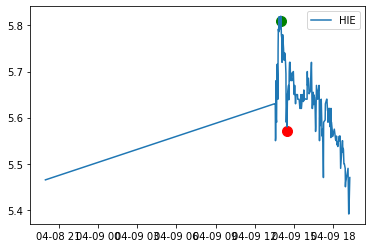

now=2020-04-09 10:48:33.138769
                             open    high   low  close  volume
timestamp                                                     
2020-03-30 09:19:00-04:00  7.2000  7.2000  7.20  7.200     100
2020-03-30 09:27:00-04:00  7.2000  7.2000  7.20  7.200     300
2020-03-30 09:30:00-04:00  7.1200  7.1300  7.00  7.000   26919
2020-03-30 09:31:00-04:00  6.9900  7.0000  6.78  6.780    6934
2020-03-30 09:32:00-04:00  6.7800  6.8100  6.75  6.810    2274
...                           ...     ...   ...    ...     ...
2020-04-08 11:11:00-04:00  7.2100  7.2200  7.19  7.190    8044
2020-04-08 11:12:00-04:00  7.1900  7.2200  7.19  7.215   15670
2020-04-08 11:13:00-04:00  7.2100  7.2150  7.21  7.215     614
2020-04-08 11:14:00-04:00  7.2172  7.2172  7.19  7.190    4342
2020-04-08 11:15:00-04:00  7.1900  7.1900  7.17  7.180    2262

[2725 rows x 5 columns]
index:2724 data:7.18
start
timestamp
2020-04-07 14:20:00-04:00    7.1700
2020-04-07 14:25:00-04:00    7.2600
2020-04-07 14:30

Name: close, dtype: float64
[ 7.500e-02  6.000e-02 -2.240e-02  2.400e-03 -2.600e-01  1.000e-04
  2.599e-01 -2.600e-01  0.000e+00  9.000e-02 -1.300e-01  5.000e-02
  3.000e-02  1.050e-01 -1.850e-01 -1.700e-01  1.000e-02 -8.000e-02
  5.830e-02 -5.830e-02 -5.000e-02 -1.210e-02 -9.900e-03 -4.300e-02
  1.000e-02 -5.500e-02 -9.000e-02 -2.500e-02  3.500e-02 -5.000e-03
  1.550e-01 -2.000e-02 -1.150e-01 -4.000e-02 -5.000e-03 -2.000e-02
 -2.480e-02 -5.200e-03  5.000e-03 -2.500e-02 -3.000e-02 -5.000e-02
 -5.000e-02 -8.000e-02  1.000e-02  5.000e-02 -5.000e-03 -2.500e-02
  5.000e-03 -3.500e-02 -8.700e-02  2.000e-03 -5.000e-03 -2.500e-02
 -5.000e-03  1.000e-02 -5.000e-03 -1.000e-02 -2.000e-02  8.500e-02
 -1.000e-02  6.000e-02 -1.000e-02 -3.000e-02 -2.000e-02 -2.000e-02
 -3.200e-03 -4.680e-02 -2.500e-03 -1.750e-02 -3.000e-02 -2.000e-02
  1.000e-02  0.000e+00 -2.000e-02 -3.000e-02 -7.000e-02 -5.000e-02
 -4.500e-02 -1.000e-02 -1.500e-02 -1.000e-02  0.000e+00 -5.000e-03
 -1.350e-01  3.000e-02  2.000e-02 

local_maximas=[]
start
timestamp
2020-03-31 12:35:00-04:00    6.84
2020-03-31 12:40:00-04:00    6.75
2020-03-31 12:45:00-04:00    6.84
2020-03-31 12:50:00-04:00    6.81
2020-03-31 12:55:00-04:00    6.80
2020-03-31 13:00:00-04:00    6.78
2020-03-31 13:05:00-04:00    6.73
2020-03-31 13:10:00-04:00    6.66
2020-03-31 13:15:00-04:00    6.63
2020-03-31 13:20:00-04:00    6.58
Name: close, dtype: float64
[-9.000e-02  9.000e-02 -3.000e-02 -1.000e-02 -2.000e-02 -5.000e-02
 -7.000e-02 -3.000e-02 -5.000e-02  0.000e+00  2.000e-02  6.000e-02
 -3.000e-02  5.000e-03 -4.470e-02  4.970e-02 -1.000e-02  0.000e+00
 -1.000e-02 -3.000e-02  2.220e-02  3.780e-02  8.000e-02  3.040e-02
  7.400e-03 -5.780e-02  0.000e+00  1.000e-02  1.000e-02 -1.000e-02
  1.000e-04 -1.010e-02 -5.000e-02  1.000e-02 -4.000e-02  1.000e-02
  5.000e-03  7.500e-02  6.000e-02 -2.240e-02  2.400e-03 -2.600e-01
  1.000e-04  2.599e-01 -2.600e-01  0.000e+00  9.000e-02 -1.300e-01
  5.000e-02  3.000e-02  1.050e-01 -1.850e-01 -1.700e-01  1.000e

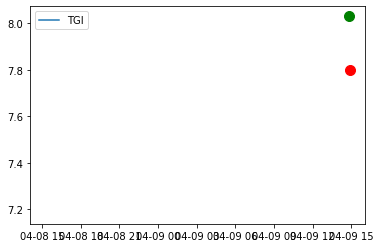

now=2020-04-09 10:01:31.638840
                            open   high    low   close  volume
timestamp                                                     
2020-03-30 09:13:00-04:00  3.600  3.600  3.600  3.6000     901
2020-03-30 09:30:00-04:00  3.580  3.700  3.580  3.6200   23714
2020-03-30 09:31:00-04:00  3.570  3.630  3.570  3.6300    3839
2020-03-30 09:32:00-04:00  3.595  3.630  3.595  3.6300     212
2020-03-30 09:34:00-04:00  3.570  3.610  3.570  3.6100    2197
...                          ...    ...    ...     ...     ...
2020-04-09 15:17:00-04:00  4.020  4.030  4.020  4.0300    6156
2020-04-09 15:18:00-04:00  4.020  4.030  4.010  4.0200    8952
2020-04-09 15:19:00-04:00  4.025  4.025  3.980  3.9804   17926
2020-04-09 15:20:00-04:00  3.990  4.060  3.990  4.0300   39014
2020-04-09 15:21:00-04:00  4.040  4.060  3.990  4.0100   10776

[3484 rows x 5 columns]
index:3167 data:4.28
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dt

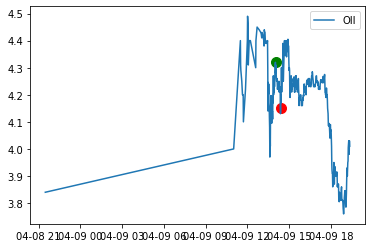

now=2020-04-09 10:00:08.100356
                           open   high     low  close   volume
timestamp                                                     
2020-03-30 07:00:00-04:00  4.50  4.560  4.5000  4.560    281.0
2020-03-30 07:30:00-04:00  4.18  4.180  4.1800  4.180   2031.0
2020-03-30 08:02:00-04:00  4.18  4.180  4.1800  4.180   1000.0
2020-03-30 08:03:00-04:00  4.20  4.200  4.2000  4.200   1000.0
2020-03-30 08:36:00-04:00  4.20  4.200  4.2000  4.200    400.0
...                         ...    ...     ...    ...      ...
2020-04-08 11:04:00-04:00  3.40  3.400  3.3901  3.395    977.0
2020-04-08 11:05:00-04:00  3.40  3.410  3.3950  3.410   4440.0
2020-04-08 11:06:00-04:00  3.40  3.410  3.3900  3.405  10426.0
2020-04-08 11:07:00-04:00  3.40  3.405  3.3900  3.400   6898.0
2020-04-08 11:08:00-04:00  3.41  3.420  3.4050  3.410   5953.0

[3044 rows x 5 columns]
index:3043 data:3.41
start
timestamp
2020-04-07 14:20:00-04:00    3.3200
2020-04-07 14:25:00-04:00    3.3300
2020-04-07 14:30

timestamp
2020-04-02 09:50:00-04:00    3.2500
2020-04-02 09:55:00-04:00    3.2200
2020-04-02 10:00:00-04:00    3.2100
2020-04-02 10:05:00-04:00    3.2001
2020-04-02 10:10:00-04:00    3.2000
2020-04-02 10:15:00-04:00    3.2000
2020-04-02 10:20:00-04:00    3.2050
2020-04-02 10:25:00-04:00    3.1950
2020-04-02 10:30:00-04:00    3.1804
2020-04-02 10:35:00-04:00    3.1850
Name: close, dtype: float64
[-3.000e-02 -1.000e-02 -9.900e-03 -1.000e-04  0.000e+00  5.000e-03
 -1.000e-02 -1.460e-02  4.600e-03 -1.680e-02 -8.200e-03 -3.200e-03
 -1.090e-02 -1.590e-02 -5.000e-03 -2.250e-02  5.300e-03 -2.800e-03
 -4.000e-03  0.000e+00 -6.100e-02 -2.010e-02  1.000e-04 -1.000e-04
 -1.800e-03  1.800e-03  1.000e-04  4.000e-02  2.500e-02 -1.650e-02
 -3.850e-02 -1.500e-03 -8.600e-03 -3.500e-03  3.500e-03 -9.900e-03
 -5.000e-03  2.800e-03 -2.280e-02 -1.680e-02  1.700e-03 -4.900e-03
 -1.000e-02 -3.500e-02  2.650e-02  3.500e-03  9.900e-03  1.000e-04
 -2.000e-02 -9.900e-03 -2.010e-02 -1.000e-02  1.000e-02 -5.000e-03

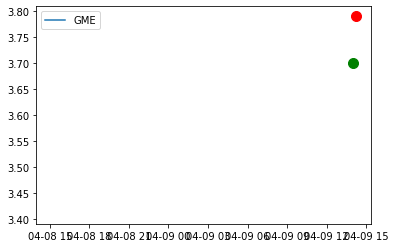

now=2020-04-09 10:31:22.557310
                            open   high   low  close  volume
timestamp                                                   
2020-03-30 09:14:00-04:00  3.920  3.920  3.92  3.920     403
2020-03-30 09:30:00-04:00  4.040  4.110  4.00  4.110   15555
2020-03-30 09:33:00-04:00  4.050  4.090  4.05  4.050    1012
2020-03-30 09:36:00-04:00  4.050  4.050  4.05  4.050     127
2020-03-30 09:37:00-04:00  4.050  4.050  4.05  4.050     100
...                          ...    ...   ...    ...     ...
2020-04-09 15:17:00-04:00  4.000  4.015  4.00  4.015    1100
2020-04-09 15:18:00-04:00  4.015  4.030  3.98  3.980    2261
2020-04-09 15:19:00-04:00  4.000  4.000  3.98  4.000    1000
2020-04-09 15:20:00-04:00  4.000  4.000  4.00  4.000     238
2020-04-09 15:21:00-04:00  4.000  4.000  3.98  3.980     586

[2131 rows x 5 columns]
index:1939 data:4.36
start
timestamp
2020-04-09 10:20:00-04:00    4.10
2020-04-09 10:25:00-04:00    4.36
2020-04-09 10:30:00-04:00    4.40
Freq: 5T, Na

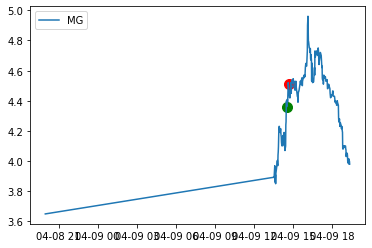

now=2020-04-09 10:36:24.858350
                            open   high     low  close  volume
timestamp                                                     
2020-03-30 07:41:00-04:00  6.080  6.080  6.0800  6.080     100
2020-03-30 08:00:00-04:00  6.090  6.090  6.0900  6.090     100
2020-03-30 09:29:00-04:00  6.100  6.100  6.1000  6.100     131
2020-03-30 09:30:00-04:00  6.090  6.160  5.9700  6.120   51409
2020-03-30 09:31:00-04:00  6.150  6.210  6.1483  6.210    9401
...                          ...    ...     ...    ...     ...
2020-04-09 15:17:00-04:00  7.090  7.090  7.0700  7.075    9794
2020-04-09 15:18:00-04:00  7.070  7.075  7.0400  7.050   11530
2020-04-09 15:19:00-04:00  7.045  7.050  7.0400  7.050    9484
2020-04-09 15:20:00-04:00  7.055  7.055  7.0150  7.030   17452
2020-04-09 15:21:00-04:00  7.030  7.035  7.0200  7.035    5990

[3505 rows x 5 columns]
index:3219 data:7.34
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dt

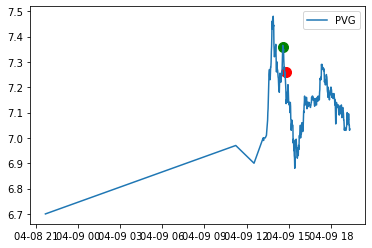

now=2020-04-09 10:39:45.545015
                              open     high      low    close  volume
timestamp                                                            
2020-03-30 08:34:00-04:00  15.8125  15.8125  15.8125  15.8125    8147
2020-03-30 09:00:00-04:00  15.7500  15.7500  15.7500  15.7500     100
2020-03-30 09:30:00-04:00  15.7000  16.0500  15.7000  16.0500   42708
2020-03-30 09:31:00-04:00  15.8650  15.9403  15.6900  15.8550    2449
2020-03-30 09:32:00-04:00  15.6800  15.9700  15.6300  15.9500   20816
...                            ...      ...      ...      ...     ...
2020-04-09 15:17:00-04:00  17.1800  17.2100  17.1300  17.1500   13242
2020-04-09 15:18:00-04:00  17.1300  17.1350  17.1000  17.1200    1442
2020-04-09 15:19:00-04:00  17.1100  17.1300  17.1000  17.1300    7979
2020-04-09 15:20:00-04:00  17.1400  17.2488  17.1400  17.1719    8324
2020-04-09 15:21:00-04:00  17.1700  17.1789  17.1300  17.1450    7017

[3487 rows x 5 columns]
index:3205 data:17.82
start
Series

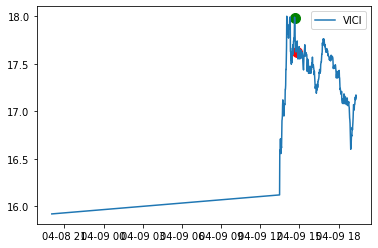

now=2020-04-09 10:43:32.639534
                            open   high    low  close  volume
timestamp                                                    
2020-03-30 09:30:00-04:00  7.970  8.080  7.970  8.080   17425
2020-03-30 09:31:00-04:00  8.020  8.050  8.020  8.040     306
2020-03-30 09:32:00-04:00  7.900  8.040  7.850  8.040     600
2020-03-30 09:33:00-04:00  8.030  8.110  8.020  8.110    2688
2020-03-30 09:34:00-04:00  8.150  8.200  8.100  8.100    2808
...                          ...    ...    ...    ...     ...
2020-04-09 15:17:00-04:00  8.980  8.990  8.975  8.990    5810
2020-04-09 15:18:00-04:00  8.990  8.990  8.975  8.980    6968
2020-04-09 15:19:00-04:00  8.970  8.975  8.970  8.975     836
2020-04-09 15:20:00-04:00  8.980  8.990  8.975  8.980   13390
2020-04-09 15:21:00-04:00  8.985  8.985  8.900  8.960   59906

[3410 rows x 5 columns]
index:3141 data:9.04
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)

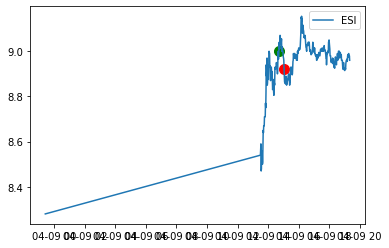

now=2020-04-09 10:41:41.658404
                             open    high    low   close   volume
timestamp                                                        
2020-03-30 07:06:00-04:00  11.600  11.600  11.60  11.600    100.0
2020-03-30 07:11:00-04:00  11.700  11.700  11.60  11.600    700.0
2020-03-30 07:20:00-04:00  11.800  11.800  11.80  11.800    461.0
2020-03-30 07:43:00-04:00  11.550  11.550  11.55  11.550    902.0
2020-03-30 07:56:00-04:00  11.520  11.520  11.52  11.520    100.0
...                           ...     ...    ...     ...      ...
2020-04-09 15:17:00-04:00   7.740   7.745   7.69   7.745  12312.0
2020-04-09 15:18:00-04:00   7.740   7.750   7.66   7.670  11569.0
2020-04-09 15:19:00-04:00   7.670   7.730   7.67   7.730  10340.0
2020-04-09 15:20:00-04:00   7.740   7.760   7.68   7.680  12512.0
2020-04-09 15:21:00-04:00   7.675   7.690   7.65   7.690  89743.0

[4140 rows x 5 columns]
index:3860 data:7.93
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

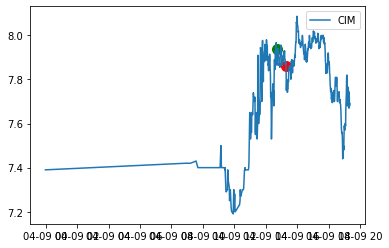

now=2020-04-09 10:01:49.364620
                           open    high     low   close  volume
timestamp                                                      
2020-03-30 07:00:00-04:00  3.60  3.6000  3.5000  3.5000     700
2020-03-30 07:09:00-04:00  3.49  3.4900  3.4400  3.4400    1905
2020-03-30 07:14:00-04:00  3.33  3.3300  3.3000  3.3000     750
2020-03-30 07:15:00-04:00  3.25  3.2500  3.2500  3.2500     500
2020-03-30 07:56:00-04:00  3.25  3.2500  3.2500  3.2500     557
...                         ...     ...     ...     ...     ...
2020-04-09 15:15:00-04:00  3.25  3.2601  3.2300  3.2300    5414
2020-04-09 15:16:00-04:00  3.25  3.2500  3.2500  3.2500     352
2020-04-09 15:17:00-04:00  3.27  3.2800  3.2602  3.2748    6978
2020-04-09 15:19:00-04:00  3.26  3.2600  3.2600  3.2600     514
2020-04-09 15:21:00-04:00  3.25  3.2500  3.2500  3.2500     211

[2643 rows x 5 columns]
index:2381 data:3.3202
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, 

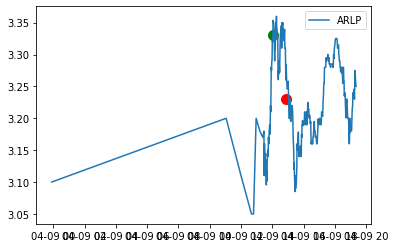

now=2020-04-09 10:50:56.188822
                            open   high    low  close  volume
timestamp                                                    
2020-03-30 09:30:00-04:00  6.800  6.800  6.800  6.800    1337
2020-03-30 09:39:00-04:00  6.840  6.840  6.840  6.840     100
2020-03-30 09:42:00-04:00  6.800  6.800  6.800  6.800     200
2020-03-30 09:43:00-04:00  6.690  6.690  6.590  6.590     710
2020-03-30 09:44:00-04:00  6.574  6.574  6.574  6.574     160
...                          ...    ...    ...    ...     ...
2020-04-09 15:14:00-04:00  7.320  7.320  7.320  7.320     100
2020-04-09 15:15:00-04:00  7.340  7.340  7.260  7.260    6207
2020-04-09 15:16:00-04:00  7.260  7.260  7.260  7.260     425
2020-04-09 15:20:00-04:00  7.210  7.260  7.210  7.240    1328
2020-04-09 15:21:00-04:00  7.280  7.280  7.280  7.280     100

[1566 rows x 5 columns]
index:1459 data:7.89
start
timestamp
2020-04-08 14:45:00-04:00    7.190
2020-04-08 14:50:00-04:00    7.160
2020-04-08 14:55:00-04:00    7.

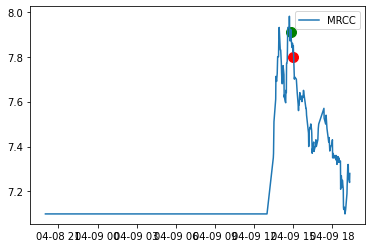

now=2020-04-09 10:16:55.642762
                             open   high     low  close  volume
timestamp                                                      
2020-03-30 09:28:00-04:00  4.2800  4.330  4.2800   4.33     776
2020-03-30 09:29:00-04:00  4.2900  4.290  4.2900   4.29     469
2020-03-30 09:30:00-04:00  4.3600  4.420  4.3600   4.42   46740
2020-03-30 09:31:00-04:00  4.4900  4.490  4.4900   4.49     165
2020-03-30 09:32:00-04:00  4.2801  4.560  4.2801   4.42    2692
...                           ...    ...     ...    ...     ...
2020-04-09 15:16:00-04:00  4.0400  4.040  4.0319   4.04     512
2020-04-09 15:17:00-04:00  4.0100  4.010  4.0100   4.01     106
2020-04-09 15:18:00-04:00  4.0400  4.040  4.0400   4.04     107
2020-04-09 15:19:00-04:00  4.0100  4.010  4.0100   4.01     100
2020-04-09 15:20:00-04:00  4.0250  4.025  4.0100   4.01     327

[2949 rows x 5 columns]
index:2681 data:4.11
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Na

local_maximas=[]
start
timestamp
2020-04-02 10:00:00-04:00    3.6250
2020-04-02 10:05:00-04:00    3.6100
2020-04-02 10:10:00-04:00    3.6800
2020-04-02 10:15:00-04:00    3.6500
2020-04-02 10:20:00-04:00    3.6200
2020-04-02 10:25:00-04:00    3.6100
2020-04-02 10:30:00-04:00    3.5901
2020-04-02 10:35:00-04:00    3.5975
2020-04-02 10:40:00-04:00    3.5800
2020-04-02 10:45:00-04:00    3.5700
Name: close, dtype: float64
[-1.500e-02  7.000e-02 -3.000e-02 -3.000e-02 -1.000e-02 -1.990e-02
  7.400e-03 -1.750e-02 -1.000e-02  1.000e-02  3.000e-02  5.000e-02
  4.000e-02  1.000e-02  1.000e-02 -1.000e-02  1.010e-02  9.900e-03
 -2.500e-02 -2.320e-02  8.200e-03  0.000e+00  0.000e+00 -5.000e-03
  1.500e-02 -3.000e-02 -2.000e-02 -1.000e-02 -5.500e-02 -3.000e-02
  0.000e+00 -4.490e-02 -1.510e-02  2.000e-02 -2.500e-02 -1.550e-01
 -2.490e-02 -7.010e-02 -1.200e-01 -7.000e-02  1.500e-02  5.000e-03
 -3.000e-04  2.030e-02  2.670e-02 -1.700e-03  5.000e-03 -3.000e-02
 -7.990e-02 -4.010e-02 -1.100e-01 -5.000e-0

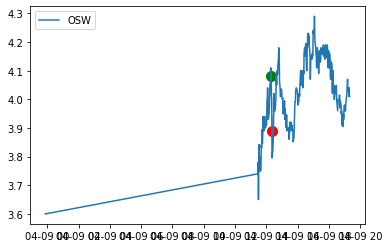

now=2020-04-09 10:50:53.485561
                              open     high      low   close  volume
timestamp                                                           
2020-03-30 09:30:00-04:00  10.8300  10.8300  10.8300  10.830   11428
2020-03-30 09:37:00-04:00  10.7100  10.7100  10.7100  10.710     270
2020-03-30 09:39:00-04:00  10.6201  10.6201  10.5761  10.580     996
2020-03-30 09:40:00-04:00  10.5050  10.5050  10.3500  10.350     839
2020-03-30 09:42:00-04:00  10.3400  10.3400  10.3100  10.330    2191
...                            ...      ...      ...     ...     ...
2020-04-09 15:17:00-04:00  11.8200  11.8500  11.8000  11.835    2302
2020-04-09 15:18:00-04:00  11.8500  11.8500  11.8450  11.845    2003
2020-04-09 15:19:00-04:00  11.8500  11.8500  11.7900  11.790    2421
2020-04-09 15:20:00-04:00  11.8000  11.8100  11.7900  11.790    1953
2020-04-09 15:21:00-04:00  11.8000  11.8200  11.7900  11.790    1002

[2817 rows x 5 columns]
index:2567 data:12.05
start
Series([], Freq: 5T

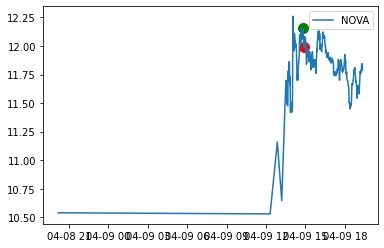

now=2020-04-09 10:19:03.796950
                              open     high      low    close  volume
timestamp                                                            
2020-03-30 09:30:00-04:00  13.9100  13.9100  13.9100  13.9100    5526
2020-03-30 09:33:00-04:00  13.6912  13.6912  13.6912  13.6912     272
2020-03-30 09:34:00-04:00  13.9100  14.1300  13.9100  14.0200     959
2020-03-30 09:35:00-04:00  14.0400  14.0400  14.0400  14.0400     108
2020-03-30 09:36:00-04:00  13.9244  13.9244  13.9244  13.9244     334
...                            ...      ...      ...      ...     ...
2020-04-09 15:17:00-04:00  15.0550  15.0700  15.0500  15.0500    4268
2020-04-09 15:18:00-04:00  15.0300  15.0400  15.0300  15.0400     437
2020-04-09 15:19:00-04:00  15.0300  15.0600  15.0000  15.0150     996
2020-04-09 15:20:00-04:00  15.0300  15.0300  14.9900  15.0050    1906
2020-04-09 15:21:00-04:00  15.0000  15.0100  14.9900  15.0000    2441

[2889 rows x 5 columns]
index:2658 data:15.265
start
Serie

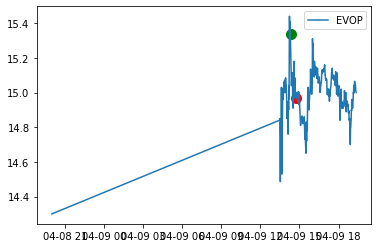

now=2020-04-09 10:06:15.651718
                             open  high   low   close  volume
timestamp                                                    
2020-03-30 07:02:00-04:00  5.3100  5.31  5.31  5.3100     223
2020-03-30 08:26:00-04:00  5.3000  5.30  5.30  5.3000     256
2020-03-30 08:27:00-04:00  5.3000  5.30  5.30  5.3000     137
2020-03-30 08:36:00-04:00  5.2000  5.20  5.20  5.2000     607
2020-03-30 09:30:00-04:00  5.2700  5.31  5.18  5.3100   26957
...                           ...   ...   ...     ...     ...
2020-04-09 15:17:00-04:00  6.1000  6.11  6.10  6.1099    3200
2020-04-09 15:18:00-04:00  6.1100  6.11  6.10  6.1000     484
2020-04-09 15:19:00-04:00  6.0996  6.10  6.09  6.1000    8222
2020-04-09 15:20:00-04:00  6.1000  6.11  6.07  6.0710   17796
2020-04-09 15:21:00-04:00  6.0600  6.06  6.02  6.0200   12694

[3244 rows x 5 columns]
index:2953 data:6.09
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)

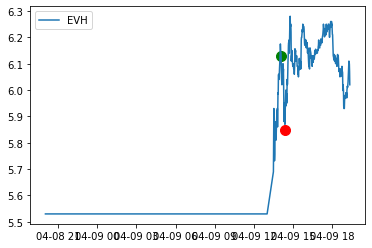

now=2020-04-09 10:43:45.574810
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:30:00-04:00  3.3000  3.3000  3.1887  3.1887    3796
2020-03-30 09:31:00-04:00  3.2500  3.2500  3.1808  3.1808    2290
2020-03-30 09:32:00-04:00  3.1975  3.2500  3.1975  3.2500     310
2020-03-30 09:33:00-04:00  3.2050  3.2110  3.2050  3.2110     415
2020-03-30 09:34:00-04:00  3.1800  3.1800  3.1800  3.1800     265
...                           ...     ...     ...     ...     ...
2020-04-09 15:17:00-04:00  2.5000  2.5045  2.4900  2.4901    7553
2020-04-09 15:18:00-04:00  2.5000  2.5500  2.5000  2.5500    6717
2020-04-09 15:19:00-04:00  2.5500  2.5500  2.5500  2.5500     188
2020-04-09 15:20:00-04:00  2.5400  2.5400  2.5200  2.5350    8300
2020-04-09 15:21:00-04:00  2.5300  2.5300  2.5200  2.5200    1981

[3096 rows x 5 columns]
index:2831 data:2.37
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

local_maximas=[]
start
timestamp
2020-04-03 10:20:00-04:00    1.3900
2020-04-03 10:25:00-04:00    1.3950
2020-04-03 10:30:00-04:00    1.3950
2020-04-03 10:35:00-04:00    1.3900
2020-04-03 10:40:00-04:00    1.3975
2020-04-03 10:45:00-04:00    1.3901
2020-04-03 10:50:00-04:00    1.3900
2020-04-03 10:55:00-04:00    1.3850
2020-04-03 11:00:00-04:00    1.3501
2020-04-03 11:05:00-04:00    1.3500
Name: close, dtype: float64
[ 5.000e-03  0.000e+00 -5.000e-03  7.500e-03 -7.400e-03 -1.000e-04
 -5.000e-03 -3.490e-02 -1.000e-04 -1.000e-02 -4.000e-02 -1.430e-02
 -5.700e-03  5.000e-03  4.450e-02  6.050e-02 -4.000e-02 -1.150e-02
 -8.500e-03 -1.000e-02  0.000e+00  0.000e+00 -1.500e-02  4.200e-03
 -4.200e-03  2.500e-02  0.000e+00  3.000e-02  2.000e-02  1.000e-02
  0.000e+00 -1.000e-02  0.000e+00 -5.000e-03  0.000e+00  0.000e+00
  2.600e-03  2.400e-03 -9.900e-03 -1.510e-02  0.000e+00 -5.000e-03
  1.000e-02 -1.000e-02  1.000e-02 -5.000e-03 -2.500e-02 -1.500e-02
  1.500e-02  1.000e-02  5.000e-03  5.000e-0

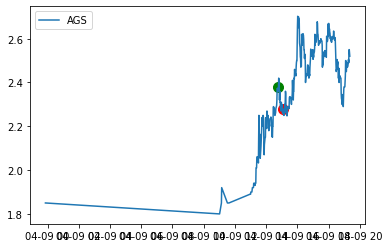

now=2020-04-09 10:38:13.746242
                             open  high   low   close  volume
timestamp                                                    
2020-03-30 05:10:00-04:00  1.5200  1.52  1.52  1.5200     271
2020-03-30 07:00:00-04:00  1.4900  1.49  1.49  1.4900    1500
2020-03-30 07:39:00-04:00  1.4500  1.45  1.41  1.4100     670
2020-03-30 08:00:00-04:00  1.4900  1.49  1.41  1.4500    4907
2020-03-30 08:02:00-04:00  1.4100  1.41  1.40  1.4100    4000
...                           ...   ...   ...     ...     ...
2020-04-09 15:17:00-04:00  2.2350  2.24  2.23  2.2344   14078
2020-04-09 15:18:00-04:00  2.2381  2.24  2.23  2.2300   10663
2020-04-09 15:19:00-04:00  2.2349  2.24  2.22  2.2200   32189
2020-04-09 15:20:00-04:00  2.2300  2.23  2.20  2.2050   27342
2020-04-09 15:21:00-04:00  2.2000  2.21  2.19  2.2000   12156

[4149 rows x 5 columns]
index:3865 data:2.48
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)

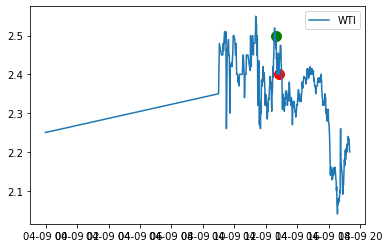

now=2020-04-09 10:46:50.461133
                           open    high   low  close  volume
timestamp                                                   
2020-03-30 08:25:00-04:00  7.99  7.9900  7.99   7.99     200
2020-03-30 08:45:00-04:00  7.99  7.9900  7.99   7.99     200
2020-03-30 08:56:00-04:00  7.99  7.9900  7.99   7.99     100
2020-03-30 08:57:00-04:00  7.99  7.9900  7.99   7.99     100
2020-03-30 09:30:00-04:00  8.00  8.1000  7.95   8.10   29286
...                         ...     ...   ...    ...     ...
2020-04-09 15:17:00-04:00  9.51  9.5250  9.50   9.51    2352
2020-04-09 15:18:00-04:00  9.51  9.5100  9.48   9.48    1065
2020-04-09 15:19:00-04:00  9.47  9.4716  9.44   9.44    3065
2020-04-09 15:20:00-04:00  9.46  9.4850  9.44   9.45    3927
2020-04-09 15:21:00-04:00  9.46  9.4700  9.43   9.44    1827

[3455 rows x 5 columns]
index:3181 data:9.87
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start


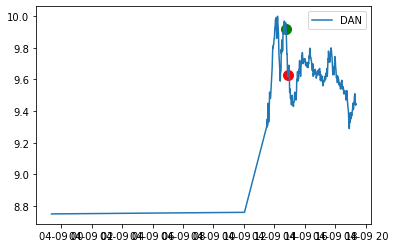

now=2020-04-09 10:36:24.718566
                           open   high     low  close    volume
timestamp                                                      
2020-03-30 04:00:00-04:00  7.59  7.590  7.5900  7.590     707.0
2020-03-30 04:01:00-04:00  7.59  7.600  7.5900  7.600     750.0
2020-03-30 04:14:00-04:00  7.60  7.610  7.6000  7.610     450.0
2020-03-30 04:17:00-04:00  7.76  7.770  7.7600  7.770     500.0
2020-03-30 04:18:00-04:00  7.64  7.640  7.6400  7.640     300.0
...                         ...    ...     ...    ...       ...
2020-04-09 15:17:00-04:00  9.77  9.775  9.7300  9.730   97562.0
2020-04-09 15:18:00-04:00  9.73  9.740  9.6599  9.680  157160.0
2020-04-09 15:19:00-04:00  9.68  9.710  9.6600  9.710   78814.0
2020-04-09 15:20:00-04:00  9.72  9.730  9.6300  9.640  146540.0
2020-04-09 15:21:00-04:00  9.65  9.660  9.6200  9.645  206438.0

[5418 rows x 5 columns]
index:5132 data:9.755
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, N

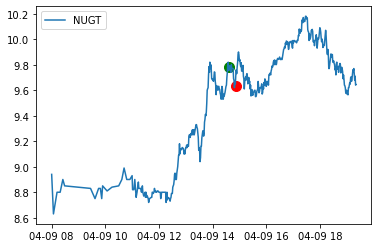

now=2020-04-09 09:57:31.098058
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 08:00:00-04:00  2.3001  2.3999  2.3001  2.3999    1395
2020-03-30 09:04:00-04:00  2.3000  2.3000  2.3000  2.3000    1000
2020-03-30 09:30:00-04:00  2.3400  2.3600  2.3400  2.3600   30322
2020-03-30 09:32:00-04:00  2.3700  2.3700  2.3500  2.3500     483
2020-03-30 09:33:00-04:00  2.3400  2.3400  2.3200  2.3200    2132
...                           ...     ...     ...     ...     ...
2020-04-09 15:17:00-04:00  2.4500  2.4500  2.4450  2.4450    5725
2020-04-09 15:18:00-04:00  2.4400  2.4450  2.4400  2.4450    1375
2020-04-09 15:19:00-04:00  2.4400  2.4450  2.4400  2.4400     587
2020-04-09 15:20:00-04:00  2.4500  2.4600  2.4500  2.4600    1754
2020-04-09 15:21:00-04:00  2.4500  2.4500  2.4500  2.4500    2896

[3191 rows x 5 columns]
index:2914 data:2.61
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

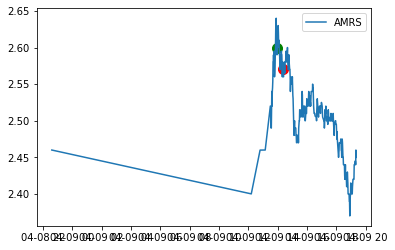

now=2020-04-09 10:00:44.495230
                              open     high     low  close  volume
timestamp                                                         
2020-03-30 09:13:00-04:00  12.1000  12.1000  12.100  12.10     100
2020-03-30 09:30:00-04:00  14.4300  14.5200  14.300  14.30   18207
2020-03-30 09:31:00-04:00  14.5800  14.5800  14.580  14.58     845
2020-03-30 09:32:00-04:00  14.5600  14.5600  14.200  14.21  104892
2020-03-30 09:33:00-04:00  14.2000  14.2100  13.840  13.84    1443
...                            ...      ...     ...    ...     ...
2020-04-09 15:17:00-04:00  12.8000  12.8300  12.790  12.82    8044
2020-04-09 15:18:00-04:00  12.7900  12.8200  12.790  12.79    7660
2020-04-09 15:19:00-04:00  12.7900  12.8200  12.760  12.82    8314
2020-04-09 15:20:00-04:00  12.8200  12.9031  12.740  12.77   38040
2020-04-09 15:21:00-04:00  12.7575  12.7800  12.745  12.75   11004

[3255 rows x 5 columns]
index:2947 data:13.38
start
Series([], Freq: 5T, Name: close, dtype: floa

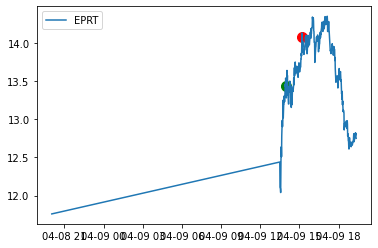

now=2020-04-09 10:31:04.845717
                            open   high     low  close  volume
timestamp                                                     
2020-03-30 08:37:00-04:00   9.90   9.90   9.900   9.90     400
2020-03-30 09:30:00-04:00   9.80   9.80   9.630   9.65   46997
2020-03-30 09:31:00-04:00   9.67   9.68   9.670   9.68     251
2020-03-30 09:32:00-04:00   9.68   9.71   9.620   9.62    8200
2020-03-30 09:33:00-04:00   9.53   9.56   9.510   9.56    5801
...                          ...    ...     ...    ...     ...
2020-04-09 15:17:00-04:00  11.26  11.28  11.260  11.28    4221
2020-04-09 15:18:00-04:00  11.28  11.28  11.245  11.25    5274
2020-04-09 15:19:00-04:00  11.24  11.24  11.220  11.22    3712
2020-04-09 15:20:00-04:00  11.24  11.25  11.220  11.22    2890
2020-04-09 15:21:00-04:00  11.21  11.21  11.180  11.20    9483

[3522 rows x 5 columns]
index:3231 data:11.32
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, d

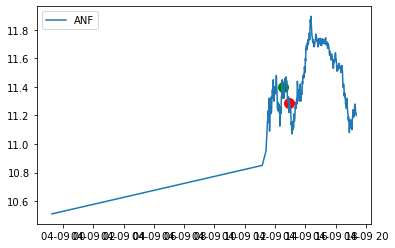

now=2020-04-09 10:36:52.798816
                            open    high   low   close  volume
timestamp                                                     
2020-03-30 04:00:00-04:00  2.990  2.9900  2.99  2.9900     478
2020-03-30 05:12:00-04:00  2.940  2.9500  2.94  2.9500    1022
2020-03-30 06:40:00-04:00  2.950  2.9500  2.95  2.9500     900
2020-03-30 07:00:00-04:00  2.860  2.9700  2.86  2.9700     500
2020-03-30 07:01:00-04:00  2.950  2.9500  2.95  2.9500     700
...                          ...     ...   ...     ...     ...
2020-04-09 15:17:00-04:00  3.650  3.6500  3.64  3.6458   19978
2020-04-09 15:18:00-04:00  3.650  3.6500  3.62  3.6200   99594
2020-04-09 15:19:00-04:00  3.625  3.6300  3.62  3.6300   22420
2020-04-09 15:20:00-04:00  3.630  3.6358  3.61  3.6157   67835
2020-04-09 15:21:00-04:00  3.620  3.6200  3.61  3.6200   29247

[4034 rows x 5 columns]
index:3749 data:3.655
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, d

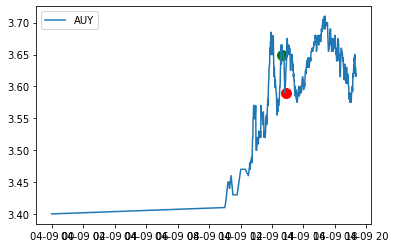

now=2020-04-09 10:35:18.111538
                            open   high    low  close    volume
timestamp                                                      
2020-03-30 04:09:00-04:00  6.350  6.350  6.350  6.350     150.0
2020-03-30 04:25:00-04:00  6.310  6.310  6.310  6.310     100.0
2020-03-30 04:28:00-04:00  6.140  6.140  6.140  6.140     282.0
2020-03-30 04:34:00-04:00  6.170  6.170  6.170  6.170     500.0
2020-03-30 05:00:00-04:00  6.340  6.340  6.340  6.340     450.0
...                          ...    ...    ...    ...       ...
2020-04-09 15:17:00-04:00  8.345  8.370  8.340  8.360   90566.0
2020-04-09 15:18:00-04:00  8.360  8.360  8.285  8.290  124307.0
2020-04-09 15:19:00-04:00  8.290  8.300  8.280  8.285   69334.0
2020-04-09 15:20:00-04:00  8.285  8.315  8.255  8.260  182068.0
2020-04-09 15:21:00-04:00  8.265  8.290  8.200  8.200  240147.0

[5232 rows x 5 columns]
index:4945 data:9.4899
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, 

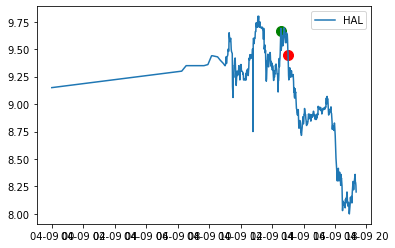

now=2020-04-09 10:51:05.764339
                              open     high      low    close  volume
timestamp                                                            
2020-03-30 09:30:00-04:00   9.8600   9.8600   9.5006   9.5006    5600
2020-03-30 09:31:00-04:00   9.5600   9.5600   9.5600   9.5600     585
2020-03-30 09:33:00-04:00   9.6800   9.6800   9.6700   9.6800     404
2020-03-30 09:34:00-04:00   9.6864   9.6864   9.5000   9.5000    4058
2020-03-30 09:35:00-04:00   9.5000   9.5000   9.5000   9.5000    1392
...                            ...      ...      ...      ...     ...
2020-04-09 15:16:00-04:00  15.2100  15.2100  15.2100  15.2100     200
2020-04-09 15:17:00-04:00  15.2500  15.2500  15.2500  15.2500     100
2020-04-09 15:19:00-04:00  15.2000  15.2400  15.2000  15.2400     537
2020-04-09 15:20:00-04:00  15.2400  15.3500  15.2400  15.3500    1718
2020-04-09 15:21:00-04:00  15.3100  15.3600  15.2800  15.3200    1784

[2396 rows x 5 columns]
index:2198 data:16.41
start
timest

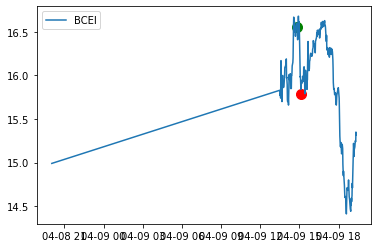

now=2020-04-09 10:46:41.409350
                              open     high      low    close  volume
timestamp                                                            
2020-03-30 07:20:00-04:00  12.6100  12.6100  12.6000  12.6000     849
2020-03-30 07:22:00-04:00  12.6000  12.6000  12.6000  12.6000     151
2020-03-30 08:00:00-04:00  12.6000  12.8398  12.6000  12.8001    1300
2020-03-30 08:16:00-04:00  12.9098  12.9098  12.9098  12.9098     300
2020-03-30 08:17:00-04:00  12.9000  12.9000  12.9000  12.9000     250
...                            ...      ...      ...      ...     ...
2020-04-09 15:17:00-04:00  15.2200  15.2700  15.2200  15.2700   16216
2020-04-09 15:18:00-04:00  15.2500  15.3058  15.1400  15.1400   30706
2020-04-09 15:19:00-04:00  15.1600  15.1800  15.0957  15.1400   17162
2020-04-09 15:20:00-04:00  15.1500  15.1900  15.1500  15.1500   13998
2020-04-09 15:21:00-04:00  15.1500  15.1500  15.0000  15.0000   84566

[3628 rows x 5 columns]
index:3353 data:15.19
start
Series

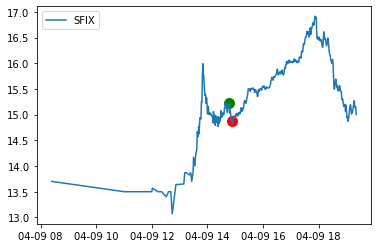

now=2020-04-09 09:51:26.234511
                            open   high   low  close  volume
timestamp                                                   
2020-03-30 07:00:00-04:00  8.000  8.000  8.00  8.000     250
2020-03-30 07:12:00-04:00  8.300  8.300  8.30  8.300     500
2020-03-30 08:34:00-04:00  8.300  8.300  8.30  8.300   18300
2020-03-30 08:59:00-04:00  8.310  8.310  8.31  8.310    3346
2020-03-30 09:28:00-04:00  8.350  8.350  8.35  8.350     207
...                          ...    ...   ...    ...     ...
2020-04-09 15:18:00-04:00  8.980  8.990  8.96  8.960   20817
2020-04-09 15:19:00-04:00  8.960  8.970  8.95  8.965   69853
2020-04-09 15:20:00-04:00  8.970  9.005  8.97  8.975   37698
2020-04-09 15:21:00-04:00  8.980  8.980  8.94  8.950   31474
2020-04-09 15:22:00-04:00  8.945  8.980  8.94  8.945   51088

[3618 rows x 5 columns]
index:3286 data:9.455
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start

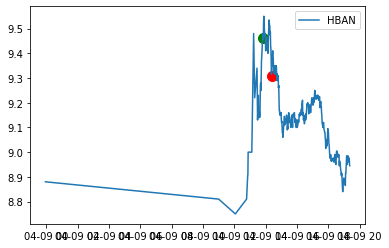

now=2020-04-09 10:36:24.410971
                           open  high     low   close  volume
timestamp                                                    
2020-03-30 09:30:00-04:00  7.97  7.97  7.8500  7.8600   46663
2020-03-30 09:31:00-04:00  8.04  8.04  7.8900  7.9000    2889
2020-03-30 09:32:00-04:00  7.98  7.98  7.8900  7.9302   11466
2020-03-30 09:33:00-04:00  7.97  7.97  7.7800  7.7800    1884
2020-03-30 09:34:00-04:00  7.80  7.82  7.7799  7.8200    7330
...                         ...   ...     ...     ...     ...
2020-04-09 15:18:00-04:00  7.21  7.21  7.2000  7.2000    1929
2020-04-09 15:19:00-04:00  7.19  7.23  7.1900  7.2300    1328
2020-04-09 15:20:00-04:00  7.24  7.24  7.2300  7.2350    2181
2020-04-09 15:21:00-04:00  7.23  7.25  7.2300  7.2400    1908
2020-04-09 15:22:00-04:00  7.22  7.22  7.2200  7.2200     100

[3198 rows x 5 columns]
index:2938 data:7.55
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)

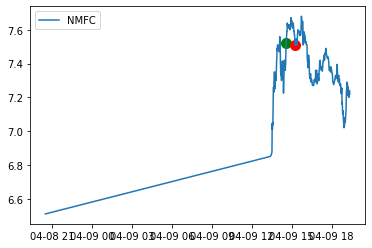

now=2020-04-09 10:46:30.276637
                            open  high    low  close  volume
timestamp                                                   
2020-03-30 07:35:00-04:00  2.280  2.28  2.280  2.280     300
2020-03-30 07:50:00-04:00  2.440  2.45  2.440  2.450     600
2020-03-30 08:49:00-04:00  2.450  2.45  2.450  2.450    1000
2020-03-30 08:50:00-04:00  2.450  2.45  2.450  2.450    2000
2020-03-30 08:51:00-04:00  2.450  2.45  2.450  2.450    1000
...                          ...   ...    ...    ...     ...
2020-04-09 15:18:00-04:00  2.850  2.85  2.840  2.845   11271
2020-04-09 15:19:00-04:00  2.840  2.85  2.840  2.850    2587
2020-04-09 15:20:00-04:00  2.845  2.85  2.845  2.850     650
2020-04-09 15:21:00-04:00  2.840  2.85  2.840  2.840   10141
2020-04-09 15:22:00-04:00  2.840  2.84  2.840  2.840     565

[2941 rows x 5 columns]
index:2697 data:2.8
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
timestamp
2020-04-09 10:30:00-04:00    2.7700
2020-04-09 10:35:

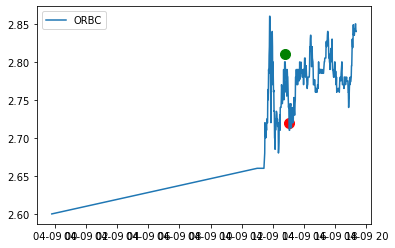

now=2020-04-09 10:30:42.104706
                            open  high    low  close  volume
timestamp                                                   
2020-03-30 07:00:00-04:00  8.850  8.85  8.850  8.850     300
2020-03-30 08:40:00-04:00  8.810  8.81  8.810  8.810     100
2020-03-30 09:30:00-04:00  8.740  8.86  8.570  8.830   55726
2020-03-30 09:31:00-04:00  8.840  8.84  8.690  8.710    7310
2020-03-30 09:32:00-04:00  8.690  8.77  8.680  8.760    3061
...                          ...   ...    ...    ...     ...
2020-04-09 15:18:00-04:00  9.070  9.07  9.060  9.060    9172
2020-04-09 15:19:00-04:00  9.060  9.07  9.040  9.060   12336
2020-04-09 15:20:00-04:00  9.070  9.09  9.065  9.070   22146
2020-04-09 15:21:00-04:00  9.075  9.08  9.050  9.050    9046
2020-04-09 15:22:00-04:00  9.060  9.08  9.060  9.065    9492

[3476 rows x 5 columns]
index:3184 data:9.39
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start


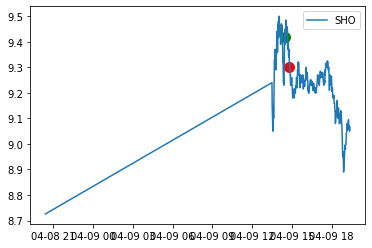

now=2020-04-09 11:01:13.290195
                             open  high     low   close   volume
timestamp                                                       
2020-03-30 07:30:00-04:00  3.1000  3.56  3.1000  3.4900   9609.0
2020-03-30 07:31:00-04:00  3.4500  3.48  3.3600  3.4500   2476.0
2020-03-30 07:32:00-04:00  3.4200  3.43  3.4200  3.4300   1696.0
2020-03-30 07:33:00-04:00  3.4500  3.58  3.4500  3.5800   2324.0
2020-03-30 07:34:00-04:00  3.6800  3.70  3.6800  3.7000   1100.0
...                           ...   ...     ...     ...      ...
2020-04-09 15:18:00-04:00  6.8202  6.85  6.7902  6.8496  21452.0
2020-04-09 15:19:00-04:00  6.8300  6.84  6.8150  6.8325  12324.0
2020-04-09 15:20:00-04:00  6.8300  6.84  6.8120  6.8250   4660.0
2020-04-09 15:21:00-04:00  6.8310  6.86  6.8200  6.8600  18608.0
2020-04-09 15:22:00-04:00  6.8600  7.00  6.8555  6.9750  53706.0

[2947 rows x 5 columns]
index:2685 data:7.28
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([],

local_maximas=[]
start
timestamp
2020-04-03 10:30:00-04:00    3.2400
2020-04-03 10:35:00-04:00    3.2400
2020-04-03 10:40:00-04:00    3.2239
2020-04-03 10:45:00-04:00    3.2400
2020-04-03 10:50:00-04:00    3.2200
2020-04-03 10:55:00-04:00    3.2200
2020-04-03 11:00:00-04:00    3.2201
2020-04-03 11:05:00-04:00    3.2200
2020-04-03 11:10:00-04:00    3.1600
2020-04-03 11:15:00-04:00    3.1339
Name: close, dtype: float64
[ 0.000e+00 -1.610e-02  1.610e-02 -2.000e-02  0.000e+00  1.000e-04
 -1.000e-04 -6.000e-02 -2.610e-02 -1.890e-02  5.500e-02 -2.000e-02
  0.000e+00  0.000e+00  1.000e-02 -1.000e-02 -5.500e-03  5.400e-03
 -2.990e-02  4.000e-02 -2.000e-02  3.300e-03 -3.300e-03  0.000e+00
  2.000e-02 -1.000e-04 -9.900e-03 -5.000e-03 -5.000e-03  1.000e-02
 -1.000e-02 -4.000e-02  0.000e+00  3.000e-02  3.000e-02 -1.000e-02
 -1.000e-02  1.660e-02 -6.600e-03  0.000e+00 -5.200e-03 -4.800e-03
  2.000e-02 -1.000e-02  0.000e+00 -1.000e-02 -1.000e-02  2.000e-02
  0.000e+00  1.000e-02  1.000e-01 -3.000e-0

local_maximas=[]
start
timestamp
2020-03-30 13:30:00-04:00    3.2400
2020-03-30 13:35:00-04:00    3.2362
2020-03-30 13:40:00-04:00    3.2400
2020-03-30 13:45:00-04:00    3.2400
2020-03-30 13:50:00-04:00    3.2374
2020-03-30 13:55:00-04:00    3.2358
2020-03-30 14:05:00-04:00    3.2300
2020-03-30 14:10:00-04:00    3.2300
2020-03-30 14:15:00-04:00    3.2250
2020-03-30 14:20:00-04:00    3.2300
Name: close, dtype: float64
[-3.800e-03  3.800e-03  0.000e+00 -2.600e-03 -1.600e-03 -5.800e-03
  0.000e+00 -5.000e-03  5.000e-03 -5.000e-03  0.000e+00  5.750e-01
  8.000e-01  1.000e-01  2.900e-01 -4.450e-01 -3.750e-01 -1.300e-01
 -1.562e-01  1.862e-01  5.990e-02  2.601e-01 -2.000e-02 -1.401e-01
 -2.990e-02 -6.000e-02  0.000e+00  0.000e+00  6.000e-02  5.000e-02
  1.000e-02 -9.000e-02 -2.000e-02  0.000e+00  0.000e+00  4.000e-02
  0.000e+00  2.000e-02 -3.000e-02  5.000e-02 -3.000e-02 -5.000e-02
  5.000e-02  0.000e+00  0.000e+00  1.000e-02 -5.990e-02 -9.010e-02
  0.000e+00  8.000e-02  2.000e-01 -2.000e-0

local_maximas=[]
start
timestamp
2020-03-30 10:40:00-04:00    3.1500
2020-03-30 10:45:00-04:00    3.1500
2020-03-30 10:50:00-04:00    3.1584
2020-03-30 10:55:00-04:00    3.1600
2020-03-30 11:00:00-04:00    3.1599
2020-03-30 11:05:00-04:00    3.1699
2020-03-30 11:10:00-04:00    3.1670
2020-03-30 11:15:00-04:00    3.1700
2020-03-30 11:20:00-04:00    3.1640
2020-03-30 11:25:00-04:00    3.1699
Name: close, dtype: float64
[ 0.000e+00  8.400e-03  1.600e-03 -1.000e-04  1.000e-02 -2.900e-03
  3.000e-03 -6.000e-03  5.900e-03  1.010e-02 -1.000e-02 -4.100e-03
  4.000e-03  1.000e-04 -1.800e-03  3.000e-04 -3.500e-03  2.100e-03
 -6.900e-03  9.800e-03 -1.980e-02 -2.000e-04  2.000e-02 -1.100e-02
  6.800e-03  4.200e-03 -2.000e-03 -7.900e-03  5.990e-02  1.000e-02
  3.000e-02 -2.000e-02 -3.800e-03  3.800e-03  0.000e+00 -2.600e-03
 -1.600e-03 -5.800e-03  0.000e+00 -5.000e-03  5.000e-03 -5.000e-03
  0.000e+00  5.750e-01  8.000e-01  1.000e-01  2.900e-01 -4.450e-01
 -3.750e-01 -1.300e-01 -1.562e-01  1.862e-0

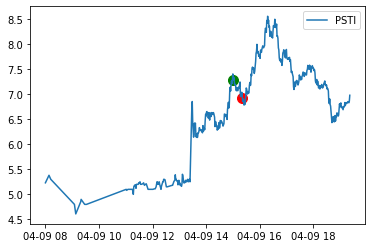

now=2020-04-09 10:18:55.636119
                              open    high      low   close  volume
timestamp                                                          
2020-03-30 08:34:00-04:00  16.8300  16.830  16.8300  16.830    2887
2020-03-30 09:29:00-04:00  16.8000  16.800  16.8000  16.800     100
2020-03-30 09:30:00-04:00  16.8200  16.940  16.6500  16.845   11252
2020-03-30 09:31:00-04:00  16.8438  16.890  16.7700  16.830    6690
2020-03-30 09:32:00-04:00  16.8550  16.855  16.7300  16.830   10393
...                            ...     ...      ...     ...     ...
2020-04-09 15:18:00-04:00  18.5700  18.570  18.5450  18.545    2195
2020-04-09 15:19:00-04:00  18.5450  18.545  18.5179  18.520    1336
2020-04-09 15:20:00-04:00  18.5300  18.540  18.5100  18.510    3287
2020-04-09 15:21:00-04:00  18.5100  18.510  18.4700  18.500    4128
2020-04-09 15:22:00-04:00  18.4900  18.520  18.4900  18.500    4518

[3485 rows x 5 columns]
index:3181 data:18.95
start
Series([], Freq: 5T, Name: close

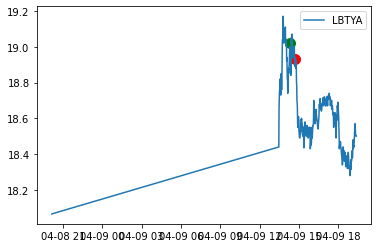

now=2020-04-09 10:42:29.933815
                            open    high      low  close  volume
timestamp                                                       
2020-03-30 09:21:00-04:00   9.57   9.570   9.5700   9.57     100
2020-03-30 09:29:00-04:00   9.16   9.160   9.1600   9.16     263
2020-03-30 09:30:00-04:00   9.16   9.160   8.9032   9.07   30852
2020-03-30 09:31:00-04:00   9.00   9.115   9.0000   9.08    1225
2020-03-30 09:32:00-04:00   9.16   9.220   9.1300   9.22    2146
...                          ...     ...      ...    ...     ...
2020-04-09 15:18:00-04:00  12.83  12.830  12.7000  12.70    4563
2020-04-09 15:19:00-04:00  12.70  12.760  12.7000  12.76    3344
2020-04-09 15:20:00-04:00  12.78  12.800  12.7400  12.74    4550
2020-04-09 15:21:00-04:00  12.74  12.740  12.7000  12.74    4395
2020-04-09 15:22:00-04:00  12.74  12.770  12.7400  12.76    3347

[3490 rows x 5 columns]
index:3209 data:12.46
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([]

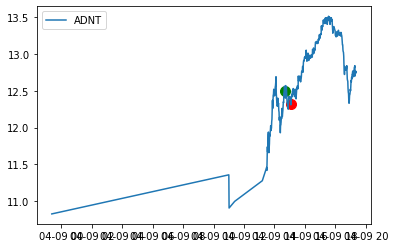

now=2020-04-09 10:36:24.534077
                             open    high    low  close  volume
timestamp                                                      
2020-03-30 05:24:00-04:00  5.7600  5.7600  5.760  5.760     116
2020-03-30 07:00:00-04:00  5.7400  5.7400  5.740  5.740     100
2020-03-30 07:02:00-04:00  5.6500  5.6500  5.600  5.650    1290
2020-03-30 07:44:00-04:00  5.7200  5.7200  5.720  5.720     190
2020-03-30 07:47:00-04:00  5.7000  5.7000  5.700  5.700     396
...                           ...     ...    ...    ...     ...
2020-04-09 15:18:00-04:00  6.8050  6.8100  6.780  6.780   71992
2020-04-09 15:19:00-04:00  6.7850  6.8000  6.774  6.775  191322
2020-04-09 15:20:00-04:00  6.7750  6.7855  6.745  6.745  138111
2020-04-09 15:21:00-04:00  6.7401  6.8100  6.740  6.770  106593
2020-04-09 15:22:00-04:00  6.7700  6.8100  6.770  6.780   42676

[4364 rows x 5 columns]
index:4077 data:7.1501
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, 

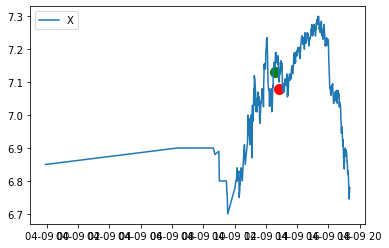

now=2020-04-09 10:36:01.018746
                              open   high    low   close   volume
timestamp                                                        
2020-03-30 04:46:00-04:00  13.5900  13.59  13.59  13.590    150.0
2020-03-30 05:02:00-04:00  13.4100  13.41  13.41  13.410    645.0
2020-03-30 05:03:00-04:00  13.4100  13.41  13.41  13.410    204.0
2020-03-30 05:04:00-04:00  13.5000  13.50  13.50  13.500    157.0
2020-03-30 05:08:00-04:00  13.5100  13.51  13.51  13.510    839.0
...                            ...    ...    ...     ...      ...
2020-04-09 15:18:00-04:00  16.5600  16.56  16.42  16.420  92612.0
2020-04-09 15:19:00-04:00  16.4100  16.44  16.39  16.435  58290.0
2020-04-09 15:20:00-04:00  16.4400  16.51  16.44  16.450  98470.0
2020-04-09 15:21:00-04:00  16.4600  16.46  16.37  16.380  66656.0
2020-04-09 15:22:00-04:00  16.3854  16.44  16.36  16.365  68042.0

[4494 rows x 5 columns]
index:4207 data:18.45
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
st

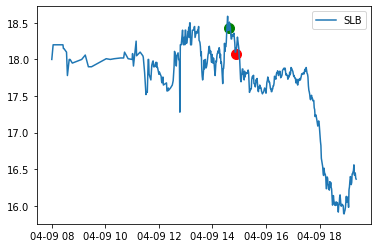

now=2020-04-09 10:43:27.868901
                            open   high    low  close  volume
timestamp                                                    
2020-03-30 09:30:00-04:00  8.920  8.940  8.900  8.910   21572
2020-03-30 09:31:00-04:00  8.910  8.910  8.780  8.785    4880
2020-03-30 09:32:00-04:00  8.800  8.800  8.760  8.790     801
2020-03-30 09:33:00-04:00  8.785  8.785  8.725  8.725     403
2020-03-30 09:34:00-04:00  8.690  8.780  8.690  8.780     403
...                          ...    ...    ...    ...     ...
2020-04-09 15:18:00-04:00  9.620  9.620  9.575  9.590   11014
2020-04-09 15:19:00-04:00  9.590  9.610  9.580  9.610    4380
2020-04-09 15:20:00-04:00  9.630  9.650  9.610  9.610    5880
2020-04-09 15:21:00-04:00  9.620  9.660  9.560  9.560   82562
2020-04-09 15:22:00-04:00  9.570  9.650  9.570  9.590   66574

[3379 rows x 5 columns]
index:3106 data:9.77
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
start
Series([], Freq: 5T, Name: close, dtype: float64)

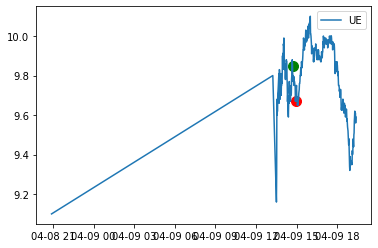

now=2020-04-09 10:35:18.240913
                              open     high      low    close  volume
timestamp                                                            
2020-03-30 08:00:00-04:00   9.7500   9.9399   9.7500   9.9399    1790
2020-03-30 08:08:00-04:00   9.8000   9.8000   9.8000   9.8000     100
2020-03-30 08:34:00-04:00   9.9000   9.9000   9.9000   9.9000    6359
2020-03-30 08:57:00-04:00   9.9399   9.9399   9.9399   9.9399     250
2020-03-30 08:59:00-04:00   9.9399   9.9399   9.9399   9.9399    1000
...                            ...      ...      ...      ...     ...
2020-04-09 15:18:00-04:00  12.9100  12.9100  12.8700  12.8850   23980
2020-04-09 15:19:00-04:00  12.8850  12.8850  12.8600  12.8700   15107
2020-04-09 15:20:00-04:00  12.8800  12.9150  12.8750  12.8900   13858
2020-04-09 15:21:00-04:00  12.8900  12.9050  12.8600  12.8600   20418
2020-04-09 15:22:00-04:00  12.8600  12.8750  12.8300  12.8300    9487

[3629 rows x 5 columns]
index:3341 data:13.02
start
Series

 -8.500e-02  8.500e-02 -5.000e-02 -1.000e-01  7.000e-02  1.100e-01]
[  1   2   6   8  11  20  25  31  33  36  38  41  48  51  54  61  63  68
  76  79  83  86  91  94 100 108 113 116 118 120 125 131 133 138 140 143
 146 148 153 155 158 159 163 166 169 173 176 178 182 184 189 196 199 202
 210 211 212 216 219 223 226 229 231 238 242 247 249 251 254 257 259 260
 263 268 271 277 284 285 287 289 291 295 296 297 303 310 313 315 318 325
 327 330 332 335 336 345 347 350]
local_maximas=[]
start
timestamp
2020-04-03 10:00:00-04:00    10.120
2020-04-03 10:05:00-04:00    10.130
2020-04-03 10:10:00-04:00    10.100
2020-04-03 10:15:00-04:00    10.020
2020-04-03 10:20:00-04:00     9.935
2020-04-03 10:25:00-04:00     9.920
2020-04-03 10:30:00-04:00     9.880
2020-04-03 10:35:00-04:00     9.740
2020-04-03 10:40:00-04:00     9.770
2020-04-03 10:45:00-04:00     9.855
Name: close, dtype: float64
[ 1.000e-02 -3.000e-02 -8.000e-02 -8.500e-02 -1.500e-02 -4.000e-02
 -1.400e-01  3.000e-02  8.500e-02  5.580e-02 

timestamp
2020-04-02 14:40:00-04:00    9.7400
2020-04-02 14:45:00-04:00    9.7250
2020-04-02 14:50:00-04:00    9.7800
2020-04-02 14:55:00-04:00    9.8100
2020-04-02 15:00:00-04:00    9.8100
2020-04-02 15:05:00-04:00    9.7750
2020-04-02 15:10:00-04:00    9.7701
2020-04-02 15:15:00-04:00    9.8150
2020-04-02 15:20:00-04:00    9.8150
2020-04-02 15:25:00-04:00    9.8150
Name: close, dtype: float64
[-1.500e-02  5.500e-02  3.000e-02  0.000e+00 -3.500e-02 -4.900e-03
  4.490e-02  0.000e+00  0.000e+00 -1.500e-02 -7.000e-02  5.500e-02
 -5.000e-03  1.000e-02  1.000e-01 -7.000e-02  0.000e+00 -2.000e-02
  3.000e-02  5.000e-02  0.000e+00  0.000e+00  0.000e+00  1.100e-01
  0.000e+00  6.000e-02  8.000e-02  1.150e-01 -2.500e-02 -1.050e-01
  2.000e-02  2.500e-02 -3.000e-02 -3.000e-02 -8.000e-02 -8.500e-02
 -1.500e-02 -4.000e-02 -1.400e-01  3.000e-02  8.500e-02  5.580e-02
 -2.080e-02  3.350e-02 -3.500e-03  0.000e+00 -3.000e-02 -4.000e-02
 -4.000e-02  6.500e-02 -5.000e-03  2.000e-02 -8.000e-02  1.000e-02

local_maximas=[]
start
timestamp
2020-03-31 13:25:00-04:00    10.6050
2020-03-31 13:30:00-04:00    10.6400
2020-03-31 13:35:00-04:00    10.6200
2020-03-31 13:40:00-04:00    10.6400
2020-03-31 13:45:00-04:00    10.6500
2020-03-31 13:50:00-04:00    10.6300
2020-03-31 13:55:00-04:00    10.6250
2020-03-31 14:00:00-04:00    10.6450
2020-03-31 14:05:00-04:00    10.6950
2020-03-31 14:10:00-04:00    10.7301
Name: close, dtype: float64
[ 3.500e-02 -2.000e-02  2.000e-02  1.000e-02 -2.000e-02 -5.000e-03
  2.000e-02  5.000e-02  3.510e-02  9.900e-03  1.000e-02  5.000e-03
  8.700e-03 -1.370e-02  6.000e-02 -4.000e-02 -4.000e-02 -3.000e-02
  1.000e-02 -4.000e-02  3.500e-02 -2.500e-02 -1.500e-02 -4.000e-02
 -1.000e-02 -2.500e-02  5.000e-02  5.500e-02  1.950e-01  5.000e-03
 -7.500e-02  0.000e+00  0.000e+00 -1.600e-01  1.400e-01  6.000e-02
 -1.600e-01  0.000e+00 -2.000e-01  0.000e+00  0.000e+00  0.000e+00
 -8.000e-02  8.000e-02 -2.500e-01  5.000e-02 -4.000e-02 -9.900e-03
  1.990e-02 -2.000e-02 -1.000e-02

local_maximas=[]
start
timestamp
2020-03-31 11:25:00-04:00    10.820
2020-03-31 11:30:00-04:00    10.840
2020-03-31 11:35:00-04:00    10.880
2020-03-31 11:40:00-04:00    10.860
2020-03-31 11:45:00-04:00    10.780
2020-03-31 11:50:00-04:00    10.750
2020-03-31 11:55:00-04:00    10.805
2020-03-31 12:00:00-04:00    10.830
2020-03-31 12:05:00-04:00    10.810
2020-03-31 12:10:00-04:00    10.815
Name: close, dtype: float64
[ 2.000e-02  4.000e-02 -2.000e-02 -8.000e-02 -3.000e-02  5.500e-02
  2.500e-02 -2.000e-02  5.000e-03 -2.500e-02 -4.750e-02 -3.750e-02
  4.500e-02 -2.000e-02 -3.000e-02  4.000e-02 -3.000e-02 -3.000e-02
 -5.000e-03 -3.500e-02 -3.000e-02  2.000e-02 -1.000e-02 -1.500e-02
  3.500e-02 -2.000e-02  2.000e-02  1.000e-02 -2.000e-02 -5.000e-03
  2.000e-02  5.000e-02  3.510e-02  9.900e-03  1.000e-02  5.000e-03
  8.700e-03 -1.370e-02  6.000e-02 -4.000e-02 -4.000e-02 -3.000e-02
  1.000e-02 -4.000e-02  3.500e-02 -2.500e-02 -1.500e-02 -4.000e-02
 -1.000e-02 -2.500e-02  5.000e-02  5.500e-0

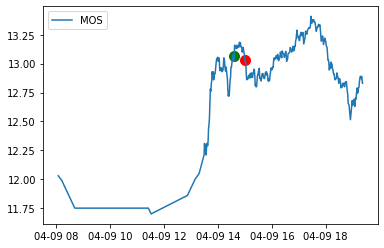

now=2020-04-09 10:47:11.147058
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 08:00:00-04:00  3.2300  3.2300  3.2300  3.2300     500
2020-03-30 09:00:00-04:00  3.3100  3.3100  3.3100  3.3100     200
2020-03-30 09:16:00-04:00  3.3100  3.3100  3.3100  3.3100     249
2020-03-30 09:30:00-04:00  3.3200  3.3200  3.3100  3.3200   20910
2020-03-30 09:31:00-04:00  3.3100  3.3100  3.2632  3.2632   12393
...                           ...     ...     ...     ...     ...
2020-04-09 15:18:00-04:00  3.5600  3.5650  3.5600  3.5600    7718
2020-04-09 15:19:00-04:00  3.5601  3.5656  3.5600  3.5650   18378
2020-04-09 15:20:00-04:00  3.5700  3.5700  3.5500  3.5500   46556
2020-04-09 15:21:00-04:00  3.5500  3.5550  3.5500  3.5500   51092
2020-04-09 15:22:00-04:00  3.5500  3.5595  3.5500  3.5500   15646

[3552 rows x 5 columns]
index:3276 data:3.25
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
sta

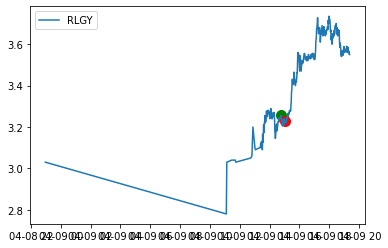

now=2020-04-09 09:54:20.109444
                              open    high     low  close   volume
timestamp                                                         
2020-03-30 08:34:00-04:00  17.9600  17.960  17.960  17.96   1896.0
2020-03-30 09:18:00-04:00  18.2100  18.210  18.210  18.21    100.0
2020-03-30 09:28:00-04:00  18.2000  18.200  18.200  18.20    200.0
2020-03-30 09:30:00-04:00  18.0000  18.170  17.600  17.60  38247.0
2020-03-30 09:31:00-04:00  17.6001  17.700  17.540  17.54  10519.0
...                            ...     ...     ...    ...      ...
2020-04-09 15:18:00-04:00  18.2500  18.250  18.220  18.22   3608.0
2020-04-09 15:19:00-04:00  18.2150  18.215  18.190  18.19   3989.0
2020-04-09 15:20:00-04:00  18.2000  18.220  18.185  18.20   6740.0
2020-04-09 15:21:00-04:00  18.2000  18.210  18.170  18.17   5313.0
2020-04-09 15:22:00-04:00  18.1700  18.185  18.160  18.16   5435.0

[3531 rows x 5 columns]
index:3202 data:18.39
start
Series([], Freq: 5T, Name: close, dtype: floa

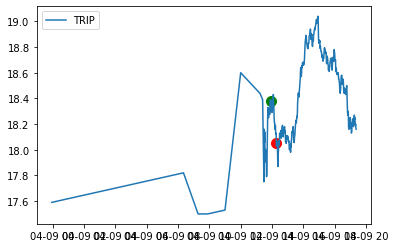

now=2020-04-09 10:45:41.173257
                           open  high     low   close  volume
timestamp                                                    
2020-03-30 08:20:00-04:00  3.40  3.40  3.4000  3.4000     800
2020-03-30 08:21:00-04:00  3.40  3.40  3.4000  3.4000     612
2020-03-30 09:09:00-04:00  3.41  3.41  3.4100  3.4100     204
2020-03-30 09:30:00-04:00  3.59  3.59  3.5500  3.5900   23509
2020-03-30 09:31:00-04:00  3.58  3.58  3.4901  3.4901    1199
...                         ...   ...     ...     ...     ...
2020-04-08 11:11:00-04:00  3.17  3.17  3.1700  3.1700    4196
2020-04-08 11:12:00-04:00  3.18  3.19  3.1800  3.1900    2232
2020-04-08 11:13:00-04:00  3.19  3.19  3.1900  3.1900     800
2020-04-08 11:14:00-04:00  3.20  3.20  3.1900  3.1900    1506
2020-04-08 11:15:00-04:00  3.18  3.19  3.1800  3.1800    5390

[2412 rows x 5 columns]
index:2411 data:3.18
start
timestamp
2020-04-07 14:20:00-04:00    2.9200
2020-04-07 14:25:00-04:00    2.9300
2020-04-07 14:30:00-04:00    

  1.000e-02 -1.000e-02  0.000e+00 -5.000e-03 -5.000e-03  2.000e-02]
[  2   3   5   6   8  10  18  20  23  25  30  35  40  41  45  50  52  54
  55  60  63  64  66  74  77  79  84  87  88  90  95  98 101 106 109 111
 114 116 118 130 132 135 140 151 154 157 161 163 169 172 178 179 181 184
 186 192 196 199 202 206 207 211 217 219 226 232 233 235 236 240 246 249
 251 253 257 260 264 270 274 279 280 285 287 293 302 304 307 309 311 316
 320 322 325 328 332 334 336 337 342 344 346 347 350 353 358 360 362 365
 372 374 377 384 389 392 394 397 402 404 407 409 416 420 421 424 427 433
 435 439 441]
local_maximas=[]
start
timestamp
2020-03-31 13:20:00-04:00    3.605
2020-03-31 13:25:00-04:00    3.620
2020-03-31 13:30:00-04:00    3.600
2020-03-31 13:35:00-04:00    3.600
2020-03-31 13:40:00-04:00    3.600
2020-03-31 13:45:00-04:00    3.600
2020-03-31 13:50:00-04:00    3.600
2020-03-31 13:55:00-04:00    3.600
2020-03-31 14:00:00-04:00    3.600
2020-03-31 14:05:00-04:00    3.600
Name: close, dtype: floa

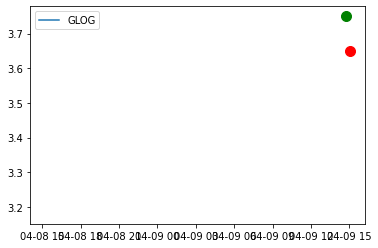

now=2020-04-09 10:05:43.208583
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 07:00:00-04:00  4.0200  4.0200  4.0200  4.0200     520
2020-03-30 08:00:00-04:00  4.0200  4.0200  4.0200  4.0200    1550
2020-03-30 08:06:00-04:00  4.0200  4.0200  4.0200  4.0200     100
2020-03-30 09:30:00-04:00  4.0300  4.0700  4.0200  4.0416   16374
2020-03-30 09:32:00-04:00  4.0525  4.0525  4.0525  4.0525     583
...                           ...     ...     ...     ...     ...
2020-04-09 15:11:00-04:00  3.9592  3.9592  3.9592  3.9592     250
2020-04-09 15:15:00-04:00  3.9550  3.9550  3.9550  3.9550    6754
2020-04-09 15:18:00-04:00  3.9700  3.9700  3.9700  3.9700     252
2020-04-09 15:19:00-04:00  3.9900  3.9900  3.9900  3.9900     101
2020-04-09 15:20:00-04:00  3.9800  3.9900  3.9800  3.9850     326

[1891 rows x 5 columns]
index:1705 data:3.9401
start
timestamp
2020-04-09 09:50:00-04:00    3.94
2020-04-09 09

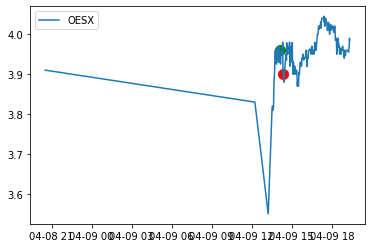

now=2020-04-09 10:43:05.151005
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 07:00:00-04:00  2.1000  2.1000  2.1000  2.1000     502
2020-03-30 07:12:00-04:00  2.0500  2.0500  2.0500  2.0500     230
2020-03-30 07:15:00-04:00  2.0500  2.0500  2.0500  2.0500     100
2020-03-30 07:18:00-04:00  2.0500  2.0500  2.0500  2.0500    1000
2020-03-30 08:00:00-04:00  2.0400  2.0400  2.0400  2.0400     621
...                           ...     ...     ...     ...     ...
2020-04-09 15:18:00-04:00  2.7000  2.7000  2.6900  2.6950    6330
2020-04-09 15:19:00-04:00  2.6950  2.6950  2.6901  2.6950    2812
2020-04-09 15:20:00-04:00  2.7000  2.7000  2.6900  2.6950    4100
2020-04-09 15:21:00-04:00  2.6950  2.6950  2.6800  2.6800   21968
2020-04-09 15:22:00-04:00  2.6808  2.6808  2.6808  2.6808    1216

[3379 rows x 5 columns]
index:3109 data:2.7991
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
s

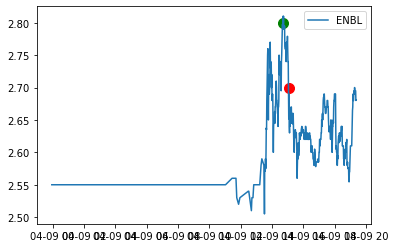

now=2020-04-09 10:41:33.744991
                              open    high    low   close  volume
timestamp                                                        
2020-03-30 07:00:00-04:00  16.4000  16.400  16.40  16.400     300
2020-03-30 08:47:00-04:00  16.4100  16.410  16.40  16.400     200
2020-03-30 09:01:00-04:00  16.6000  16.600  16.60  16.600     700
2020-03-30 09:10:00-04:00  16.4000  16.400  16.40  16.400     300
2020-03-30 09:17:00-04:00  16.5300  16.530  16.53  16.530     700
...                            ...     ...    ...     ...     ...
2020-04-09 15:14:00-04:00  15.4284  15.490  15.42  15.420    2158
2020-04-09 15:15:00-04:00  15.4500  15.450  15.41  15.410    1107
2020-04-09 15:18:00-04:00  15.4400  15.450  15.44  15.440     900
2020-04-09 15:19:00-04:00  15.4000  15.400  15.40  15.400     300
2020-04-09 15:22:00-04:00  15.3600  15.395  15.36  15.395     400

[2547 rows x 5 columns]
index:2325 data:15.93
start
Series([], Freq: 5T, Name: close, dtype: float64)
[]
[]
st

local_maximas=[]
start
timestamp
2020-04-01 10:25:00-04:00    12.2499
2020-04-01 10:30:00-04:00    12.3361
2020-04-01 10:35:00-04:00    12.2800
2020-04-01 10:40:00-04:00    12.2400
2020-04-01 10:45:00-04:00    12.1300
2020-04-01 10:50:00-04:00    12.1255
2020-04-01 10:55:00-04:00    12.2500
2020-04-01 11:00:00-04:00    12.2500
2020-04-01 11:05:00-04:00    12.2300
2020-04-01 11:10:00-04:00    12.2250
Name: close, dtype: float64
[ 8.620e-02 -5.610e-02 -4.000e-02 -1.100e-01 -4.500e-03  1.245e-01
  0.000e+00 -2.000e-02 -5.000e-03 -6.500e-02  0.000e+00 -9.000e-02
  4.880e-02 -5.280e-02  2.400e-02  7.000e-02  9.000e-02 -1.400e-01
 -3.000e-02  3.500e-02 -3.500e-02 -1.000e-02 -6.010e-02 -1.199e-01
 -2.500e-02 -6.500e-02 -1.000e-02  4.000e-02 -2.000e-02  1.100e-01
  1.700e-01 -1.300e-01 -1.000e-01  4.000e-02  1.000e-02 -3.580e-02
  6.580e-02 -2.100e-01 -3.940e-02 -9.060e-02 -9.000e-02  0.000e+00
  2.000e-02 -4.000e-02  6.000e-02  1.500e-01 -5.000e-02 -8.000e-02
  5.000e-03  8.500e-02  0.000e+00

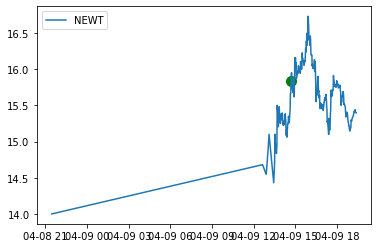

now=2020-04-09 09:49:40.313044
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 09:30:00-04:00  2.5000  2.5100  2.5000  2.5100    2974
2020-03-30 09:32:00-04:00  2.5100  2.5100  2.5100  2.5100     312
2020-03-30 09:34:00-04:00  2.4632  2.4632  2.4632  2.4632    2007
2020-03-30 09:39:00-04:00  2.4604  2.4604  2.4604  2.4604     161
2020-03-30 09:40:00-04:00  2.5094  2.5094  2.5094  2.5094     200
...                           ...     ...     ...     ...     ...
2020-04-09 15:16:00-04:00  2.3915  2.4000  2.3915  2.4000     803
2020-04-09 15:17:00-04:00  2.4200  2.4227  2.4200  2.4227     201
2020-04-09 15:19:00-04:00  2.4200  2.4300  2.4200  2.4300     200
2020-04-09 15:20:00-04:00  2.4200  2.4200  2.4200  2.4200     100
2020-04-09 15:22:00-04:00  2.4200  2.4400  2.4200  2.4400     200

[1549 rows x 5 columns]
index:1377 data:2.45
start
timestamp
2020-04-08 15:45:00-04:00    2.230
2020-04-08 15:

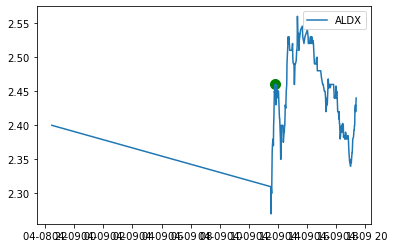

now=2020-04-09 10:47:57.700912
                              open     high      low    close  volume
timestamp                                                            
2020-03-30 09:30:00-04:00  18.6800  18.7501  18.6800  18.7501    2464
2020-03-30 09:34:00-04:00  18.7501  18.7501  18.7501  18.7501     281
2020-03-30 09:35:00-04:00  18.8650  18.8650  18.8650  18.8650     541
2020-03-30 09:40:00-04:00  19.2240  19.2240  19.2240  19.2240     220
2020-03-30 09:41:00-04:00  19.0150  19.0150  19.0150  19.0150     189
...                            ...      ...      ...      ...     ...
2020-04-09 15:17:00-04:00  20.0600  20.0600  19.9000  20.0400   59742
2020-04-09 15:19:00-04:00  20.0400  20.0950  20.0100  20.0100    1640
2020-04-09 15:20:00-04:00  20.0950  20.1600  20.0600  20.1600     716
2020-04-09 15:21:00-04:00  20.1350  20.1350  20.1350  20.1350     200
2020-04-09 15:22:00-04:00  20.1425  20.1600  20.1300  20.1600    1374

[2386 rows x 5 columns]
index:2182 data:19.68
start
Series

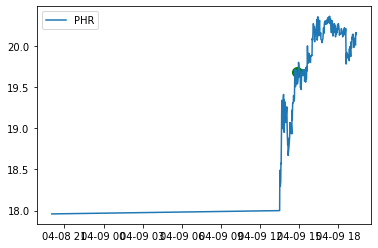

now=2020-04-09 12:21:38.726908
                            open   high    low   close  volume
timestamp                                                     
2020-03-30 04:59:00-04:00  6.320  6.330  6.320  6.3300    1703
2020-03-30 05:07:00-04:00  6.330  6.330  6.330  6.3300     481
2020-03-30 05:21:00-04:00  6.340  6.340  6.340  6.3400     190
2020-03-30 05:51:00-04:00  6.390  6.390  6.390  6.3900     100
2020-03-30 06:09:00-04:00  6.390  6.390  6.390  6.3900     153
...                          ...    ...    ...     ...     ...
2020-04-09 15:18:00-04:00  9.280  9.285  9.240  9.2400   11440
2020-04-09 15:19:00-04:00  9.240  9.250  9.230  9.2300    5687
2020-04-09 15:20:00-04:00  9.240  9.330  9.240  9.3000   21030
2020-04-09 15:21:00-04:00  9.290  9.390  9.235  9.3900   68967
2020-04-09 15:22:00-04:00  9.385  9.450  9.370  9.3899   29219

[3938 rows x 5 columns]
index:3757 data:10.32
start
timestamp
2020-04-09 12:00:00-04:00    10.21
2020-04-09 12:05:00-04:00    10.23
2020-04-09 12:10:

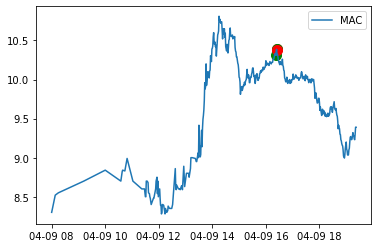

now=2020-04-09 12:22:36.969285
                             open   high    low  close  volume
timestamp                                                     
2020-03-30 09:30:00-04:00  5.4400  5.570  5.440  5.520    4913
2020-03-30 09:31:00-04:00  5.5300  5.530  5.530  5.530     401
2020-03-30 09:32:00-04:00  5.5300  5.530  5.320  5.320     360
2020-03-30 09:33:00-04:00  5.5200  5.520  5.460  5.460     311
2020-03-30 09:34:00-04:00  5.4500  5.450  5.400  5.400     207
...                           ...    ...    ...    ...     ...
2020-04-08 11:38:00-04:00  5.3350  5.335  5.335  5.335     400
2020-04-08 11:39:00-04:00  5.3350  5.335  5.335  5.335     200
2020-04-08 11:40:00-04:00  5.3325  5.350  5.330  5.330   18138
2020-04-08 11:41:00-04:00  5.3350  5.340  5.330  5.330    2892
2020-04-08 11:42:00-04:00  5.3300  5.330  5.310  5.320    3186

[2232 rows x 5 columns]
index:2231 data:5.32
start
timestamp
2020-04-07 14:15:00-04:00    5.2400
2020-04-07 14:20:00-04:00    5.2800
2020-04-07 14:25

 -0.01   -0.01    0.      0.005  -0.005 ]
[  6  10  12  18  21  22  24  28  30  32  35  42  46  47  50  54  55  56
  60  64  66  67  68  72  78  80  81  84  86  92  96  99 100 106 108 111
 114 117 121 129 131 133 137 145 148 151 155 157 163 165 168 173 177 182
 184 186 187 193 195 197 203 207 211 215 217 219 223 224 227 231 235 237
 239 241 243 248 249 251 254 255 260 261 268 272 273 275 277 279 285 290
 292 294 297 298 302 304 309 317 319 321 323 326 332 333 337 338 340 342
 343 345 347 349 351 354 359 363 370 371 375 377 378 382 385 389 391 394
 397 402 403 405 410 411 414 415 419 425 431 435 436 438 442 447 450 454
 457 459 463]
local_maximas=[]
start
timestamp
2020-03-31 12:00:00-04:00    5.3400
2020-03-31 12:05:00-04:00    5.3200
2020-03-31 12:10:00-04:00    5.3300
2020-03-31 12:15:00-04:00    5.3400
2020-03-31 12:20:00-04:00    5.3200
2020-03-31 12:25:00-04:00    5.2800
2020-03-31 12:30:00-04:00    5.2900
2020-03-31 12:35:00-04:00    5.2500
2020-03-31 12:40:00-04:00    5.2639
202

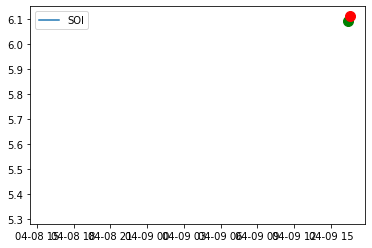

now=2020-04-09 12:27:57.190519
                              open   high     low  close    volume
timestamp                                                         
2020-03-30 07:00:00-04:00  13.7500  13.75  13.750  13.75     103.0
2020-03-30 07:44:00-04:00  13.6000  13.60  13.600  13.60     800.0
2020-03-30 07:47:00-04:00  13.5000  13.50  13.500  13.50    1000.0
2020-03-30 07:54:00-04:00  13.5000  13.50  13.500  13.50     110.0
2020-03-30 07:56:00-04:00  13.5900  13.59  13.590  13.59     200.0
...                            ...    ...     ...    ...       ...
2020-04-09 15:18:00-04:00  15.2800  15.28  15.260  15.26   53064.0
2020-04-09 15:19:00-04:00  15.2650  15.28  15.250  15.26  114934.0
2020-04-09 15:20:00-04:00  15.2700  15.33  15.265  15.29   97776.0
2020-04-09 15:21:00-04:00  15.2900  15.30  15.230  15.24   83496.0
2020-04-09 15:22:00-04:00  15.2463  15.28  15.215  15.22   79996.0

[3837 rows x 5 columns]
index:3662 data:15.4728
start
timestamp
2020-04-09 12:00:00-04:00    15.4

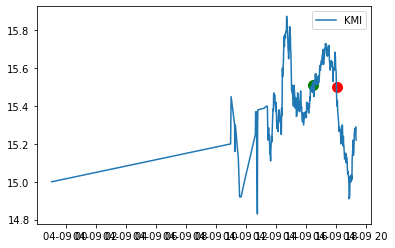

now=2020-04-09 12:25:04.788915
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 08:00:00-04:00  5.2000  5.2000  5.2000  5.2000     600
2020-03-30 08:01:00-04:00  5.2100  5.2100  5.2000  5.2000    4022
2020-03-30 08:16:00-04:00  5.0001  5.0001  5.0001  5.0001    1000
2020-03-30 08:17:00-04:00  5.0100  5.0100  5.0100  5.0100     100
2020-03-30 08:24:00-04:00  5.0100  5.0100  5.0100  5.0100     200
...                           ...     ...     ...     ...     ...
2020-04-09 15:18:00-04:00  7.2200  7.2250  7.1700  7.1900   76050
2020-04-09 15:19:00-04:00  7.1950  7.2000  7.1500  7.1600   42059
2020-04-09 15:20:00-04:00  7.1700  7.2000  7.1550  7.1650   27695
2020-04-09 15:21:00-04:00  7.1650  7.1659  7.1200  7.1450   30675
2020-04-09 15:22:00-04:00  7.1400  7.1800  7.1400  7.1500   45463

[3843 rows x 5 columns]
index:3665 data:8.085
start
timestamp
2020-04-09 12:00:00-04:00    7.9000
2020-04-09 1

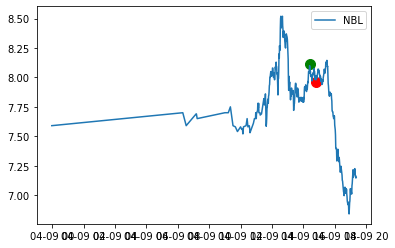

now=2020-04-09 12:26:34.285088
                            open    high    low  close  volume
timestamp                                                     
2020-03-30 09:04:00-04:00  1.320  1.3200  1.320  1.320     249
2020-03-30 09:30:00-04:00  1.300  1.3200  1.290  1.305   69036
2020-03-30 09:31:00-04:00  1.290  1.2900  1.280  1.280    6729
2020-03-30 09:32:00-04:00  1.280  1.2800  1.250  1.250    6636
2020-03-30 09:33:00-04:00  1.250  1.2599  1.250  1.250    1288
...                          ...     ...    ...    ...     ...
2020-04-09 15:18:00-04:00  2.140  2.1400  2.135  2.135    2660
2020-04-09 15:19:00-04:00  2.130  2.1399  2.120  2.120   20318
2020-04-09 15:20:00-04:00  2.120  2.1250  2.105  2.105   10182
2020-04-09 15:21:00-04:00  2.105  2.1050  2.105  2.105    2326
2020-04-09 15:22:00-04:00  2.105  2.1100  2.100  2.100    9998

[3307 rows x 5 columns]
index:3131 data:2.225
start
timestamp
2020-04-09 12:00:00-04:00    2.180
2020-04-09 12:05:00-04:00    2.210
2020-04-09 12:10:

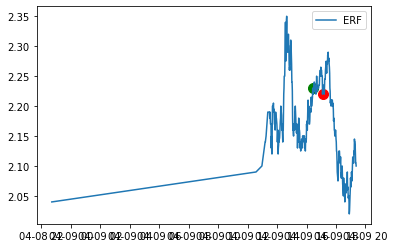

now=2020-04-09 12:24:36.837035
                             open    high     low   close  volume
timestamp                                                        
2020-03-30 07:09:00-04:00  13.500  13.500  13.500  13.500     200
2020-03-30 08:34:00-04:00  13.910  13.910  13.910  13.910   21419
2020-03-30 09:29:00-04:00  13.770  13.770  13.590  13.640    2259
2020-03-30 09:30:00-04:00  13.750  13.870  13.570  13.710  523017
2020-03-30 09:31:00-04:00  13.720  13.830  13.605  13.780   99008
...                           ...     ...     ...     ...     ...
2020-04-09 15:18:00-04:00  16.440  16.460  16.410  16.455   43874
2020-04-09 15:19:00-04:00  16.455  16.475  16.430  16.435   65680
2020-04-09 15:20:00-04:00  16.440  16.525  16.435  16.505   75779
2020-04-09 15:21:00-04:00  16.505  16.505  16.430  16.430   47151
2020-04-09 15:22:00-04:00  16.430  16.485  16.380  16.390   55559

[3601 rows x 5 columns]
index:3423 data:16.19
start
timestamp
2020-04-09 12:00:00-04:00    16.14
2020-04-09 12

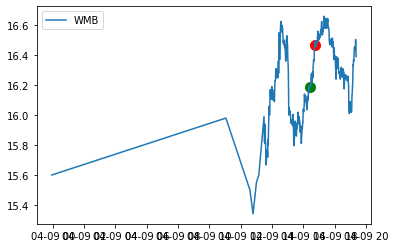

now=2020-04-09 12:13:11.893331
                            open   high     low   close  volume
timestamp                                                      
2020-03-30 07:22:00-04:00  7.900  7.900  7.9000  7.9000    2500
2020-03-30 09:24:00-04:00  7.820  7.820  7.8200  7.8200     100
2020-03-30 09:29:00-04:00  7.960  7.960  7.9600  7.9600     100
2020-03-30 09:30:00-04:00  7.990  8.040  7.8200  7.8200    8571
2020-03-30 09:31:00-04:00  7.820  7.820  7.8200  7.8200     100
...                          ...    ...     ...     ...     ...
2020-04-09 15:18:00-04:00  5.675  5.675  5.6301  5.6301   10658
2020-04-09 15:19:00-04:00  5.635  5.650  5.6350  5.6500    6832
2020-04-09 15:20:00-04:00  5.650  5.665  5.6500  5.6600    5822
2020-04-09 15:21:00-04:00  5.655  5.660  5.6300  5.6300    3360
2020-04-09 15:22:00-04:00  5.640  5.660  5.6400  5.6600    2093

[3476 rows x 5 columns]
index:3288 data:5.73
start
timestamp
2020-04-09 12:00:00-04:00    5.665
2020-04-09 12:05:00-04:00    5.740
2020-

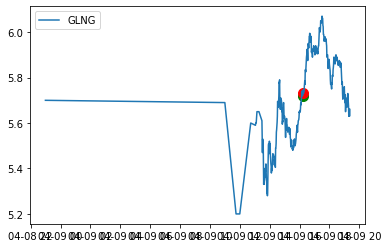

now=2020-04-09 12:24:15.611196
                             open     high     low    close    volume
timestamp                                                            
2020-03-30 05:27:00-04:00   9.490   9.5000   9.490   9.5000    1851.0
2020-03-30 07:09:00-04:00   9.500   9.5000   9.500   9.5000     300.0
2020-03-30 08:02:00-04:00   9.500   9.5000   9.500   9.5000     109.0
2020-03-30 08:03:00-04:00   9.500   9.5000   9.500   9.5000     500.0
2020-03-30 08:04:00-04:00   9.550   9.5500   9.550   9.5500     200.0
...                           ...      ...     ...      ...       ...
2020-04-09 15:18:00-04:00  11.770  11.7767  11.765  11.7700   81240.0
2020-04-09 15:19:00-04:00  11.770  11.7700  11.690  11.7035  117288.0
2020-04-09 15:20:00-04:00  11.700  11.7100  11.680  11.6900   45630.0
2020-04-09 15:21:00-04:00  11.690  11.7000  11.650  11.6700   84998.0
2020-04-09 15:22:00-04:00  11.675  11.7100  11.675  11.7010   33594.0

[4209 rows x 5 columns]
index:4030 data:11.94
start
timest

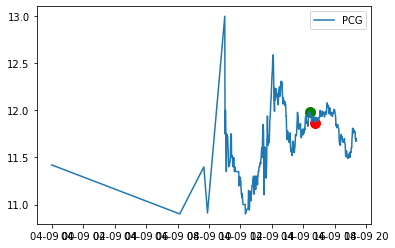

now=2020-04-09 12:15:04.821659
                           open  high   low  close  volume
timestamp                                                 
2020-03-30 08:46:00-04:00  5.61  5.61  5.61   5.61     100
2020-03-30 09:14:00-04:00  5.58  5.59  5.58   5.59    2200
2020-03-30 09:17:00-04:00  5.58  5.59  5.58   5.59    2143
2020-03-30 09:18:00-04:00  5.60  5.62  5.60   5.62    1342
2020-03-30 09:30:00-04:00  5.44  5.47  5.44   5.47   12412
...                         ...   ...   ...    ...     ...
2020-04-09 15:16:00-04:00  5.07  5.07  5.07   5.07     365
2020-04-09 15:17:00-04:00  5.08  5.08  5.08   5.08     355
2020-04-09 15:18:00-04:00  5.10  5.10  5.07   5.07     626
2020-04-09 15:19:00-04:00  5.06  5.07  5.06   5.07     702
2020-04-09 15:20:00-04:00  5.06  5.06  5.05   5.05     389

[2310 rows x 5 columns]
index:2201 data:4.94
start
timestamp
2020-04-09 09:50:00-04:00    4.8300
2020-04-09 09:55:00-04:00    4.8101
2020-04-09 10:00:00-04:00    4.8400
2020-04-09 10:05:00-04:00    4.8

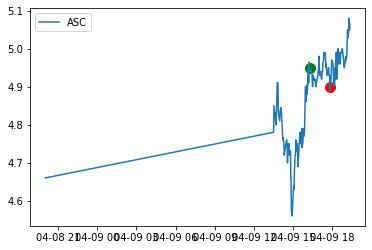

now=2020-04-09 12:21:47.894695
                             open  high     low  close  volume
timestamp                                                     
2020-03-30 04:11:00-04:00  4.2000  4.20  4.2000   4.20    1000
2020-03-30 07:02:00-04:00  4.0100  4.01  4.0100   4.01    2500
2020-03-30 07:03:00-04:00  4.0000  4.00  4.0000   4.00     100
2020-03-30 08:00:00-04:00  3.8000  4.00  3.8000   4.00     612
2020-03-30 08:01:00-04:00  3.7500  3.75  3.7500   3.75     200
...                           ...   ...     ...    ...     ...
2020-04-09 15:17:00-04:00  5.6800  5.68  5.6700   5.68     820
2020-04-09 15:18:00-04:00  5.6899  5.69  5.6899   5.69    1388
2020-04-09 15:19:00-04:00  5.6700  5.69  5.6100   5.61   36879
2020-04-09 15:20:00-04:00  5.6499  5.65  5.6200   5.65    1166
2020-04-09 15:21:00-04:00  5.6500  5.65  5.6000   5.60    2374

[3569 rows x 5 columns]
index:3394 data:5.93
start
timestamp
2020-04-09 11:50:00-04:00    5.830
2020-04-09 11:55:00-04:00    5.895
2020-04-09 12:00:0

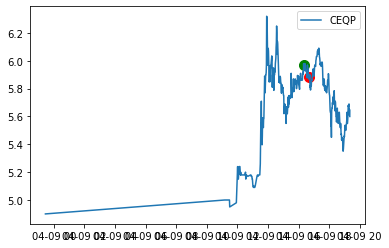

In [140]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

